# 1.0 Importing the data and matching the CAPs with the two files

In [2]:
# The process starts with loading survey data from Qualtrics, and clean it; as also not all responses were completed, and then, trying to merge the data
# about public transport supply in the area of origins based on individuals (CAP)

In [3]:
import pandas as pd

# File paths
survey_file_path = "D:\\15_Polimi\\Polimi_onedrive\\OneDrive - Politecnico di Milano\\PhD\\people\\Survery\\MMH_26-11-2024.xlsx"
cap_file_path = "D:\\15_Polimi\\Polimi_onedrive\\OneDrive - Politecnico di Milano\\PhD\\people\\Survery\\CAPs\\CAP_complete\\CAP_COMPLETE-updated.csv"
output_file_path = "D:\\15_Polimi\\Polimi_onedrive\\OneDrive - Politecnico di Milano\\PhD\\people\\Survery\\CAPs\\CAP_complete\\CAP_COMPLETE_MERGED.csv"

# Load the survey data (Excel file)
excel_data = pd.ExcelFile(survey_file_path)
df = excel_data.parse(sheet_name=0, header=[0, 1])
data = df.iloc[2:, :]  # Actual data starts from the third row
filtered_data = data[data[("Finished", "Finished")] == True]

# Flatten the multi-level columns of `filtered_data`
filtered_data.columns = filtered_data.columns.get_level_values(1)
filtered_data.reset_index(drop=True, inplace=True)

# Rename the CAP column in `filtered_data`
filtered_data.rename(columns={
    'What is the postal code (CAP) of the place you live during the week? Consider the place where you spend more time.': 'CAP'
}, inplace=True)

# Load the second dataset (CSV file)
cap_data = pd.read_csv(cap_file_path)

# Perform the merge on the 'CAP' column
merged_data = pd.merge(
    filtered_data, 
    cap_data[['CAP', 'distance', 'sum', 'unique', 'CAP_Location']],  # Select only relevant columns from cap_data
    on='CAP', 
    how='inner'  # Use 'inner' to keep only matching rows
)


C:\Users\mafgo\AppData\Local\Temp\ipykernel_9204\1094788098.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.rename(columns={


In [4]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329 entries, 0 to 328
Data columns (total 90 columns):
 #   Column                                                                                                                                                                                                                                                        Non-Null Count  Dtype         
---  ------                                                                                                                                                                                                                                                        --------------  -----         
 0   Start Date                                                                                                                                                                                                                                                    329 non-null    datetime64[ns]
 1   End Date            

In [5]:
# Define the required columns for the new DataFrame 'MMI', where Response ID Remains the Random Identification Key for each response in the survey
# Distance: Linear distance between Home (retrieved from CAP, and University Destination)
# Travel Frequency per week
# Travel Legs for average travel between home and University
# Waitng time while transiting 
# Merging all in MMI which stands for Multimodality Index. 
required_columns = [
    'Response ID',
    'distance', 'sum', 'unique',
    'On average, how many days per week do you commute outside the neighbourhood you live in?',
    'Drag and drop the components that describe your trip from Home to School / University / Work / Other. - Groups - Put on order the trip chain',
    'How many minutes does it take your trip from Home to School / University / Work / Other?  And, how many minutes do you spend to transfer (walk and wait)  during your trip from Home to School / University / Work / Other? - Total transfer time in minutes'
]

# Create the new DataFrame 'MMI' with only the required columns
MMI = merged_data[required_columns]


# 2.0 MmI (Multimodality Index)

In [7]:
# Define the mapping dictionary
# As the Survey asked how many times per week, here I transfer text values to numerical values to measure the frequency, I assied .5 to a Rare movement. 
remap_dict = {
    '6 days': 6,
    'Never commute': 0,
    'Everyday': 7,
    '2 days': 2,
    '4 days': 4,
    '5 days Monday-Friday': 5,
    '3 days': 3,
    'Once a week': 1,
    'Rarely commute Less than once a week': 0.5,
    'On average, how many days per week do you commute outside the neighbourhood you live in?': 0
}

# Column name to remap
column_to_remap = 'On average, how many days per week do you commute outside the neighbourhood you live in?'

# Apply the remap explicitly using .loc
MMI.loc[:, column_to_remap] = MMI[column_to_remap].map(remap_dict)


In [8]:
# Column name to process
# On the line, I am processing the travel components where users drag and drop to describe their movement. in the data, it seprates with them using a 
# comma, so I am using it to count how many travel legs people have done 
# For instance, a response like ( I walk to the station, I take a bus, and I walk to finial destination ) will count as '3' travel legs... In the survey, 
# I always make it by default that people will walk first, then, they can do whatever they want, they also can remove this default component, and add their
# own custmized component. 
column_name = 'Drag and drop the components that describe your trip from Home to School / University / Work / Other. - Groups - Put on order the trip chain'

# Count the number of legs by counting commas and adding 1
MMI['Number of Legs'] = MMI[column_name].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)


C:\Users\mafgo\AppData\Local\Temp\ipykernel_9204\728624656.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MMI['Number of Legs'] = MMI[column_name].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)


In [9]:
# Column name to process
# Here I am processing waiting time, that is often a slider in the survey where users can select between 0 to 90 minutes, for some reason, some respnses 
# were counted as Nulls, so, here I am replacing Nullls (no records) with 0. assuming that users refer themselves as 

column_name = 'How many minutes does it take your trip from Home to School / University / Work / Other?  And, how many minutes do you spend to transfer (walk and wait)  during your trip from Home to School / University / Work / Other? - Total transfer time in minutes'

# Replace NaN values with 0
MMI[column_name] = MMI[column_name].fillna(0)


C:\Users\mafgo\AppData\Local\Temp\ipykernel_9204\2159334704.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MMI[column_name] = MMI[column_name].fillna(0)


In [10]:
# Column name to process
# On the line, I am processing the travel components where users drag and drop to describe their movement. in the data, it seprates with them using a 
# comma, so I am using it to count how many travel legs people have done 
# For instance, a response like ( I walk to the station, I take a bus, and I walk to finial destination ) will count as '3' travel legs... In the survey, 
# I always make it by default that people will walk first, then, they can do whatever they want, they also can remove this default component, and add their
# own custmized component. 
column_name = 'Drag and drop the components that describe your trip from Home to School / University / Work / Other. - Groups - Put on order the trip chain'

# Count the number of legs by counting commas and adding 1
MMI['Number of Legs'] = MMI[column_name].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)


C:\Users\mafgo\AppData\Local\Temp\ipykernel_9204\728624656.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MMI['Number of Legs'] = MMI[column_name].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)


In [11]:
# Rename columns
# The col name was too long, so I am shorting it, to make the code appeal good 
MMI.rename(columns={
    'On average, how many days per week do you commute outside the neighbourhood you live in?': 'frequency',
    'How many minutes does it take your trip from Home to School / University / Work / Other?  And, how many minutes do you spend to transfer (walk and wait)  during your trip from Home to School / University / Work / Other? - Total transfer time in minutes': 'transfer'
}, inplace=True)

# Drop the specified column
MMI.drop(columns=['Drag and drop the components that describe your trip from Home to School / University / Work / Other. - Groups - Put on order the trip chain'], inplace=True)


C:\Users\mafgo\AppData\Local\Temp\ipykernel_9204\1429008140.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MMI.rename(columns={
C:\Users\mafgo\AppData\Local\Temp\ipykernel_9204\1429008140.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MMI.drop(columns=['Drag and drop the components that describe your trip from Home to School / University / Work / Other. - Groups - Put on order the trip chain'], inplace=True)


In [12]:
MMI.head(3)

Response ID   distance   sum  unique frequency  transfer  \
0  R_6JmlJEGCOWo9rTX  15.044886  32.0     1.0       7.0       0.0   
1  R_61z5R1KEmMv8GGz  20.372493   8.0     1.0       6.0       0.0   
2  R_2QS9J3nCE9mYu8B   2.424350  58.0     5.0       7.0       0.0   

   Number of Legs  
0               4  
1               4  
2               4

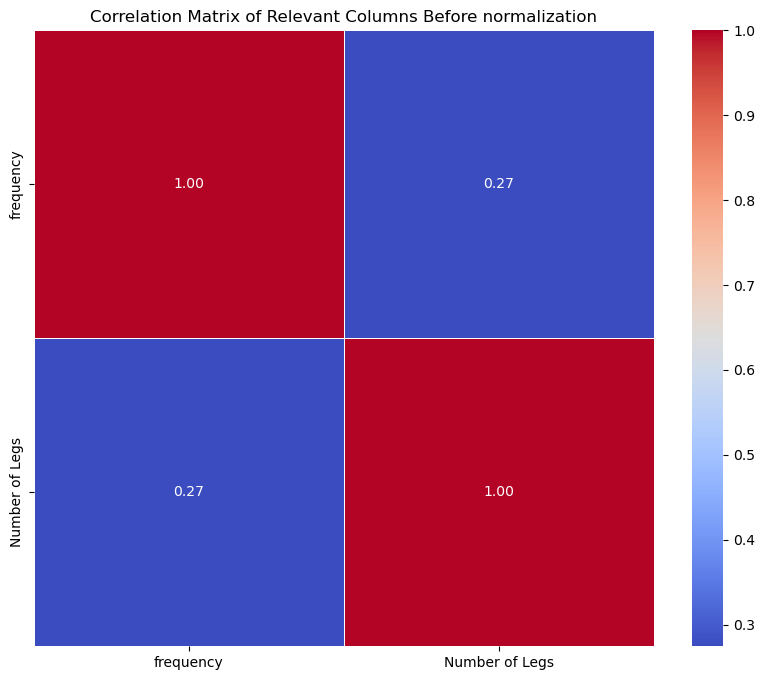

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix for the relevant columns
correlation_matrix = MMI[[ 'frequency', 'Number of Legs']].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Relevant Columns Before normalization")
plt.show()


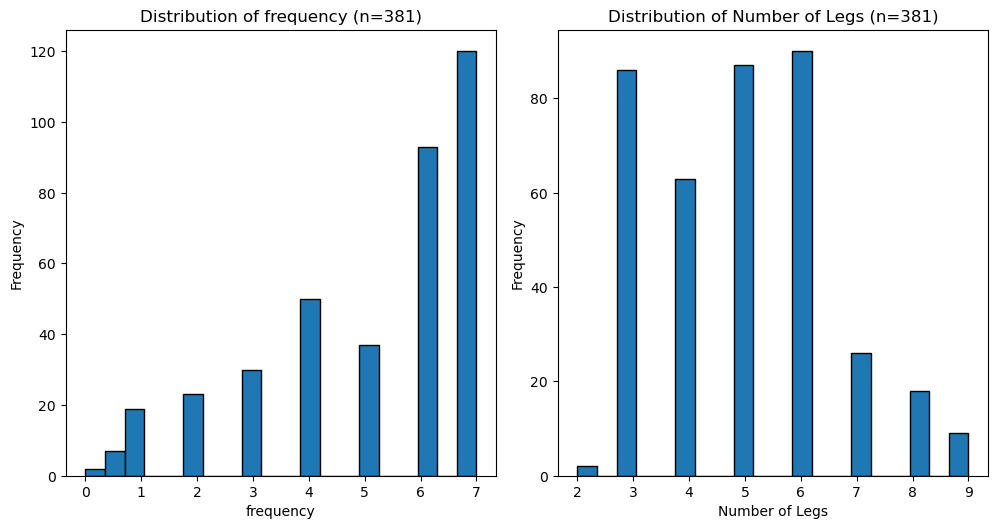

In [14]:
# List of columns to visualize skewness
columns = ['frequency', 'Number of Legs']

# Plot histograms for each column to check skewness
plt.figure(figsize=(15, 10))

for i, col in enumerate(columns, 1):
    plt.subplot(2, 3, i)
    n = len(MMI[col].dropna())  # Count non-NA records in the column
    plt.hist(MMI[col], bins=20, edgecolor='black')
    plt.title(f"Distribution of {col} (n={n})")
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [15]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from scipy.stats import zscore

# Ensure MMI_cleaned is a deep copy to avoid SettingWithCopyWarning
MMI = MMI.copy()

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Normalize the selected columns (convert them to float before assignment)
columns_to_normalize = ['frequency', 'Number of Legs']
MMI[columns_to_normalize] = MMI[columns_to_normalize].astype(float)
MMI.loc[:, columns_to_normalize] = scaler.fit_transform(MMI[columns_to_normalize])

# 1. Calculate MMI_1: Number of Legs 


MMI['MI_1'] = np.sqrt(MMI['Number of Legs'] * MMI['frequency'])


# Define the epsilon value
epsilon = 1e-6

# Function to adjust values close to 0 and 1
def adjust_values(x, epsilon=1e-6):
    if x <= epsilon:
        return x + epsilon
    elif x >= 1 - epsilon:
        return x - epsilon
    return x

# Apply the adjustment function to the relevant columns
columns_to_adjust = ['Number of Legs', 'frequency']

for col in columns_to_adjust:
    MMI[col] = MMI[col].apply(lambda x: adjust_values(x, epsilon))


# Ensure MMI_cleaned is a deep copy to avoid SettingWithCopyWarning
MMI = MMI.copy()


# Calculate the z-score for the 'MI_1' column
MMI['Multimodality_zScore'] = zscore(MMI['MI_1'])


In [16]:
pd.concat([MMI.head(3), MMI.tail(3)])

Response ID   distance    sum  unique  frequency  transfer  \
0    R_6JmlJEGCOWo9rTX  15.044886   32.0     1.0   0.999999       0.0   
1    R_61z5R1KEmMv8GGz  20.372493    8.0     1.0   0.857143       0.0   
2    R_2QS9J3nCE9mYu8B   2.424350   58.0     5.0   0.999999       0.0   
378  R_82S6xK8Q8m0Ceye   2.452124   46.0     4.0   0.999999      20.0   
379  R_27pz8nRKYyJZW8h  34.655301   17.0     1.0   0.999999      15.0   
380  R_2q41Zzco1HRd92q   9.237931  142.0     5.0   0.857143       7.0   

     Number of Legs      MI_1  Multimodality_zScore  
0          0.285714  0.534522              0.017263  
1          0.285714  0.494872             -0.170327  
2          0.285714  0.534522              0.017263  
378        0.285714  0.534522              0.017263  
379        0.571429  0.755929              1.064749  
380        0.714286  0.782461              1.190272

## 2.1 Visulizing MmI 

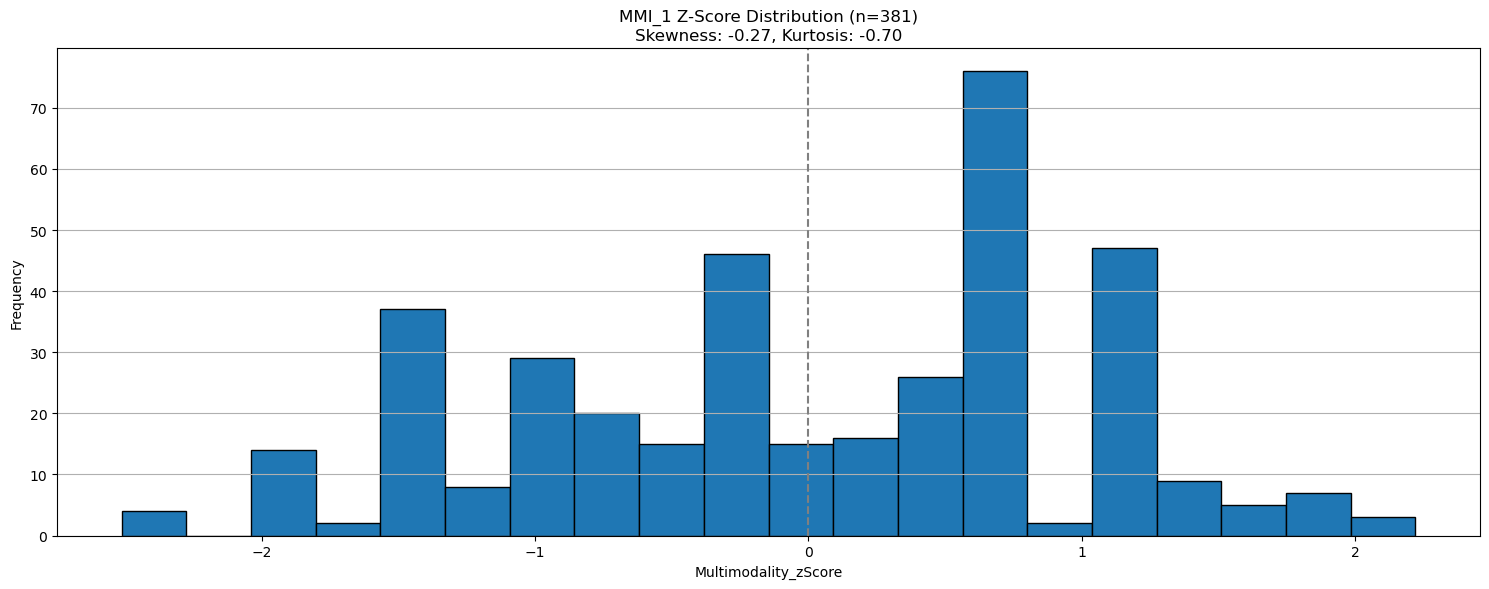

In [18]:
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import numpy as np

# Calculate skewness and kurtosis for 'Multimodality_zScore'
MMI_1_skew = skew(MMI['Multimodality_zScore'].dropna())
MMI_1_kurtosis = kurtosis(MMI['Multimodality_zScore'].dropna(), fisher=True)

# Number of values
n = len(MMI['Multimodality_zScore'].dropna())

# Plot histogram with z-score details
plt.figure(figsize=(15, 6))
plt.hist(MMI['Multimodality_zScore'].dropna(), bins=20, edgecolor='black')

# Add a gray hashed line for z = 0
plt.axvline(0, color='gray', linestyle='--', linewidth=1.5)

# Add title with skewness, kurtosis, and n
plt.title(f"MMI_1 Z-Score Distribution (n={n})\nSkewness: {MMI_1_skew:.2f}, Kurtosis: {MMI_1_kurtosis:.2f}")
plt.xlabel("Multimodality_zScore")
plt.ylabel("Frequency")
plt.grid(axis='y')

# Adjust layout
plt.tight_layout()

# Save plot as PDF
plt.savefig("mMultimodality_zScore_distribution.pdf")

# Show the plot
plt.show()

In [19]:
# Apperiantly the MM1_2 is better than MMI_1 as it gives more symmetrical distrubtion distribtion. 

# 3.0 Motility 

## 3.1 Remapping some quantative parametrs to qualitataive ones 

In [22]:
# In this part of the code, we operationalize Kaufmann's concept of Motility but tweak it to measure Multimodality, which is composed of three equal parts 
# 1.0 Access: means how many transport nodes are available near the Origings and Destination. Multiplied by the kind of subscription users have to access 
# these means of mobility. 
# 2.0 Skills: refers to the person's capacity to use a bike-sharing system and the digital phone to navigate and use the available options. 
# 3.0 Appropriation refers to the attitudes and preferences that count positively if a person uses a mixture of three systems [active mobility, public
# transport, and private cars]. Secondly, an explicit question was made to ask, what is your attitude to changing current mobility behavior, if 
# student answers positively, an extended question is made to know what stimulates this change... 

In [23]:
# Importing relative columns form the survey that can measure the 3 aspects of Motility.

required_columns_2 = [
    'Response ID',
    'Do you have a public transport subscription?',
    'What kind of subscription do you have?',
    'Do you subscribe for more micro-mobility services?  e.g. BikeMi- e-Vai - RideMovi- Lime...',
    #'What are you using these micro - mobility options for?',
    'How often do you use these shared mobility options on a weekly basis?',
    'Do you use your smartphone for commuting purposes?',
    'For what purpose do you use your smartphone?',
    'What stimulate you to change your mobility behavior? - Selected Choice',
    'Rank the most used means of transport you use! (Drag and drop the three most used). - Groups - Drag and drop the most used of transport options in order here',
    'To which extent you are willing to change your mobility behaviour?'
]

In [24]:
# Create the new DataFrame 'Motility' with only the required columns
MOTILITY = merged_data[required_columns_2]

In [25]:
# Filter MOTILITY where 'Respond ID' exists in cleaned_MMI's 'Respond ID'
filtered_MOTILITY = MOTILITY[MOTILITY['Response ID'].isin(MMI['Response ID'])]


In [26]:
# As many questions were made in a qualtative way, the upcoming part is mainly converting some quantataive responses, into qualitataive onces prior 
# processing the answers.

In [27]:
# Define the mapping dictionary
remap_dict = {
    'Yes': 1,
    'No': 0
}
# Column name to remap
column_to_remap = 'Do you have a public transport subscription?'

# Apply the remap explicitly using .loc
MOTILITY.loc[:, column_to_remap] = MOTILITY[column_to_remap].map(remap_dict)

In [28]:
import numpy as np

# Define the mapping dictionary
remap_dict = {
    'Urban Milan M1': 1,
    'Extra Urban (e.g., M1-M3, M1-M4...)': 2,
    'Regional': 3,
    np.nan: 0.25
}

# For Nulls responses, I assume that people may use tickets for commuting... so I replaced it with 0.25

# Column name to remap
column_to_remap = 'What kind of subscription do you have?'

# Apply the remap explicitly using .loc
MOTILITY.loc[:, column_to_remap] = MOTILITY[column_to_remap].map(remap_dict)


In [29]:
# Define the mapping dictionary (for SM: Shared Mobility)
values_of_SM = {
    'Yes': 1,
    'No':0
}
# Column name to remap
column_to_remap = 'Do you subscribe for more micro-mobility services?  e.g. BikeMi- e-Vai - RideMovi- Lime...'

# Apply the remap explicitly using .loc
MOTILITY.loc[:, column_to_remap] = MOTILITY[column_to_remap].map(values_of_SM)

In [30]:
# Define the mapping dictionary
remap_dict = {
    np.nan: 0,
    '3 days': 3,
    '5 days':5,
    'Less than once a week':0.5,
    'Once a week':1,
    '2 days':2,
    '6 days':6,
    'Everyday':7,
    '4 days':4
}
# Column name to remap
column_to_remap = 'How often do you use these shared mobility options on a weekly basis?'

# Apply the remap explicitly using .loc
MOTILITY.loc[:, column_to_remap] = MOTILITY[column_to_remap].map(remap_dict)


In [31]:
# Define the mapping dictionary
values_of_smartphones = {
    np.nan: 0,
    'yes': 1,
    'no':0
}
# Column name to remap
column_to_remap = 'Do you use your smartphone for commuting purposes?'

# Apply the remap explicitly using .loc
MOTILITY.loc[:, column_to_remap] = MOTILITY[column_to_remap].map(values_of_smartphones)

In [32]:
# Column name to process
column_name = 'For what purpose do you use your smartphone?'

# Count the number of purposes by counting commas and adding 1, replacing values in the original column
MOTILITY[column_name] = MOTILITY[column_name].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)


C:\Users\mafgo\AppData\Local\Temp\ipykernel_9204\339253342.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MOTILITY[column_name] = MOTILITY[column_name].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)


In [33]:
# Define the mapping dictionary
values_of_smartphones = {
    'I am totally open to use several means of transport.': 4,
    'I am quiet open to user several means of transport.': 3,
    'I am comfortable with my everyday travel routine.':2,
    "I don't want to change my mobility habits.":1
}
# Column name to remap
column_to_remap = 'To which extent you are willing to change your mobility behaviour?'

# Apply the remap explicitly using .loc
MOTILITY.loc[:, column_to_remap] = MOTILITY[column_to_remap].map(values_of_smartphones)

In [34]:
# Column name to process
column_name = 'What stimulate you to change your mobility behavior? - Selected Choice'

# Count the number of legs by counting commas and adding 1
MOTILITY[column_name] = MOTILITY[column_name].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)

C:\Users\mafgo\AppData\Local\Temp\ipykernel_9204\3075344442.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MOTILITY[column_name] = MOTILITY[column_name].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)


## 3.2 Calculating Indexs for Multimodility

### 3.2.1 Access to Mobility options (1/3)

In [37]:
# It is composed of (the number of avaialble transport option + number of available treansport option at destination )* the type of public transport subscribtion 

In [38]:
# Firstly, Calculate How many stations are there on Destination 

In [39]:
# Assuming filtered_data is a slice of the original DataFrame
filtered_data_copy = filtered_data.copy()

# Rename columns in the copy
filtered_data_copy.rename(columns={'Click on the map the transport stop which you use the most during the working week to access School / University / Work / Other. - 1 - Y': 'Short Column Name'}, inplace=True)


In [40]:
# This part of th code, I tried to transform clicks on the map, to a kind of coordianet I can use later for calculations 
# regarding the destination. 

In [41]:
_df = filtered_data[filtered_data['Finished'] == True]

In [42]:
# Assuming filtered_data is a slice of the original DataFrame
filtered_data = filtered_data.copy()

# Rename columns in the copy
filtered_data.rename(columns={'Click on the map the transport stop which you use the most during the working week to access School / University / Work / Other. - 1 - Y':
                                   'Y',
                                  'Click on the map the transport stop which you use the most during the working week to access School / University / Work / Other. - 1 - X': 
                                   'X'}, inplace=True)


In [43]:
# Select the desired columns and ensure the correct data types
Coords = filtered_data[['Response ID', 'X', 'Y']].copy()
Coords['Response ID'] = Coords['Response ID'].astype(str)  # Ensure Response ID is text
Coords['X'] = pd.to_numeric(Coords['X'], errors='coerce')  # Ensure X is numeric
Coords['Y'] = pd.to_numeric(Coords['Y'], errors='coerce')  # Ensure Y is numeric

In [44]:
from scipy.linalg import lstsq

# Define your reference pixel coordinates (X, Y) and corresponding geographical coordinates (Latitude, Longitude)
pixel_coords = np.array([
    [1592, 2564], [4186, 1212], [4683, 1261], [1576, 2613], [1273, 3089],
    [1568, 2564], [1568, 2532], [4003, 1361], [3963, 2595], [1611, 2578],
    # Add the rest of your points here
])

geo_coords = np.array([
    [45.4801704, 9.226917979], [45.48370274, 9.235746019], [45.48378977, 9.237437436], 
    [45.48007077, 9.226863527], [45.47904919, 9.225832342],
    [45.48016167, 9.226836301], [45.48022293, 9.226836301], [45.48335088, 9.235123223], 
    [45.48097379, 9.234987093], [45.48015051, 9.226982641],
    # Add the rest of your points here
])

# Prepare the transformation matrix
A = np.hstack([pixel_coords, np.ones((pixel_coords.shape[0], 1))])
lat_solution, _, _, _ = lstsq(A, geo_coords[:, 0])
lon_solution, _, _, _ = lstsq(A, geo_coords[:, 1])

def pixel_to_geo(x, y):
    """
    Convert pixel coordinates (X, Y) to geographical coordinates (Latitude, Longitude).
    """
    lat = lat_solution[0] * x + lat_solution[1] * y + lat_solution[2]
    lon = lon_solution[0] * x + lon_solution[1] * y + lon_solution[2]
    return lat, lon

# Apply the transformation on the 'Coords' DataFrame using columns X and Y
Coords['Latitude'], Coords['Longitude'] = zip(*Coords.apply(lambda row: pixel_to_geo(row['X'], row['Y']), axis=1))

# Check the resulting DataFrame
print(Coords[['Response ID', 'X', 'Y', 'Latitude', 'Longitude']])

           Response ID       X       Y   Latitude  Longitude
0    R_2AIcboe8JRvf2GR  4186.0  1212.0  45.483703   9.235746
1    R_6JmlJEGCOWo9rTX  4683.0  1261.0  45.483790   9.237437
2    R_61z5R1KEmMv8GGz  1576.0  2613.0  45.480071   9.226864
3    R_2QS9J3nCE9mYu8B  1273.0  3089.0  45.479049   9.225832
4    R_2JlKjQUhcT7unUa  1568.0  2564.0  45.480162   9.226836
..                 ...     ...     ...        ...        ...
324  R_2sogfeczO00yYvM  1545.0  2592.0  45.480100   9.226758
325  R_81Af79F72aaAUsT  1600.0  2691.0  45.479930   9.226945
326  R_82S6xK8Q8m0Ceye  1568.0  2564.0  45.480162   9.226836
327  R_27pz8nRKYyJZW8h  1580.0  2616.0  45.480066   9.226877
328  R_2q41Zzco1HRd92q  1568.0  2656.0  45.479986   9.226836

[329 rows x 5 columns]


In [45]:
# Define the file path and name
file_path = r"D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\survey\measuing_multimodality\Q20.csv"

# Export the DataFrame to a CSV file to make an Joint in QGIS with this SHP 
# "D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\people\Survery\CAPs\CAP_complete\SURVEY_ZONES_12-2024.shp"
Coords.to_csv(file_path, index=False)

print(f"File saved successfully at: {file_path}")


File saved successfully at: D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\survey\measuing_multimodality\Q20.csv


In [46]:
## Now CSV is being proccessed in GIS environment, where attributes are association to areas clicked on the map... 

In [47]:
# Define the file path and name
file_path = r"D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\survey\measuing_multimodality\Q20.csv"

# Export the DataFrame to a CSV file to make an Joint in QGIS with this SHP 
# "D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\people\Survery\CAPs\CAP_complete\SURVEY_ZONES_12-2024.shp"
Coords.to_csv(file_path, index=False)

print(f"File saved successfully at: {file_path}")


File saved successfully at: D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\survey\measuing_multimodality\Q20.csv


In [48]:
dest_path = r"D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\survey\measuing_multimodality\responses_with_destination_values.csv"

pt_dest = pd.read_csv(dest_path)

In [49]:
pt_dest

Response ID       X       Y   Latitude  Longitude  \
0    R_60cbDziYisjiRqk  5857.0  1799.0  45.483187   9.241433   
1    R_5R1GfvKIMdljHhj  5985.0  1818.0  45.483197   9.241868   
2    R_8impkz7PHPkcoEt  6128.0  4331.0  45.478438   9.242355   
3    R_8QhIqrpe2rPLLVM  4942.0  2421.0  45.481663   9.238319   
4    R_8OwAyeeZIIaOkPP  5268.0  3947.0  45.478860   9.239428   
..                 ...     ...     ...        ...        ...   
324  R_7OcR8K3xpUmogJ4  1591.0  2686.0  45.479936   9.226915   
325  R_81Af79F72aaAUsT  1600.0  2691.0  45.479930   9.226945   
326  R_6hCuDDRqEWHAiAN     NaN     NaN        NaN        NaN   
327  R_2DRSxVq4YOIrnux     NaN     NaN        NaN        NaN   
328  R_29uMHo9Gpoqwn97     NaN     NaN        NaN        NaN   

               zone_name  t_count  t_unique  
0    Back of Lambrate FS     16.0       2.0  
1    Back of Lambrate FS     16.0       2.0  
2    Back of Lambrate FS     16.0       2.0  
3    Back of Lambrate FS     16.0       2.0  
4    Back of Lambrate FS     16.0       2.0  
..                   ...      ...       ...  
324       P.zza Leonardo     37.0       3.0  
325       P.zza Leonardo     37.0       3.0  
326                  NaN      NaN       NaN  
327                  NaN      NaN       NaN  
328                  NaN      NaN       NaN  

[329 rows x 8 columns]

In [50]:
pt_dest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329 entries, 0 to 328
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Response ID  329 non-null    object 
 1   X            326 non-null    float64
 2   Y            326 non-null    float64
 3   Latitude     326 non-null    float64
 4   Longitude    326 non-null    float64
 5   zone_name    326 non-null    object 
 6   t_count      326 non-null    float64
 7   t_unique     326 non-null    float64
dtypes: float64(6), object(2)
memory usage: 20.7+ KB


In [51]:
# Merge the two DataFrames based on the "Response ID" column
MOTILITY = MOTILITY.merge(pt_dest[['Response ID', 't_count','t_unique']], on='Response ID', how='left')

In [52]:
MOTILITY

Response ID Do you have a public transport subscription?  \
0    R_6JmlJEGCOWo9rTX                                            1   
1    R_61z5R1KEmMv8GGz                                            0   
2    R_2QS9J3nCE9mYu8B                                            1   
3    R_2JlKjQUhcT7unUa                                            0   
4    R_6IoBWPSrHaPVS7I                                            1   
..                 ...                                          ...   
376  R_2sogfeczO00yYvM                                            1   
377  R_81Af79F72aaAUsT                                            1   
378  R_82S6xK8Q8m0Ceye                                            1   
379  R_27pz8nRKYyJZW8h                                            1   
380  R_2q41Zzco1HRd92q                                            1   

    What kind of subscription do you have?  \
0                                      1.0   
1                                     0.25   
2                                      2.0   
3                                     0.25   
4                                      2.0   
..                                     ...   
376                                    1.0   
377                                    2.0   
378                                    2.0   
379                                    2.0   
380                                    1.0   

    Do you subscribe for more micro-mobility services?  e.g. BikeMi- e-Vai - RideMovi- Lime...  \
0                                                    0                                           
1                                                    0                                           
2                                                    1                                           
3                                                    0                                           
4                                                    0                                           
..                                                 ...                                           
376                                                  1                                           
377                                                  0                                           
378                                                  1                                           
379                                                  0                                           
380                                                  0                                           

    How often do you use these shared mobility options on a weekly basis?  \
0                                                  0.0                      
1                                                  0.0                      
2                                                  0.0                      
3                                                  0.0                      
4                                                  0.0                      
..                                                 ...                      
376                                                0.5                      
377                                                0.0                      
378                                                3.0                      
379                                                0.0                      
380                                                0.0                      

    Do you use your smartphone for commuting purposes?  \
0                                                    0   
1                                                    0   
2                                                    0   
3                                                    0   
4                                                    0   
..                                                 ...   
376                                                  1   
377                                    

In [53]:
# t_count is, how many transpor nodes are available nearby nearby destination, and t_unique is for how many means of transport are there

In [54]:
# Ensure MMI has unique Response ID values by keeping the first occurrence
MMI_unique = MMI[['Response ID', 'sum', 'unique']].drop_duplicates(subset='Response ID')

# Use .loc to map the 'sum' values to MOTILITY
MOTILITY.loc[:, 'nodes_near_origin_CAP'] = MOTILITY['Response ID'].map(MMI_unique.set_index('Response ID')['sum'])

# Use .loc to map the 'unique' values to MOTILITY
MOTILITY.loc[:, 'unique'] = MOTILITY['Response ID'].map(MMI_unique.set_index('Response ID')['unique'])


In [55]:
# Specify the columns to exclude
excluded_column = [
    'Rank the most used means of transport you use! (Drag and drop the three most used). - Groups - Drag and drop the most used of transport options in order here',
    'Response ID'
]

# Separate the excluded columns
excluded_data = MOTILITY[excluded_column]

# Convert all other columns to numeric where possible
# MOTILITY = MOTILITY.drop(columns=excluded_column)  # Fix: Pass excluded_column directly
MOTILITY = MOTILITY.apply(pd.to_numeric, errors='coerce')

# Add the excluded columns back
MOTILITY[excluded_column] = excluded_data

In [56]:
# Normalize 'What kind of subscription do you have?' to range [0, 1]
min_sub = MOTILITY['What kind of subscription do you have?'].min()
max_sub = MOTILITY['What kind of subscription do you have?'].max()
MOTILITY['normalized_subscription'] = (MOTILITY['What kind of subscription do you have?'] - min_sub) / (max_sub - min_sub) 

# Compute nodes_near_origin_CAP 
MOTILITY['nodes_near_origin_CAP']

# Normalize 'nodes_times_unique' to range [0, 1]
min_nodes = MOTILITY['nodes_near_origin_CAP'].min()
max_nodes = MOTILITY['nodes_near_origin_CAP'].max()
MOTILITY['nor_nodes_O_count'] = (MOTILITY['nodes_near_origin_CAP'] - min_nodes) / (max_nodes - min_nodes)

# Normalize 'nodes_times_unique' to range [0, 1]
min_nodes = MOTILITY['unique'].min()
max_nodes = MOTILITY['unique'].max()
MOTILITY['nor_nodes_O_type'] = (MOTILITY['unique'] - min_nodes) / (max_nodes - min_nodes) 

# Normalize 'nodes_times_count' to range [0, 1]
min_nodes = MOTILITY['t_count'].min()
max_nodes = MOTILITY['t_count'].max()
MOTILITY['nor_nodes_D_count'] = (MOTILITY['t_count'] - min_nodes) / (max_nodes - min_nodes) 

# Normalize 'nodes_times_unique' to range [0, 1]
min_nodes = MOTILITY['unique'].min()
max_nodes = MOTILITY['unique'].max()
MOTILITY['nor_nodes_D_type'] = (MOTILITY['t_unique'] - min_nodes) / (max_nodes - min_nodes) 


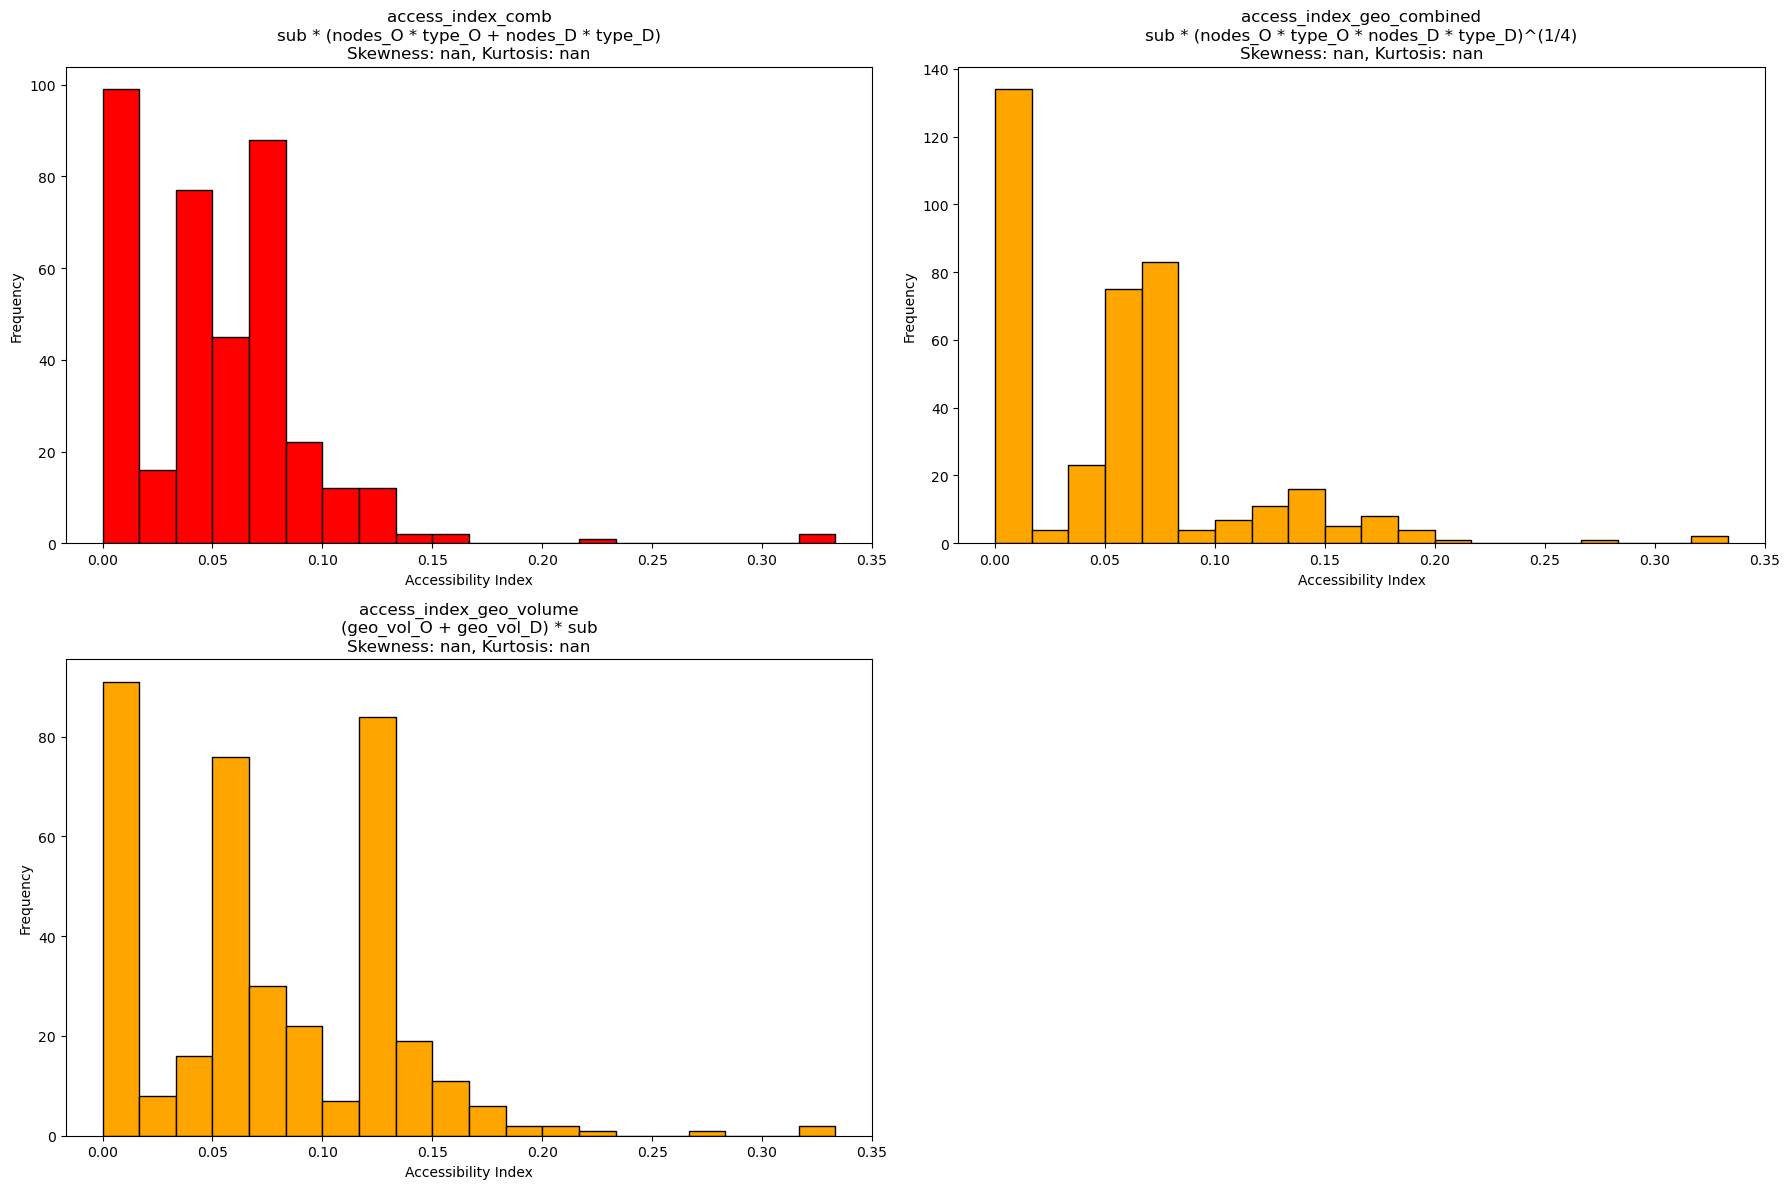

In [57]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt

# Initialize MinMaxScaler for normalization between 0 and 1/3
scaler = MinMaxScaler(feature_range=(0, 1/3))

# 1. Combined Node Types Approach (No Weights)
MOTILITY['access_index_comb'] = (
    MOTILITY['normalized_subscription'] *
    (MOTILITY['nor_nodes_O_count'] * MOTILITY['nor_nodes_O_type'] +
     MOTILITY['nor_nodes_D_count'] * MOTILITY['nor_nodes_D_type'])
)
MOTILITY['access_index_comb'] = scaler.fit_transform(MOTILITY[['access_index_comb']])

# 2. Geometric Mean-Based Combined Index (No Weights)
MOTILITY['access_index_geo_combined'] = MOTILITY['normalized_subscription'] * (
    MOTILITY['nor_nodes_O_count'] *
    MOTILITY['nor_nodes_O_type'] *
    MOTILITY['nor_nodes_D_count'] *
    MOTILITY['nor_nodes_D_type']
) ** (1/4)
MOTILITY['access_index_geo_combined'] = scaler.fit_transform(MOTILITY[['access_index_geo_combined']])

# 3. Geometric Volume-Based Index (No Weights)
MOTILITY['geo_volume_origin'] = (
    MOTILITY['nor_nodes_O_count'] * MOTILITY['nor_nodes_O_type']
) ** (1/2)

MOTILITY['geo_volume_destination'] = (
    MOTILITY['nor_nodes_D_count'] * MOTILITY['nor_nodes_D_type']
) ** (1/2)

MOTILITY['access_index_geo_volume'] = (
    (MOTILITY['geo_volume_origin'] + MOTILITY['geo_volume_destination']) *
    MOTILITY['normalized_subscription']
)
MOTILITY['access_index_geo_volume'] = scaler.fit_transform(MOTILITY[['access_index_geo_volume']])

# Methods to analyze and their formulas
methods = [
    ('access_index_comb', 'sub * (nodes_O * type_O + nodes_D * type_D)'),
    ('access_index_geo_combined', 'sub * (nodes_O * type_O * nodes_D * type_D)^(1/4)'),
    ('access_index_geo_volume', '(geo_vol_O + geo_vol_D) * sub')
]

# Calculate skewness and kurtosis for each method and prepare annotations
skewness_kurtosis = []
for method, _ in methods:
    skew_val = skew(MOTILITY[method])
    kurt_val = kurtosis(MOTILITY[method], fisher=True)
    skewness_kurtosis.append((method, skew_val, kurt_val))

# Identify the method with skewness and kurtosis closest to 0
best_method = min(skewness_kurtosis, key=lambda x: abs(x[1]) + abs(x[2]))

# Plot histograms with annotations for skewness and kurtosis
plt.figure(figsize=(18, 12))

for i, (method, formula) in enumerate(methods, 1):
    plt.subplot(2, 2, i)
    color = 'red' if method == best_method[0] else 'orange'
    plt.hist(MOTILITY[method], bins=20, edgecolor='black', color=color)
    skew_val, kurt_val = skew(MOTILITY[method]), kurtosis(MOTILITY[method], fisher=True)
    plt.title(f"{method}\n{formula}\nSkewness: {skew_val:.2f}, Kurtosis: {kurt_val:.2f}")
    plt.xlabel("Accessibility Index")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [58]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Initialize MinMaxScaler for normalization between 0 and 1/3
scaler = MinMaxScaler(feature_range=(0, 1/3))

# 1. Combined Node Types Approach (No Weights)
MOTILITY['access_index_comb'] = (
    MOTILITY['normalized_subscription'] *
    (MOTILITY['nor_nodes_O_count'] * MOTILITY['nor_nodes_O_type'] +
     MOTILITY['nor_nodes_D_count'] * MOTILITY['nor_nodes_D_type'])
)
MOTILITY['access_index_comb'] = scaler.fit_transform(MOTILITY[['access_index_comb']])

# 2. Geometric Mean-Based Combined Index (No Weights)
MOTILITY['access_index_geo_combined'] = MOTILITY['normalized_subscription'] * (
    MOTILITY['nor_nodes_O_count'] *
    MOTILITY['nor_nodes_O_type'] *
    MOTILITY['nor_nodes_D_count'] *
    MOTILITY['nor_nodes_D_type']
) ** (1/4)
MOTILITY['access_index_geo_combined'] = scaler.fit_transform(MOTILITY[['access_index_geo_combined']])

# 3. Geometric Volume-Based Index (No Weights)
MOTILITY['geo_volume_origin'] = (
    MOTILITY['nor_nodes_O_count'] * MOTILITY['nor_nodes_O_type']
) ** (1/2)

MOTILITY['geo_volume_destination'] = (
    MOTILITY['nor_nodes_D_count'] * MOTILITY['nor_nodes_D_type']
) ** (1/2)

MOTILITY['access_index_geo_volume'] = (
    (MOTILITY['geo_volume_origin'] + MOTILITY['geo_volume_destination']) *
    MOTILITY['normalized_subscription']
)
MOTILITY['access_index_geo_volume'] = scaler.fit_transform(MOTILITY[['access_index_geo_volume']])

# Methods to analyze and their formulas
methods = [
    ('access_index_comb', 'sub * (nodes_O * type_O + nodes_D * type_D)'),
    ('access_index_geo_combined', 'sub * (nodes_O * type_O * nodes_D * type_D)^(1/4)'),
    ('access_index_geo_volume', '(geo_vol_O + geo_vol_D) * sub')
]

# Calculate skewness and kurtosis for each method and prepare annotations
skewness_kurtosis = []
for method, _ in methods:
    skew_val = skew(MOTILITY[method])
    kurt_val = kurtosis(MOTILITY[method], fisher=True)
    skewness_kurtosis.append((method, skew_val, kurt_val))

# Save the plots and results as a PDF
with PdfPages("accessibility_analysis.pdf") as pdf:
    plt.figure(figsize=(18, 12))

    for i, (method, formula) in enumerate(methods, 1):
        plt.subplot(2, 2, i)
        plt.hist(MOTILITY[method], bins=20, edgecolor='black', color='orange')
        skew_val, kurt_val = skew(MOTILITY[method]), kurtosis(MOTILITY[method], fisher=True)
        plt.title(f"{method}\n{formula}\nSkewness: {skew_val:.2f}, Kurtosis: {kurt_val:.2f}")
        plt.xlabel("Accessibility Index")
        plt.ylabel("Frequency")

    plt.tight_layout()
    pdf.savefig()  # Save the current figure in the PDF
    plt.close()

    # Save skewness and kurtosis results as a table in the PDF
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.axis('tight')
    ax.axis('off')
    table_data = [['Method', 'Skewness', 'Kurtosis']] + [[m, f"{s:.2f}", f"{k:.2f}"] for m, s, k in skewness_kurtosis]
    table = ax.table(cellText=table_data, loc='center', cellLoc='center', colWidths=[0.2, 0.2, 0.2])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    pdf.savefig(fig)
    plt.close()


### 3.2.2 Skills (1/3)

#### 3.2.2.1 Shared Mobility

In [61]:
# Shared mobility accessbility counts half for skills 

In [62]:
min_sub = MOTILITY['How often do you use these shared mobility options on a weekly basis?'].min()
max_sub = MOTILITY['How often do you use these shared mobility options on a weekly basis?'].max()
MOTILITY['normalized_shared_mobility'] = (MOTILITY['How often do you use these shared mobility options on a weekly basis?'] - min_sub) / (max_sub - min_sub) * 0.5

#### 3.2.2.2 Smart Phone

In [64]:
#'Do you use your smartphone for commuting purposes?',
#'For what purpose do you use your smartphone?',

In [65]:
min_sub = MOTILITY['For what purpose do you use your smartphone?'].min()
max_sub = MOTILITY['For what purpose do you use your smartphone?'].max()
MOTILITY['normalized_mobile_phone'] = (MOTILITY['For what purpose do you use your smartphone?'] - min_sub) / (max_sub - min_sub) * 0.5

In [66]:
# Normalize a column to a target range
def normalize_to_range(column, target_min=0, target_max=1/3):
    col_min = column.min()
    col_max = column.max()
    # Avoid division by zero if col_min == col_max
    if col_max == col_min:
        return pd.Series(target_min, index=column.index)
    # Normalize using min-max scaling
    normalized = target_min + (column - col_min) * (target_max - target_min) / (col_max - col_min)
    return normalized

# Summing the motility skills
MOTILITY['n-skills_raw'] = MOTILITY.loc[:, 'normalized_shared_mobility':'normalized_mobile_phone'].sum(axis=1)

# Remap the values of n-skills to [0, 1/3]
MOTILITY['n-skills'] = normalize_to_range(MOTILITY['n-skills_raw'], target_min=0, target_max=1/3)

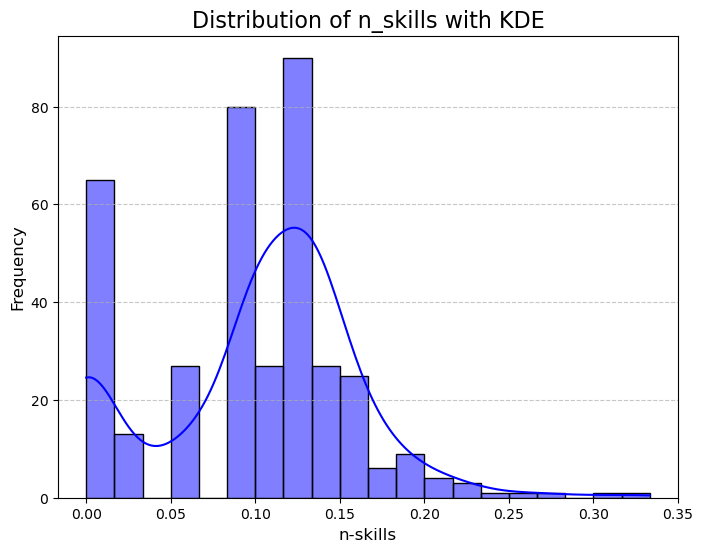

In [67]:
# Plot a histogram and KDE to visualize the skewness of the 'n_skills' column
plt.figure(figsize=(8, 6))
sns.histplot(MOTILITY['n-skills'], kde=True, bins=20, color='blue', edgecolor='black')
plt.title('Distribution of n_skills with KDE', fontsize=16)
plt.xlabel('n-skills', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 3.2.3 Appropriation (1/3)

#### 3.2.3.1 Modal Preferences 

In [70]:
# check first for the top 3 public transport options. the options can be categorized into 3 main parts 
# Public Transport, Active mobility, Private cars.
# The main thing is to measure variations, so the best score is when users use the 3 categories, and the owest is when people pick from 
# one option.

In [71]:
import pandas as pd

# Define transport categories
public_transport = {'Train', 'Metro', 'Tram', 'Bus'}
active_shared_mobility = {
    'Personal Bike',
    'Bike Sharing',
    'Scooter',
    'Shared Car',
    'I just walk'
}
private_car = {'Private Car'}

# Function to calculate diversity score
def calculate_diversity(row):
    # Split user responses into a set of unique options
    selected_options = set(row.split(','))
    
    # Check which categories are included
    categories = set()
    if selected_options & public_transport:
        categories.add('public_transport')
    if selected_options & active_shared_mobility:
        categories.add('active_shared_mobility')
    if selected_options & private_car:
        categories.add('private_car')
    
    # Return the diversity score based on the number of categories
    return len(categories)

# Example column name
column_name = 'Rank the most used means of transport you use! (Drag and drop the three most used). - Groups - Drag and drop the most used of transport options in order here'

# Preprocess the column to simplify Bike Sharing option
MOTILITY[column_name] = MOTILITY[column_name].str.replace(
    'Bike Sharing (BikeMi, Lime, RideMovi...)', 'Bike Sharing'
)

# Apply the function to the column
MOTILITY['Diversity Score'] = MOTILITY[column_name].apply(calculate_diversity)


#### 3.2.3.2 Attittudes towards the future

In [73]:
# Create the new column `attitudes` as the product of the two columns
MOTILITY['attitudes'] = (
    MOTILITY['To which extent you are willing to change your mobility behaviour?'] *
    MOTILITY['What stimulate you to change your mobility behavior? - Selected Choice']
)

In [74]:
# Normalize a column to a target range
def normalize_to_range(column, target_min=0, target_max=0.5):
    col_min = column.min()
    col_max = column.max()
    # Avoid division by zero if col_min == col_max
    if col_max == col_min:
        return pd.Series(target_min, index=column.index)
    # Normalize using min-max scaling
    normalized = target_min + (column - col_min) * (target_max - target_min) / (col_max - col_min)
    return normalized

# Normalize Diversity Score to [0, 0.5]
MOTILITY['normalized_diversity_score'] = normalize_to_range(MOTILITY['Diversity Score'])

# Normalize attitudes to [0, 0.5]
MOTILITY['normalized_attitudes'] = normalize_to_range(MOTILITY['attitudes'])

# Create n-appropriation by summing the two normalized columns
MOTILITY['n-appropriation_raw'] = MOTILITY['normalized_diversity_score'] + MOTILITY['normalized_attitudes']

# Normalize n-appropriation to [0, 1/3]
MOTILITY['n-appropriation'] = normalize_to_range(MOTILITY['n-appropriation_raw'], target_min=0, target_max=1/3)

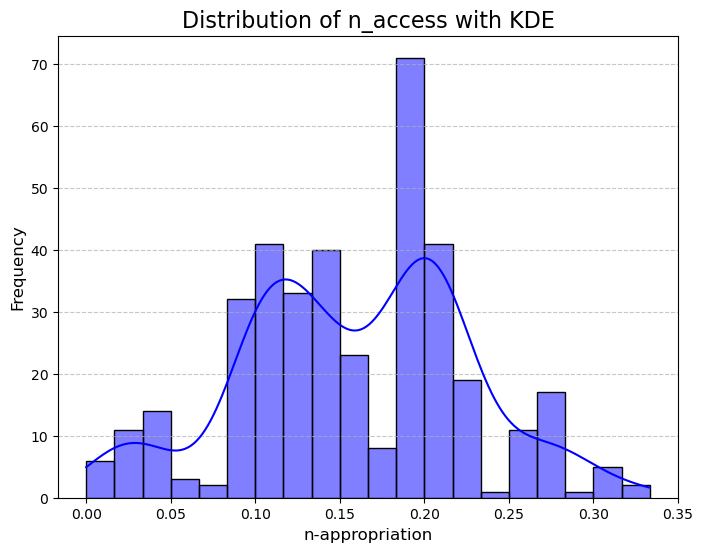

In [75]:
# Plot a histogram and KDE to visualize the skewness of the 'n_access' column
plt.figure(figsize=(8, 6))
sns.histplot(MOTILITY['n-appropriation'], kde=True, bins=20, color='blue', edgecolor='black')
plt.title('Distribution of n_access with KDE', fontsize=16)
plt.xlabel('n-appropriation', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 3.2 Calculaing Motility Index

In [77]:
# Create n-appropriation by summing the two normalized columns
MOTILITY['MOTILITY'] = MOTILITY['access_index_geo_volume'] + MOTILITY['n-skills'] + MOTILITY ['n-appropriation']

In [78]:
# Calculate mean and standard deviation
mean_motility = MOTILITY['MOTILITY'].mean()
std_motility = MOTILITY['MOTILITY'].std()

# Calculate the z-score manually
MOTILITY['Multimotility_zScore'] = (MOTILITY['MOTILITY'] - mean_motility) / std_motility

# Display the first few rows to verify
print(MOTILITY[['MOTILITY', 'Multimotility_zScore']].head())


   MOTILITY  Multimotility_zScore
0  0.141955             -1.732001
1  0.110000             -2.018535
2  0.249270             -0.769720
3  0.103333             -2.078315
4  0.241953             -0.835328


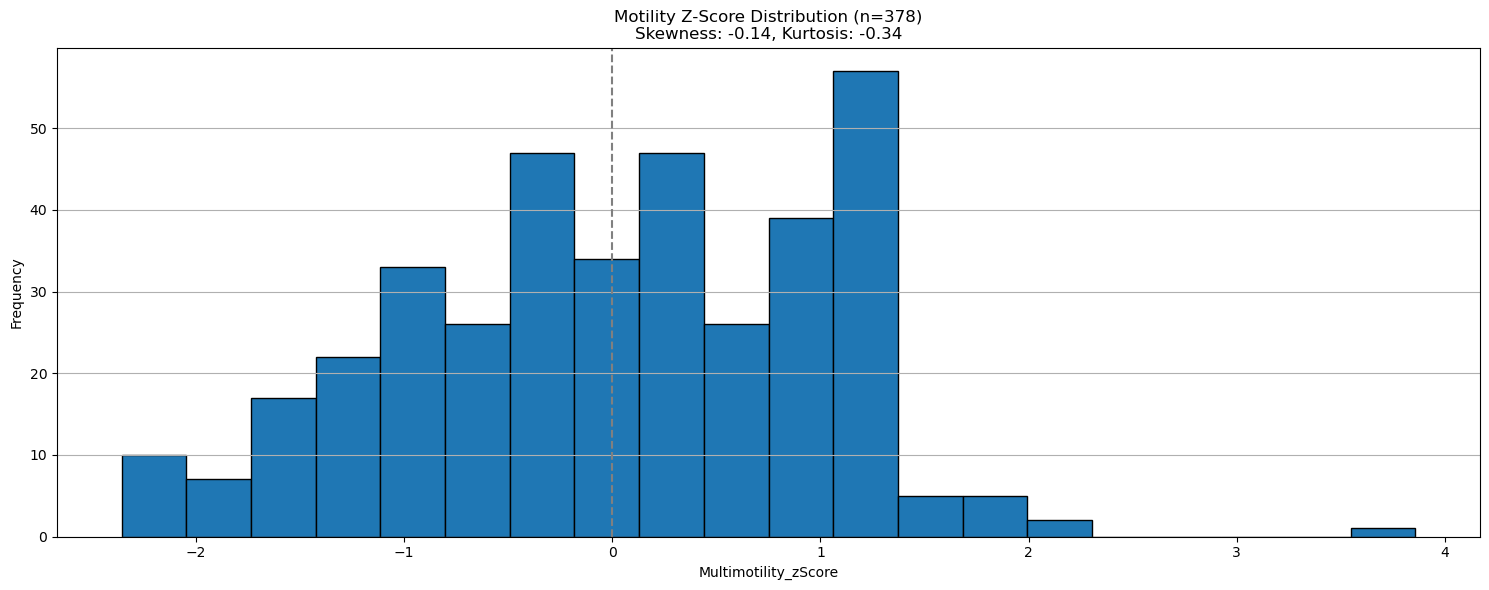

In [79]:
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import numpy as np

# Calculate skewness and kurtosis for 'Multimodality_zScore'
MOTILITY_skew = skew(MOTILITY['Multimotility_zScore'].dropna())
MOTILITY_kurtosis = kurtosis(MOTILITY['Multimotility_zScore'].dropna(), fisher=True)

# Number of values
n = len(MOTILITY['Multimotility_zScore'].dropna())

# Plot histogram with z-score details
plt.figure(figsize=(15, 6))
plt.hist(MOTILITY['Multimotility_zScore'].dropna(), bins=20, edgecolor='black')

# Add a gray hashed line for z = 0
plt.axvline(0, color='gray', linestyle='--', linewidth=1.5)

# Add title with skewness, kurtosis, and n
plt.title(f"Motility Z-Score Distribution (n={n})\nSkewness: {MOTILITY_skew:.2f}, Kurtosis: {MOTILITY_kurtosis:.2f}")
plt.xlabel("Multimotility_zScore")
plt.ylabel("Frequency")
plt.grid(axis='y')

# Adjust layout
plt.tight_layout()

# Save plot as PDF
plt.savefig("mMultimotility_zScore_distribution.pdf")

# Show the plot
plt.show()

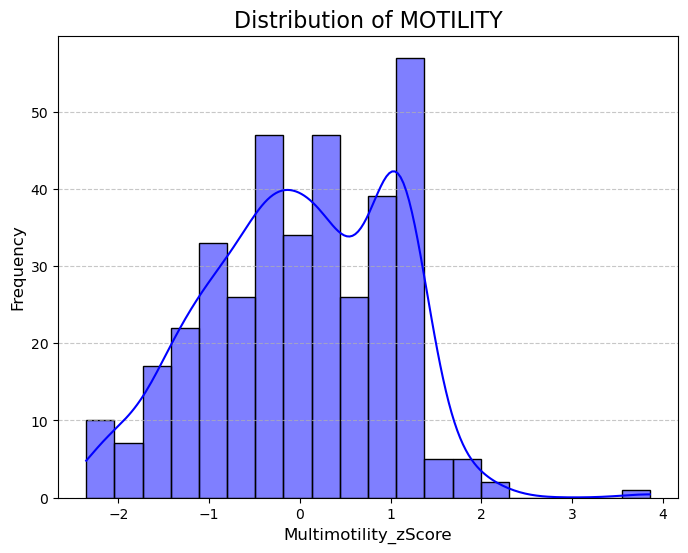

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(MOTILITY['Multimotility_zScore'], kde=True, bins=20, color='blue', edgecolor='black')
plt.title('Distribution of MOTILITY', fontsize=16)
plt.xlabel('Multimotility_zScore', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save the plot as a PDF file
plt.savefig('motility_distribution.pdf', format='pdf', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [81]:
# As summing the 3 indicators of Motility doesn't sum to 1, I need to distribute the values from 0 to 1 
# Initialize MinMaxScaler for normalization to [0, 1]
#scaler = MinMaxScaler(feature_range=(0, 1))

# Normalize the 'MOTILITY' column
#MOTILITY['MOTILITY'] = scaler.fit_transform(MOTILITY[['MOTILITY']])

# Display the first few rows to verify the normalization
#print(MOTILITY[['access_index_geo_volume', 'n-skills', 'n-appropriation', 'MOTILITY']].head())

### Calculating PT and Destination 

# 4.0 Plotting Motility with Multimodality

In [84]:
MMI_unique = MMI[['Response ID', 'Multimodality_zScore']].drop_duplicates(subset='Response ID')
MOTILITY_unique = MOTILITY[['Response ID', 'Multimotility_zScore']].drop_duplicates(subset='Response ID')

In [85]:
# Merge the two datasets on the 'Response ID' column
merged_dataset = pd.merge(
    MMI_unique,  # MMI with unique Response IDs
    MOTILITY_unique,  # MOTILITY with unique Response IDs
    on='Response ID',  # Merge on the common column
    how='inner'  # Perform an inner join to include only matching Response IDs
)

In [86]:
merged_dataset.to_csv('test.csv',index=False)

In [87]:
merged_dataset.info()
merged_dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308 entries, 0 to 307
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Response ID           308 non-null    object 
 1   Multimodality_zScore  308 non-null    float64
 2   Multimotility_zScore  306 non-null    float64
dtypes: float64(2), object(1)
memory usage: 7.3+ KB


Response ID  Multimodality_zScore  Multimotility_zScore
0    R_6JmlJEGCOWo9rTX              0.017263             -1.732001
1    R_61z5R1KEmMv8GGz             -0.170327             -2.018535
2    R_2QS9J3nCE9mYu8B              0.017263             -0.769720
3    R_2JlKjQUhcT7unUa             -0.374319             -2.078315
4    R_6IoBWPSrHaPVS7I              0.017263             -0.835328
..                 ...                   ...                   ...
303  R_2sogfeczO00yYvM             -1.340959             -1.028991
304  R_81Af79F72aaAUsT              1.064749              0.267545
305  R_82S6xK8Q8m0Ceye              0.017263              2.018871
306  R_27pz8nRKYyJZW8h              1.064749             -0.392679
307  R_2q41Zzco1HRd92q              1.190272             -0.376574

[308 rows x 3 columns]

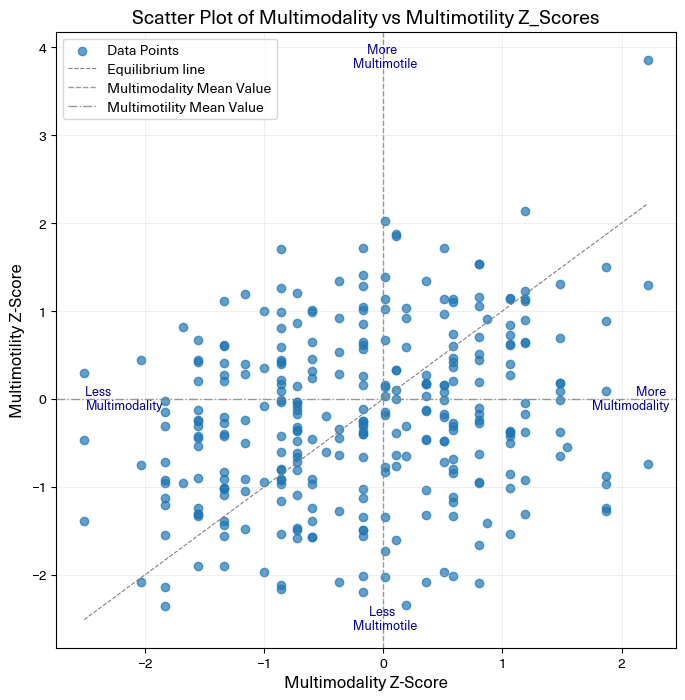

In [88]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# Set the font to Neue Haas Unica
mpl.rcParams['font.family'] = 'Neue Haas Unica'

# Create the figure
plt.figure(figsize=(8, 8))

# Scatter plot of Multimodality_zScore vs Multimotility_zScore
plt.scatter(merged_dataset['Multimodality_zScore'], merged_dataset['Multimotility_zScore'], 
            alpha=0.7, label='Data Points')

# Add a line where x = y
x = np.linspace(min(merged_dataset['Multimodality_zScore']), max(merged_dataset['Multimodality_zScore']), 100)
plt.plot(x, x, color='gray', linestyle='--', linewidth=0.8, label='Equilibrium line')  # Diagonal line

# Highlight the importance of zero by adding horizontal and vertical lines at 0
plt.axvline(0, color='gray', linestyle='--', alpha=0.8, linewidth=1, label='Multimodality Mean Value')
plt.axhline(0, color='gray', linestyle='-.', linewidth=1, alpha=0.8, label='Multimotility Mean Value')

# Add labels, title, and legend
plt.title('Scatter Plot of Multimodality vs Multimotility Z_Scores', fontsize=14)
plt.xlabel('Multimodality Z-Score', fontsize=12)
plt.ylabel('Multimotility Z-Score', fontsize=12)
plt.legend()

# Add grid for better readability
plt.grid(alpha=0.2)

# Add annotations
plt.text(2.4, 0, 'More \n Multimodality', fontsize=9, color='darkblue', ha='right', va='center')
plt.text(-2.5, 0, 'Less \nMultimodality', fontsize=9, color='darkblue', ha='left', va='center')
plt.text(0, 3.9, 'More \n Multimotile', fontsize=9, color='darkblue', ha='center', va='center')
plt.text(0, -2.5, 'Less \n Multimotile', fontsize=9, color='darkblue', ha='center', va='center')

# Save the plot as a PDF with the desired name
plt.savefig('scattered_results_primarly.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


# 5.0 Interpertations of the values 

In [90]:
# Select 'Response ID', 'distance', and 'CAP_Location' from merged_data
merged_subset = merged_data[['Response ID', 'distance', 'CAP_Location']]

# Merge the selected columns into merged_dataset based on 'Response ID'
merged_dataset = merged_dataset.merge(merged_subset, on='Response ID', how='left')

# Display the updated merged_dataset
merged_dataset


Response ID  Multimodality_zScore  Multimotility_zScore  \
0    R_6JmlJEGCOWo9rTX              0.017263             -1.732001   
1    R_61z5R1KEmMv8GGz             -0.170327             -2.018535   
2    R_2QS9J3nCE9mYu8B              0.017263             -0.769720   
3    R_2JlKjQUhcT7unUa             -0.374319             -2.078315   
4    R_6IoBWPSrHaPVS7I              0.017263             -0.835328   
..                 ...                   ...                   ...   
376  R_2sogfeczO00yYvM             -1.340959             -1.028991   
377  R_81Af79F72aaAUsT              1.064749              0.267545   
378  R_82S6xK8Q8m0Ceye              0.017263              2.018871   
379  R_27pz8nRKYyJZW8h              1.064749             -0.392679   
380  R_2q41Zzco1HRd92q              1.190272             -0.376574   

       distance                   CAP_Location  
0     15.044886            In Lombardia Region  
1     20.372493            In Lombardia Region  
2      2.424350                       In Milan  
3    117.914526    Outside of Lombardia Region  
4      2.424350                       In Milan  
..          ...                            ...  
376    1.169644                       In Milan  
377   33.513502            In Lombardia Region  
378    2.452124                       In Milan  
379   34.655301  In Metropolitan area of Milan  
380    9.237931                       In Milan  

[381 rows x 5 columns]

## 5.1 Distance

### 5.1.1 Linear distance 

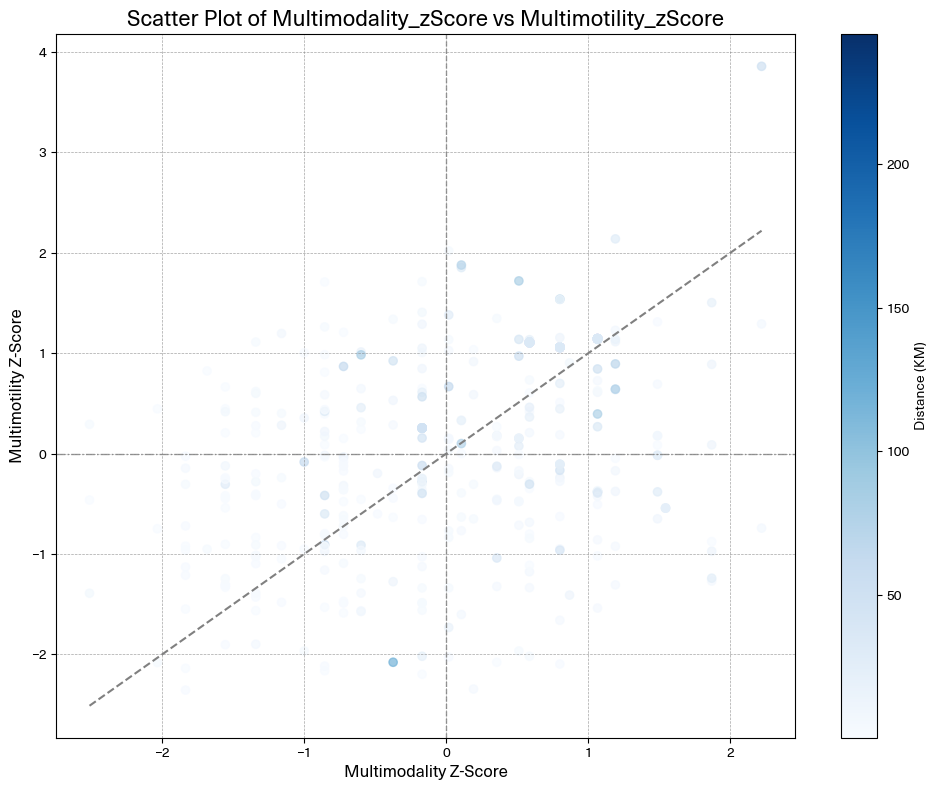

In [93]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib.colors import Normalize

# Set the font to Neue Haas Unica
mpl.rcParams['font.family'] = 'Neue Haas Unica'

# Discretize the distance into continuous values and normalize
norm = Normalize(vmin=merged_dataset['distance'].min(), vmax=merged_dataset['distance'].max())
cmap = mpl.cm.Blues

# Map distance to a color gradient
scatter_colors = cmap(norm(merged_dataset['distance']))

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 8))

# Scatter plot of Multimodality_zScore vs Multimotility_zScore
scatter = ax.scatter(
    merged_dataset['Multimodality_zScore'],
    merged_dataset['Multimotility_zScore'],
    c=scatter_colors,
    alpha=0.7
)

# Add a line where x = y
x = np.linspace(min(merged_dataset['Multimodality_zScore']), max(merged_dataset['Multimodality_zScore']), 100)
ax.plot(x, x, color='gray', linestyle='--', label='Equilibrium line')  # Diagonal line

# Highlight the importance of zero by adding horizontal and vertical lines at 0
ax.axvline(0, color='gray', linestyle='--', alpha=0.8, linewidth=1, label='Multimodality Mean Value')
ax.axhline(0, color='gray', linestyle='-.', linewidth=1, alpha=0.8, label='Multimotility Mean Value')

# Add a grid to the plot
ax.grid(which='major', color='gray', linestyle='--', linewidth=0.5, alpha=0.7)  # Customize grid appearance

# Add labels, title, and legend
ax.set_title('Scatter Plot of Multimodality_zScore vs Multimotility_zScore', fontsize=16)
ax.set_xlabel('Multimodality Z-Score', fontsize=12)
ax.set_ylabel('Multimotility Z-Score', fontsize=12)

# Add a colorbar to represent the distance gradient
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', label='Distance (KM)')

# Adjust layout to prevent clipping of legend and title
plt.tight_layout()

# Save the plot as a PDF
plt.savefig('scatter_plot_with_grid.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


### 5.1.2 Distance Categorized based on K-Means clustering 

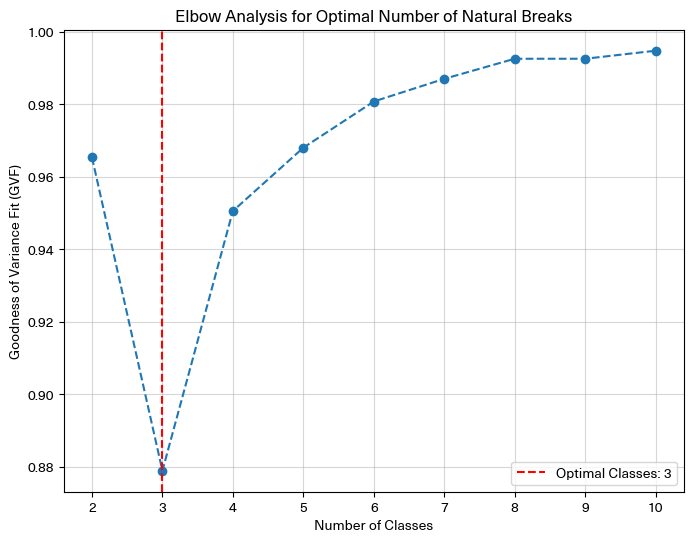

In [95]:
import matplotlib.pyplot as plt
import numpy as np
import jenkspy

# Assume 'merged_dataset' is your DataFrame containing the 'distance' column
distance_data = merged_dataset['distance'].values

# Define a range of possible classes (e.g., from 2 to 10)
possible_classes = range(2, 11)

# Calculate goodness of variance fit (GVF) for each number of classes
gvfs = []

for n in possible_classes:
    breaks = jenkspy.jenks_breaks(distance_data, n_classes=n)
    clustered = np.digitize(distance_data, bins=breaks, right=True)
    
    # Calculate the goodness of variance fit (GVF)
    sdam = np.sum((distance_data - np.mean(distance_data)) ** 2)
    sdcm = sum([np.sum((distance_data[clustered == i] - np.mean(distance_data[clustered == i])) ** 2) for i in range(n)])
    gvf = (sdam - sdcm) / sdam
    gvfs.append(gvf)

# Plot the Elbow curve
plt.figure(figsize=(8, 6))
plt.plot(possible_classes, gvfs, marker='o', linestyle='--')
plt.title('Elbow Analysis for Optimal Number of Natural Breaks')
plt.xlabel('Number of Classes')
plt.ylabel('Goodness of Variance Fit (GVF)')
plt.grid(alpha=0.5)

# Highlight the elbow point (optional)
optimal_n = possible_classes[np.argmax(np.diff(gvfs))]
plt.axvline(optimal_n, color='red', linestyle='--', label=f'Optimal Classes: {optimal_n}')

plt.legend()
plt.show()


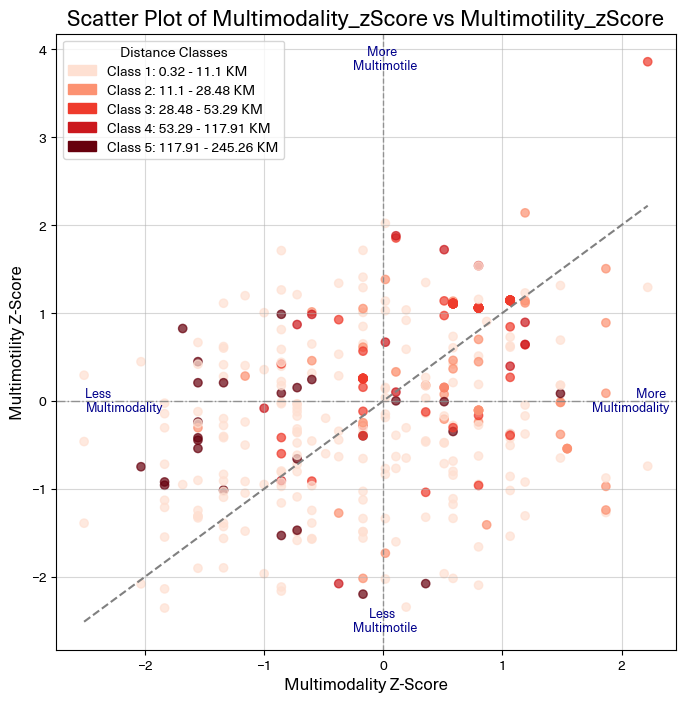

In [96]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import jenkspy  # For Natural Breaks classification

# Assume 'merged_dataset' is your DataFrame containing the 'distance' column

# Calculate Natural Breaks (Jenks) for the 'distance' column
breaks = jenkspy.jenks_breaks(merged_dataset['distance'], n_classes=5)

# Create a new column to classify 'distance' based on Natural Breaks
merged_dataset['distance_class'] = np.digitize(merged_dataset['distance'], bins=breaks, right=True)

# Set up distinct colors for each class
colors = ['#fee0d2', '#fc9272', '#ef3b2c', '#cb181d', '#67000d']

# Set the font to Neue Haas Unica
mpl.rcParams['font.family'] = 'Neue Haas Unica'

# Create the figure
plt.figure(figsize=(8, 8))

# Scatter plot of Multimodality_zScore vs Multimotility_zScore with color based on 'distance_class'
scatter = plt.scatter(
    merged_dataset['Multimodality_zScore'],
    merged_dataset['Multimotility_zScore'],
    c=[colors[i - 1] for i in merged_dataset['distance_class']],  # Assign color by class
    alpha=0.7
)

# Add a custom legend for the Natural Breaks
import matplotlib.patches as mpatches

# Format breaks and include "KM" only once
legend_patches = [
    mpatches.Patch(color=colors[i], 
                   label=f'Class {i + 1}: {round(breaks[i], 2)} - {round(breaks[i + 1], 2)} KM')
    for i in range(len(breaks) - 1)
]

plt.legend(handles=legend_patches, title='Distance Classes', fontsize=10, loc='upper left')

# Add a line where x = y
x = np.linspace(min(merged_dataset['Multimodality_zScore']), max(merged_dataset['Multimodality_zScore']), 100)
plt.plot(x, x, color='gray', linestyle='--', label='Equilibrium line')  # Diagonal line

# Highlight the importance of zero by adding horizontal and vertical lines at 0
plt.axvline(0, color='gray', linestyle='--', alpha=0.8, linewidth=1, label='Multimodality Mean Value')
plt.axhline(0, color='gray', linestyle='-.', linewidth=1, alpha=0.8, label='Multimotility Mean Value')

# Add labels, title, and legend
plt.title('Scatter Plot of Multimodality_zScore vs Multimotility_zScore', fontsize=16)
plt.xlabel('Multimodality Z-Score', fontsize=12)
plt.ylabel('Multimotility Z-Score', fontsize=12)

# Add grid for better readability
plt.grid(alpha=0.5)

# Add annotations
plt.text(2.4, 0, 'More \n Multimodality', fontsize=9, color='darkblue', ha='right', va='center')
plt.text(-2.5, 0, 'Less \nMultimodality', fontsize=9, color='darkblue', ha='left', va='center')
plt.text(0, 3.9, 'More \n Multimotile', fontsize=9, color='darkblue', ha='center', va='center')
plt.text(0, -2.5, 'Less \n Multimotile', fontsize=9, color='darkblue', ha='center', va='center')

# Save the plot as a PDF
plt.savefig('scatter_plot_natural_breaks_distance.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


### 5.1.3 Distance Grouped by CAPS

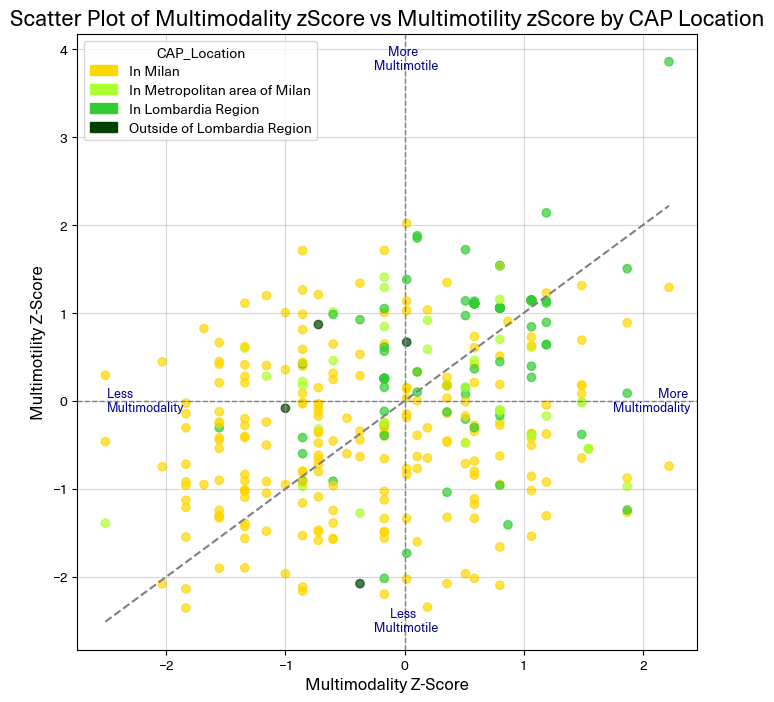

In [98]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Define the ranking for CAP_Location
cap_location_mapping = {
    'In Milan': 1,
    'In Metropolitan area of Milan': 2,
    'In Lombardia Region': 3,
    'Outside of Lombardia Region': 4
}

# Map CAP_Location to numeric values
merged_dataset['CAP_Rank'] = merged_dataset['CAP_Location'].map(cap_location_mapping)

# Define the yellow-to-green color mapping for each category
color_mapping = {
    'In Milan': '#FFD700',                        # Bright Yellow
    'In Metropolitan area of Milan': '#ADFF2F',   # Yellow-Green
    'In Lombardia Region': '#32CD32',              # Lime Green
    'Outside of Lombardia Region': '#004000'       # Very Dark Green
}

# Assign colors to each point based on CAP_Location
colors = merged_dataset['CAP_Location'].map(color_mapping)

# Create the figure
plt.figure(figsize=(8, 8))

# Scatter plot of Multimodality_zScore vs Multimotility_zScore with color based on CAP_Location
plt.scatter(
    merged_dataset['Multimodality_zScore'],
    merged_dataset['Multimotility_zScore'],
    c=colors,
    alpha=0.7
)

# Add a line where x = y
x = np.linspace(min(merged_dataset['Multimodality_zScore']), max(merged_dataset['Multimodality_zScore']), 100)
plt.plot(x, x, color='gray', linestyle='--', label='x = y')  # Diagonal line

# Highlight the importance of zero by adding horizontal and vertical lines at 0
plt.axvline(0, color='gray', linestyle='--', linewidth=1, label='Multimodality_zScore = 0')
plt.axhline(0, color='gray', linestyle='--', linewidth=1, label='Multimotility_zScore = 0')

# Create a legend with colored patches for each CAP_Location category
legend_patches = [
    mpatches.Patch(color=color_mapping['In Milan'], label='In Milan'),
    mpatches.Patch(color=color_mapping['In Metropolitan area of Milan'], label='In Metropolitan area of Milan'),
    mpatches.Patch(color=color_mapping['In Lombardia Region'], label='In Lombardia Region'),
    mpatches.Patch(color=color_mapping['Outside of Lombardia Region'], label='Outside of Lombardia Region')
]
plt.legend(handles=legend_patches, title='CAP_Location', loc='upper left')

# Add labels and title
plt.title('Scatter Plot of Multimodality zScore vs Multimotility zScore by CAP Location', fontsize=16)
plt.xlabel('Multimodality Z-Score', fontsize=12)
plt.ylabel('Multimotility Z-Score', fontsize=12)

# Add annotations
plt.text(2.4, 0, 'More \n Multimodality', fontsize=9, color='darkblue', ha='right', va='center')
plt.text(-2.5, 0, 'Less \nMultimodality', fontsize=9, color='darkblue', ha='left', va='center')
plt.text(0, 3.9, 'More \n Multimotile', fontsize=9, color='darkblue', ha='center', va='center')
plt.text(0, -2.5, 'Less \n Multimotile', fontsize=9, color='darkblue', ha='center', va='center')

# Add grid for better readability
plt.grid(alpha=0.5)

# Save the plot as a PDF
plt.savefig('scatter_plot_CAP_Location_yellow_green.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


## 5.2 Gender

In [100]:
import pandas as pd

# Create a new DataFrame with Response ID and Gender columns
gender_data = filtered_data[['Response ID', 'How do you identify yourself? - Selected Choice']]

# Rename the gender column for easier reference
gender_data.rename(columns={'How do you identify yourself? - Selected Choice': 'Gender'}, inplace=True)

# Merge the gender_data into merged_dataset using 'Response ID' as the key
merged_dataset = merged_dataset.merge(gender_data, on='Response ID', how='left')
merged_dataset

C:\Users\mafgo\AppData\Local\Temp\ipykernel_9204\1973285235.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gender_data.rename(columns={'How do you identify yourself? - Selected Choice': 'Gender'}, inplace=True)


Response ID  Multimodality_zScore  Multimotility_zScore  \
0    R_6JmlJEGCOWo9rTX              0.017263             -1.732001   
1    R_61z5R1KEmMv8GGz             -0.170327             -2.018535   
2    R_2QS9J3nCE9mYu8B              0.017263             -0.769720   
3    R_2JlKjQUhcT7unUa             -0.374319             -2.078315   
4    R_6IoBWPSrHaPVS7I              0.017263             -0.835328   
..                 ...                   ...                   ...   
376  R_2sogfeczO00yYvM             -1.340959             -1.028991   
377  R_81Af79F72aaAUsT              1.064749              0.267545   
378  R_82S6xK8Q8m0Ceye              0.017263              2.018871   
379  R_27pz8nRKYyJZW8h              1.064749             -0.392679   
380  R_2q41Zzco1HRd92q              1.190272             -0.376574   

       distance                   CAP_Location  distance_class  CAP_Rank  \
0     15.044886            In Lombardia Region               2         3   
1     20.372493            In Lombardia Region               2         3   
2      2.424350                       In Milan               1         1   
3    117.914526    Outside of Lombardia Region               4         4   
4      2.424350                       In Milan               1         1   
..          ...                            ...             ...       ...   
376    1.169644                       In Milan               1         1   
377   33.513502            In Lombardia Region               3         3   
378    2.452124                       In Milan               1         1   
379   34.655301  In Metropolitan area of Milan               3         2   
380    9.237931                       In Milan               1         1   

     Gender  
0    Female  
1    Female  
2      Male  
3      Male  
4      Male  
..      ...  
376  Female  
377    Male  
378  Female  
379    Male  
380    Male  

[381 rows x 8 columns]

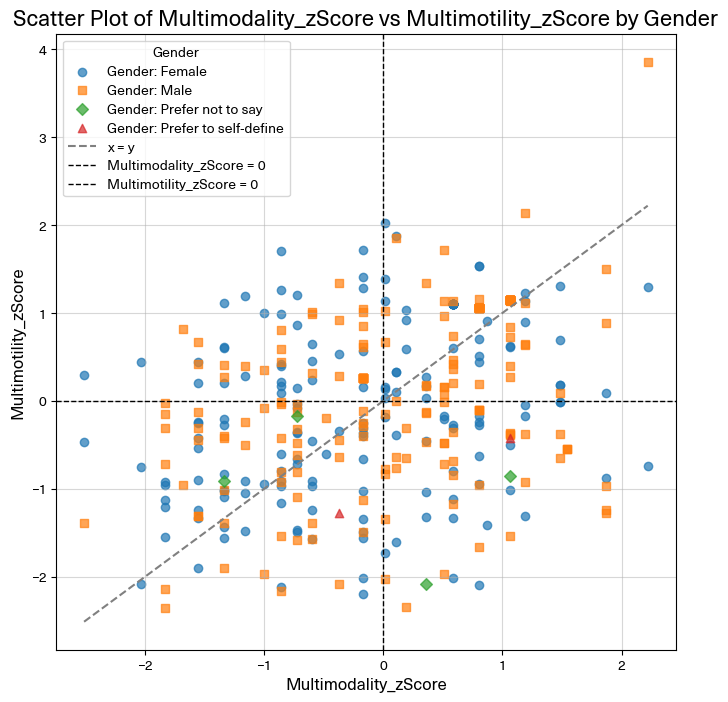

In [101]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Ensure Gender is a categorical variable
merged_dataset['Gender'] = merged_dataset['Gender'].astype('category')

# Define unique colors and markers for each gender category
gender_colors = {'Female': '#1f77b4', 'Male': '#ff7f0e', 'Prefer not to say': '#2ca02c', 'Prefer to self-define': '#d62728', np.nan: '#7f7f7f'}
gender_markers = {'Female': 'o', 'Male': 's', 'Prefer not to say': 'D', 'Prefer to self-define': '^', np.nan: 'x'}

# Create the figure
plt.figure(figsize=(8, 8))

# Loop through each gender category and plot separately
for gender in merged_dataset['Gender'].unique():
    subset = merged_dataset[merged_dataset['Gender'] == gender]
    plt.scatter(
        subset['Multimodality_zScore'],
        subset['Multimotility_zScore'],
        color=gender_colors.get(gender, '#7f7f7f'),
        marker=gender_markers.get(gender, 'o'),
        label=f'Gender: {gender}',
        alpha=0.7
    )

# Add a line where x = y
x = np.linspace(min(merged_dataset['Multimodality_zScore']), max(merged_dataset['Multimodality_zScore']), 100)
plt.plot(x, x, color='gray', linestyle='--', label='x = y')  # Diagonal line

# Highlight the importance of zero by adding horizontal and vertical lines at 0
plt.axvline(0, color='black', linestyle='--', linewidth=1, label='Multimodality_zScore = 0')
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Multimotility_zScore = 0')

# Add labels, title, and legend
plt.title('Scatter Plot of Multimodality_zScore vs Multimotility_zScore by Gender', fontsize=16)
plt.xlabel('Multimodality_zScore', fontsize=12)
plt.ylabel('Multimotility_zScore', fontsize=12)
plt.legend(title='Gender', fontsize=10)

# Add grid for better readability
plt.grid(alpha=0.5)

# Save the plot as a PDF
output_path = r"D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\people\py_out\scatter_plot_by_gender.pdf"
plt.savefig(output_path, format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


## 5.3 Transfer Time

In [103]:
# Select 'Response ID', 'distance', and 'CAP_Location' from merged_data
merged_subset = MMI[['Response ID', 'transfer']]

# Merge the selected columns into merged_dataset based on 'Response ID'
merged_dataset = merged_dataset.merge(merged_subset, on='Response ID', how='left')

# Display the updated merged_dataset
merged_dataset


Response ID  Multimodality_zScore  Multimotility_zScore  \
0     R_6JmlJEGCOWo9rTX              0.017263             -1.732001   
1     R_61z5R1KEmMv8GGz             -0.170327             -2.018535   
2     R_2QS9J3nCE9mYu8B              0.017263             -0.769720   
3     R_2JlKjQUhcT7unUa             -0.374319             -2.078315   
4     R_6IoBWPSrHaPVS7I              0.017263             -0.835328   
...                 ...                   ...                   ...   
1628  R_2sogfeczO00yYvM             -1.340959             -1.028991   
1629  R_81Af79F72aaAUsT              1.064749              0.267545   
1630  R_82S6xK8Q8m0Ceye              0.017263              2.018871   
1631  R_27pz8nRKYyJZW8h              1.064749             -0.392679   
1632  R_2q41Zzco1HRd92q              1.190272             -0.376574   

        distance                   CAP_Location  distance_class  CAP_Rank  \
0      15.044886            In Lombardia Region               2         3   
1      20.372493            In Lombardia Region               2         3   
2       2.424350                       In Milan               1         1   
3     117.914526    Outside of Lombardia Region               4         4   
4       2.424350                       In Milan               1         1   
...          ...                            ...             ...       ...   
1628    1.169644                       In Milan               1         1   
1629   33.513502            In Lombardia Region               3         3   
1630    2.452124                       In Milan               1         1   
1631   34.655301  In Metropolitan area of Milan               3         2   
1632    9.237931                       In Milan               1         1   

      Gender  transfer  
0     Female       0.0  
1     Female       0.0  
2       Male       0.0  
3       Male       0.0  
4       Male       0.0  
...      ...       ...  
1628  Female      25.0  
1629    Male      20.0  
1630  Female      20.0  
1631    Male      15.0  
1632    Male       7.0  

[1633 rows x 9 columns]

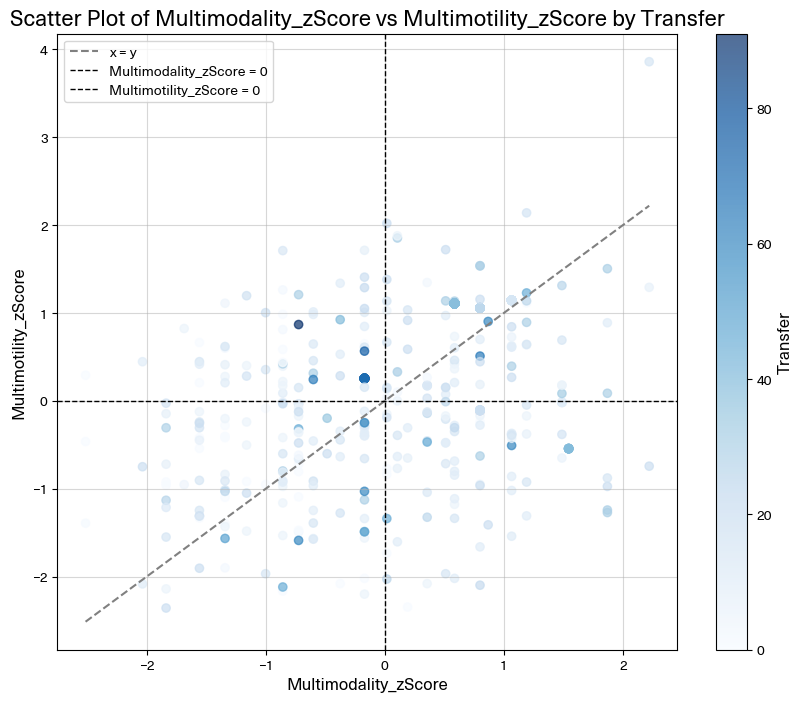

In [104]:
import matplotlib.pyplot as plt
import numpy as np

# Create the figure
plt.figure(figsize=(10, 8))

# Scatter plot of Multimodality_zScore vs Multimotility_zScore with color based on 'transfer'
scatter = plt.scatter(
    merged_dataset['Multimodality_zScore'],
    merged_dataset['Multimotility_zScore'],
    c=merged_dataset['transfer'],        # Color based on 'transfer'
    cmap='Blues',                        # Colormap for blue shades
    alpha=0.7
    # Removed edgecolor parameter to eliminate the stroke
)

# Add a color bar to indicate the transfer scale
cbar = plt.colorbar(scatter)
cbar.set_label('Transfer', fontsize=12)

# Add a line where x = y
x = np.linspace(min(merged_dataset['Multimodality_zScore']), max(merged_dataset['Multimodality_zScore']), 100)
plt.plot(x, x, color='gray', linestyle='--', label='x = y')  # Diagonal line

# Highlight the importance of zero by adding horizontal and vertical lines at 0
plt.axvline(0, color='black', linestyle='--', linewidth=1, label='Multimodality_zScore = 0')
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Multimotility_zScore = 0')

# Add labels, title, and legend
plt.title('Scatter Plot of Multimodality_zScore vs Multimotility_zScore by Transfer', fontsize=16)
plt.xlabel('Multimodality_zScore', fontsize=12)
plt.ylabel('Multimotility_zScore', fontsize=12)
plt.legend()

# Add grid for better readability
plt.grid(alpha=0.5)

# Save the plot as a PDF
plt.savefig('scatter_plot_transfer_colored.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


## 5.4 Age

In [106]:
# Drop duplicates in filtered_data based on 'Response ID'
filtered_subset = filtered_data[['Response ID', 'How old are you? - years',
                                 'In one word, describe the walking path you take to the work / university / school / other?  (e.g., stressful, enjoyable, busy....)','How many minutes does it take your trip from Home to School / University / Work / Other?  And, how many minutes do you spend to transfer (walk and wait)  during your trip from Home to School / University / Work / Other? - Total trip time in minutes']].drop_duplicates(subset='Response ID')

# Drop duplicates in merged_dataset based on 'Response ID'
merged_dataset = merged_dataset.drop_duplicates(subset='Response ID')

# Merge the deduplicated filtered_subset into merged_dataset
merged_dataset = merged_dataset.merge(filtered_subset, on='Response ID', how='left')

In [107]:
# Rename the specified columns
merged_dataset = merged_dataset.rename(columns={
    'How old are you? - years': 'Age',
    'How many minutes does it take your trip from Home to School / University / Work / Other?  And, how many minutes do you spend to transfer (walk and wait)  during your trip from Home to School / University / Work / Other? - Total trip time in minutes':'travel_time',
    'In one word, describe the walking path you take to the work / university / school / other?  (e.g., stressful, enjoyable, busy....)': 'last_mile_impression'
})

In [108]:
merged_dataset

Response ID  Multimodality_zScore  Multimotility_zScore  \
0    R_6JmlJEGCOWo9rTX              0.017263             -1.732001   
1    R_61z5R1KEmMv8GGz             -0.170327             -2.018535   
2    R_2QS9J3nCE9mYu8B              0.017263             -0.769720   
3    R_2JlKjQUhcT7unUa             -0.374319             -2.078315   
4    R_6IoBWPSrHaPVS7I              0.017263             -0.835328   
..                 ...                   ...                   ...   
303  R_2sogfeczO00yYvM             -1.340959             -1.028991   
304  R_81Af79F72aaAUsT              1.064749              0.267545   
305  R_82S6xK8Q8m0Ceye              0.017263              2.018871   
306  R_27pz8nRKYyJZW8h              1.064749             -0.392679   
307  R_2q41Zzco1HRd92q              1.190272             -0.376574   

       distance                   CAP_Location  distance_class  CAP_Rank  \
0     15.044886            In Lombardia Region               2         3   
1     20.372493            In Lombardia Region               2         3   
2      2.424350                       In Milan               1         1   
3    117.914526    Outside of Lombardia Region               4         4   
4      2.424350                       In Milan               1         1   
..          ...                            ...             ...       ...   
303    1.169644                       In Milan               1         1   
304   33.513502            In Lombardia Region               3         3   
305    2.452124                       In Milan               1         1   
306   34.655301  In Metropolitan area of Milan               3         2   
307    9.237931                       In Milan               1         1   

     Gender  transfer   Age  \
0    Female       0.0   NaN   
1    Female       0.0   NaN   
2      Male       0.0   NaN   
3      Male       0.0   NaN   
4      Male       0.0   NaN   
..      ...       ...   ...   
303  Female      25.0  22.0   
304    Male      20.0  23.0   
305  Female      20.0  24.0   
306    Male      15.0  24.0   
307    Male       7.0  24.0   

                                  last_mile_impression  travel_time  
0                                                  NaN          NaN  
1                                                  NaN          NaN  
2                                                  NaN          NaN  
3                                                  NaN          NaN  
4                                                  NaN          NaN  
..                                                 ...          ...  
303                                          Piacevole         20.0  
304  Tedious but obligatory to reach a pleasant des...         70.0  
305                                              dirty         30.0  
306                                              Lungo         90.0  
307                                              Lungo         52.0  

[308 rows x 12 columns]

### 5.4.1 Linear Age 

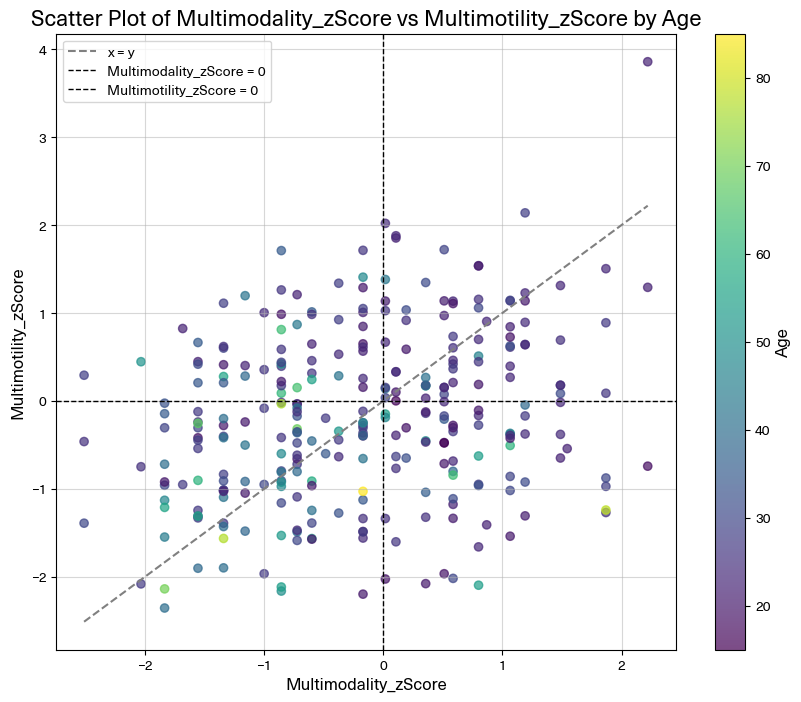

In [110]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure 'Age' is numeric (convert if necessary)
merged_dataset['Age'] = pd.to_numeric(merged_dataset['Age'], errors='coerce')

# Create the figure
plt.figure(figsize=(10, 8))

# Scatter plot of Multimodality_zScore vs Multimotility_zScore with color based on 'Age'
scatter = plt.scatter(
    merged_dataset['Multimodality_zScore'],
    merged_dataset['Multimotility_zScore'],
    c=merged_dataset['Age'],        # Color based on 'Age'
    cmap='viridis',                 # Colormap for better age visualization
    alpha=0.7
    # Removed edgecolor parameter to eliminate the stroke
)

# Add a color bar to indicate the age scale
cbar = plt.colorbar(scatter)
cbar.set_label('Age', fontsize=12)

# Add a line where x = y
x = np.linspace(min(merged_dataset['Multimodality_zScore']), max(merged_dataset['Multimodality_zScore']), 100)
plt.plot(x, x, color='gray', linestyle='--', label='x = y')  # Diagonal line

# Highlight the importance of zero by adding horizontal and vertical lines at 0
plt.axvline(0, color='black', linestyle='--', linewidth=1, label='Multimodality_zScore = 0')
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Multimotility_zScore = 0')

# Add labels, title, and legend
plt.title('Scatter Plot of Multimodality_zScore vs Multimotility_zScore by Age', fontsize=16)
plt.xlabel('Multimodality_zScore', fontsize=12)
plt.ylabel('Multimotility_zScore', fontsize=12)
plt.legend()

# Add grid for better readability
plt.grid(alpha=0.5)

# Save the plot as a PDF
plt.savefig('scatter_plot_age_colored.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


### 5.4.2 Categorgized Age

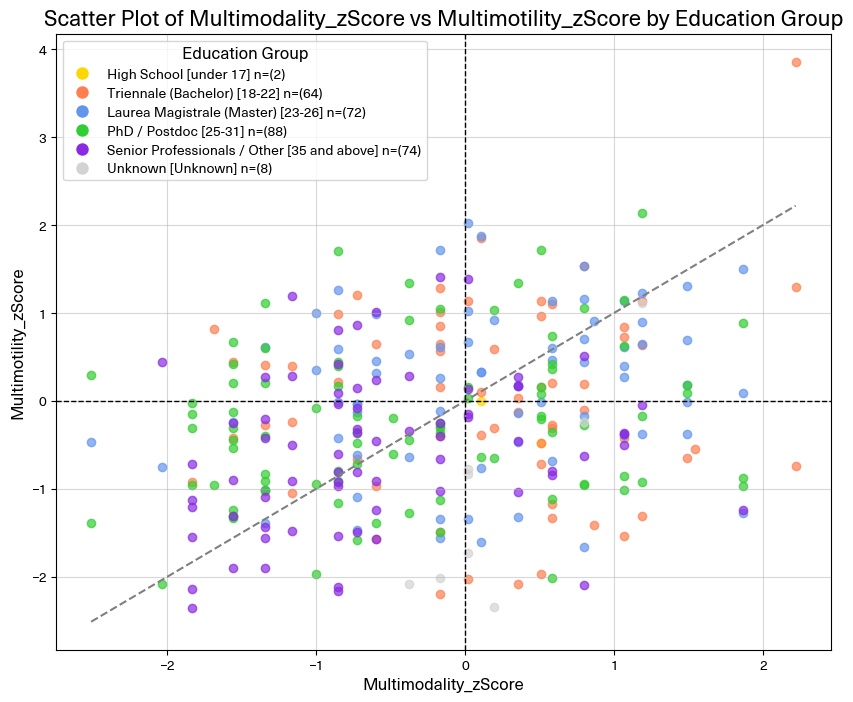

In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Ensure 'Age' is numeric (convert if necessary)
merged_dataset['Age'] = pd.to_numeric(merged_dataset['Age'], errors='coerce')

# Define a function to categorize ages into education groups
def categorize_age(age):
    if pd.isna(age):
        return 'Unknown'
    elif age < 18:
        return 'High School'
    elif 18 <= age <= 22:
        return 'Triennale (Bachelor)'
    elif 23 <= age <= 26:
        return 'Laurea Magistrale (Master)'
    elif 27 <= age <= 35:
        return 'PhD / Postdoc'
    else:
        return 'Senior Professionals / Other'

# Apply the function to create the 'Education_Group' column
merged_dataset['Education_Group'] = merged_dataset['Age'].apply(categorize_age)

# Count the number of occurrences in each group
group_counts = merged_dataset['Education_Group'].value_counts().to_dict()

# Create a color mapping for each education group
education_color_mapping = {
    'High School': '#FFD700',                    # Gold
    'Triennale (Bachelor)': '#FF7F50',           # Coral
    'Laurea Magistrale (Master)': '#6495ED',     # Cornflower Blue
    'PhD / Postdoc': '#32CD32',                  # Lime Green
    'Senior Professionals / Other': '#8A2BE2',   # Blue Violet
    'Unknown': '#D3D3D3'                         # Light Gray for unknowns
}

# Define age ranges for each group for the legend
education_age_ranges = {
    'High School': 'under 17',
    'Triennale (Bachelor)': '18-22',
    'Laurea Magistrale (Master)': '23-26',
    'PhD / Postdoc': '25-31',
    'Senior Professionals / Other': '35 and above',
    'Unknown': 'Unknown'
}

# Create the figure
plt.figure(figsize=(10, 8))

# Scatter plot of Multimodality_zScore vs Multimotility_zScore with colors based on education groups
legend_patches = []
for group, color in education_color_mapping.items():
    subset = merged_dataset[merged_dataset['Education_Group'] == group]
    count = group_counts.get(group, 0)
    age_range = education_age_ranges[group]
    plt.scatter(subset['Multimodality_zScore'], subset['Multimotility_zScore'], c=color, label=f'{group} [{age_range}] n=({count})', alpha=0.7)
    legend_patches.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'{group} [{age_range}] n=({count})'))

# Add a line where x = y
x = np.linspace(min(merged_dataset['Multimodality_zScore']), max(merged_dataset['Multimodality_zScore']), 100)
plt.plot(x, x, color='gray', linestyle='--', label='x = y')

# Highlight the importance of zero by adding horizontal and vertical lines at 0
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.axhline(0, color='black', linestyle='--', linewidth=1)

# Add labels, title, and legend
plt.title('Scatter Plot of Multimodality_zScore vs Multimotility_zScore by Education Group', fontsize=16)
plt.xlabel('Multimodality_zScore', fontsize=12)
plt.ylabel('Multimotility_zScore', fontsize=12)
plt.legend(handles=legend_patches, title='Education Group', loc='upper left', fontsize=10, title_fontsize=12)

# Add grid for better readability
plt.grid(alpha=0.5)

# Save the plot as a PDF
plt.savefig('scatter_plot_education_groups_with_counts.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


# 5.5 Impressions

C:\Users\mafgo\AppData\Local\Temp\ipykernel_9204\1221901579.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dataset['short_impression'] = filtered_dataset['last_mile_impression'].apply(lambda x: str(x).split()[0])


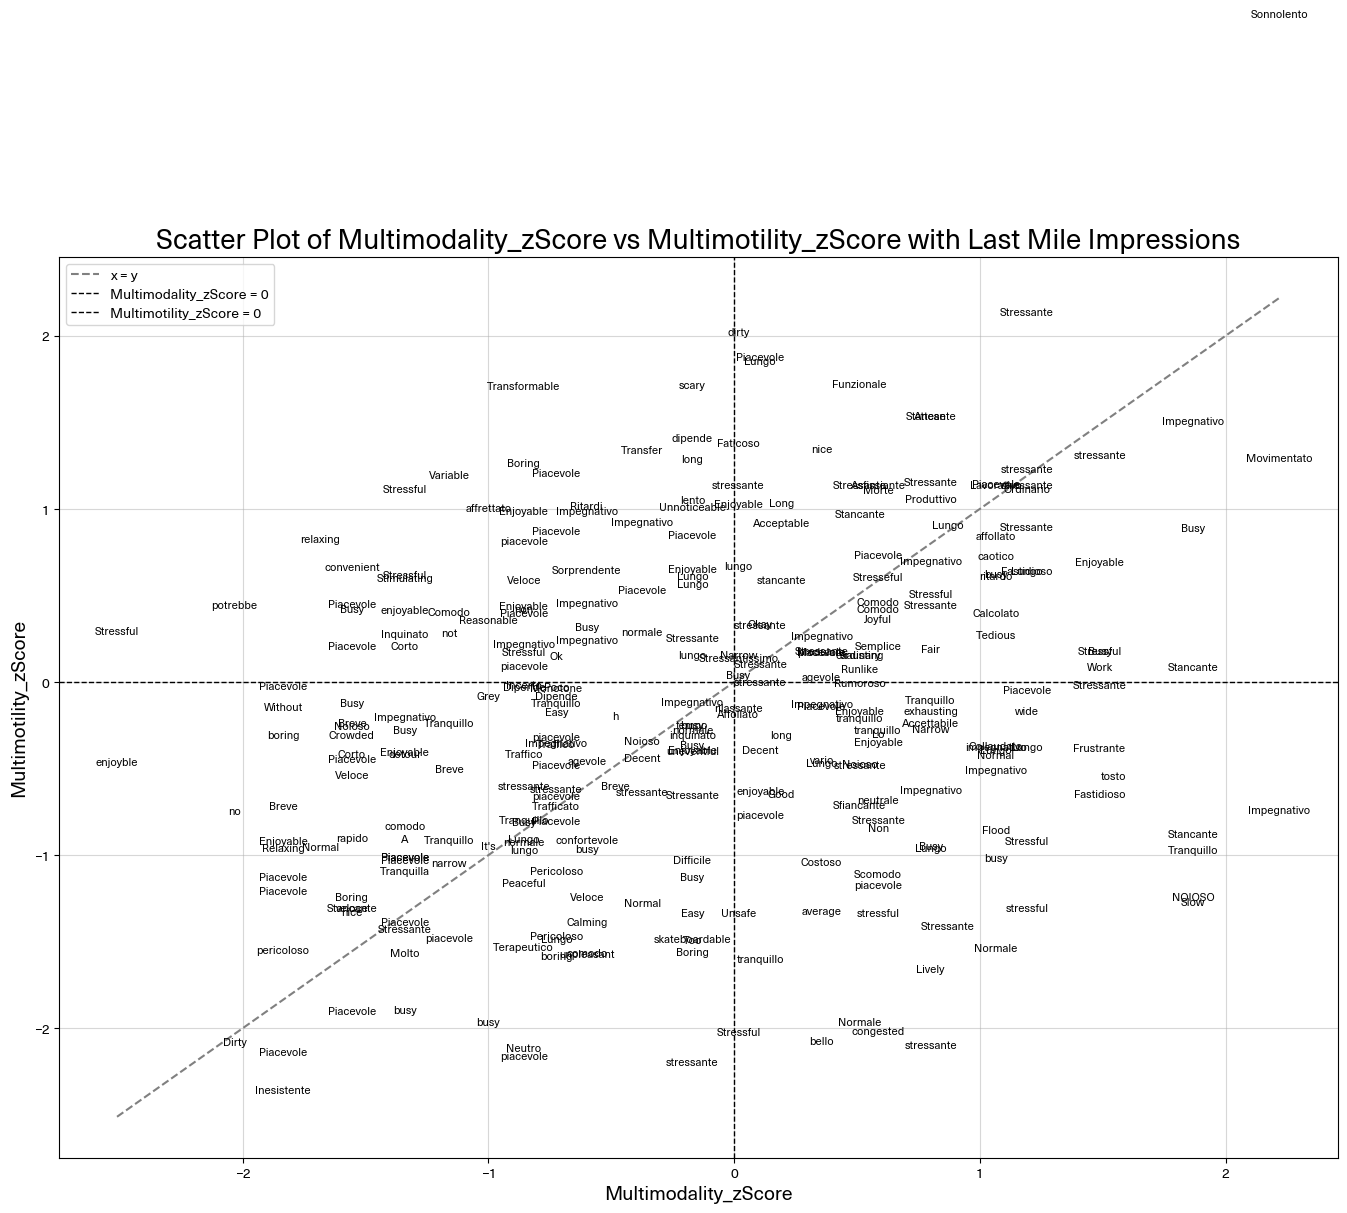

In [114]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Replace infinite values with NaN in the relevant columns
merged_dataset[['Multimodality_zScore', 'Multimotility_zScore', 'last_mile_impression']] = merged_dataset[
    ['Multimodality_zScore', 'Multimotility_zScore', 'last_mile_impression']
].replace([np.inf, -np.inf], np.nan)

# Drop rows with NaN in the relevant columns
filtered_dataset = merged_dataset.dropna(subset=['Multimodality_zScore', 'Multimotility_zScore', 'last_mile_impression'])

# Limit the impressions to one word
filtered_dataset['short_impression'] = filtered_dataset['last_mile_impression'].apply(lambda x: str(x).split()[0])

# Create the figure sized for A3 paper (landscape orientation)
plt.figure(figsize=(16.5, 11.7))  # A3 size in inches (420mm x 297mm)

# Plot each point with the 'short_impression' as text
for i, row in filtered_dataset.iterrows():
    plt.text(
        row['Multimodality_zScore'], 
        row['Multimotility_zScore'], 
        row['short_impression'], 
        fontsize=8,          # Smaller font size for clarity
        ha='center', 
        va='center'
    )

# Add a line where x = y
x = np.linspace(min(filtered_dataset['Multimodality_zScore']), max(filtered_dataset['Multimodality_zScore']), 100)
plt.plot(x, x, color='gray', linestyle='--', label='x = y')  # Diagonal line

# Highlight the importance of zero by adding horizontal and vertical lines at 0
plt.axvline(0, color='black', linestyle='--', linewidth=1, label='Multimodality_zScore = 0')
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Multimotility_zScore = 0')

# Add labels, title, and legend
plt.title('Scatter Plot of Multimodality_zScore vs Multimotility_zScore with Last Mile Impressions', fontsize=20)
plt.xlabel('Multimodality_zScore', fontsize=14)
plt.ylabel('Multimotility_zScore', fontsize=14)
plt.legend()

# Add grid for better readability
plt.grid(alpha=0.5)

# Save the plot as a PDF in A3 size
plt.savefig('scatter_plot_last_mile_impressions_A3.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


In [115]:
merged_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308 entries, 0 to 307
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Response ID           308 non-null    object  
 1   Multimodality_zScore  308 non-null    float64 
 2   Multimotility_zScore  306 non-null    float64 
 3   distance              308 non-null    float64 
 4   CAP_Location          308 non-null    object  
 5   distance_class        308 non-null    int64   
 6   CAP_Rank              308 non-null    int64   
 7   Gender                308 non-null    category
 8   transfer              308 non-null    float64 
 9   Age                   300 non-null    float64 
 10  last_mile_impression  301 non-null    object  
 11  travel_time           302 non-null    float64 
 12  Education_Group       308 non-null    object  
dtypes: category(1), float64(6), int64(2), object(4)
memory usage: 29.5+ KB


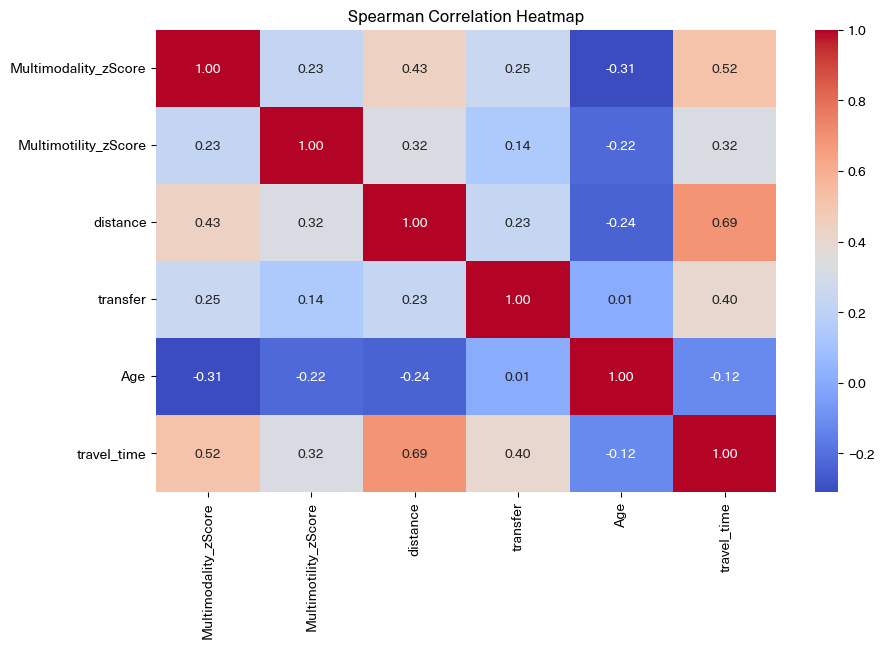

In [116]:
# Extract only the float columns
float_columns = merged_dataset.select_dtypes(include='float64')

# Pearson Correlation
#pearson_corr = float_columns.corr(method='pearson')

# Spearman Correlation
spearman_corr = float_columns.corr(method='spearman')

# Plot Pearson Correlation Heatmap
#plt.figure(figsize=(10, 6))
#sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt=".2f")
#plt.title("Pearson Correlation Heatmap")
#plt.show()

# Plot Spearman Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Spearman Correlation Heatmap")
plt.show()


In [117]:
from langdetect import detect, DetectorFactory

# Ensure consistent results from langdetect
DetectorFactory.seed = 0

# Function to detect language (assumes only Italian or English)
def detect_language(text):
    try:
        lang = detect(text)
        return 'Italian' if lang == 'it' else 'English'
    except:
        return 'Unknown'

# Apply language detection to the 'last_mile_impression' column
merged_dataset['language_label'] = merged_dataset['last_mile_impression'].apply(detect_language)

# Save the labeled dataset to your preferred path
output_path = r"D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\people\py_out\last_mile_impression_labeled.csv"
merged_dataset.to_csv(output_path, index=False)

print(f"Data labeled successfully and saved to: {output_path}")


Data labeled successfully and saved to: D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\people\py_out\last_mile_impression_labeled.csv


In [118]:
dict_path=r"D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\people\py_out\impression-dict.csv"
# Load the second dataset (CSV file)
dict_df = pd.read_csv(dict_path, encoding='Windows-1252')
dict_df

Response ID  Multimodality_zScore  Multimotility_zScore  \
0    R_6JmlJEGCOWo9rTX              0.017263             -1.732001   
1    R_61z5R1KEmMv8GGz             -0.170327             -2.018535   
2    R_2QS9J3nCE9mYu8B              0.017263             -0.769720   
3    R_2JlKjQUhcT7unUa             -0.374319             -2.078315   
4    R_6IoBWPSrHaPVS7I              0.017263             -0.835328   
..                 ...                   ...                   ...   
303  R_2sogfeczO00yYvM             -1.340959             -1.028991   
304  R_81Af79F72aaAUsT              1.064749              0.267545   
305  R_82S6xK8Q8m0Ceye              0.017263              2.018871   
306  R_27pz8nRKYyJZW8h              1.064749             -0.392679   
307  R_2q41Zzco1HRd92q              1.190272             -0.376574   

       distance                   CAP_Location  distance_class  CAP_Rank  \
0     15.044886            In Lombardia Region               2         3   
1     20.372493            In Lombardia Region               2         3   
2      2.424350                       In Milan               1         1   
3    117.914526    Outside of Lombardia Region               4         4   
4      2.424350                       In Milan               1         1   
..          ...                            ...             ...       ...   
303    1.169644                       In Milan               1         1   
304   33.513502            In Lombardia Region               3         3   
305    2.452124                       In Milan               1         1   
306   34.655301  In Metropolitan area of Milan               3         2   
307    9.237931                       In Milan               1         1   

     transfer   Age  Unnamed: 9  travel_time             Education_Group  \
0           0   NaN         NaN          NaN                     Unknown   
1           0   NaN         NaN          NaN                     Unknown   
2           0   NaN         NaN          NaN                     Unknown   
3           0   NaN         NaN          NaN                     Unknown   
4           0   NaN         NaN          NaN                     Unknown   
..        ...   ...         ...          ...                         ...   
303        25  22.0         NaN         20.0        Triennale (Bachelor)   
304        20  23.0         NaN         70.0  Laurea Magistrale (Master)   
305        20  24.0         NaN         30.0  Laurea Magistrale (Master)   
306        15  24.0         NaN         90.0  Laurea Magistrale (Master)   
307         7  24.0         NaN         52.0  Laurea Magistrale (Master)   

    language_label                               last_mile_impression  \
0          Unknown                                                NaN   
1          Unknown                                                NaN   
2          Unknown                                                NaN   
3          Unknown                                                NaN   
4          Unknown                                                NaN   
..             ...                                                ...   
303        Italian                                          Piacevole   
304        English  Tedious but obligatory to reach a pleasant des...   
305        English                                              dirty   
306        English                                              Lungo   
307        English                                              Lungo   

    impression  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  
..         ...  
303   Pleasant  
304     Boring  
305      Dirty  
306       Long  
307       Long  

[308 rows x 15 columns]

In [119]:
# Merge 'impression' from dict_df into merged_dataset based on 'Response ID'
merged_dataset = merged_dataset.merge(
    dict_df[['Response ID', 'impression']],
    on='Response ID',
    how='left'
)

In [120]:
merged_dataset

Response ID  Multimodality_zScore  Multimotility_zScore  \
0    R_6JmlJEGCOWo9rTX              0.017263             -1.732001   
1    R_61z5R1KEmMv8GGz             -0.170327             -2.018535   
2    R_2QS9J3nCE9mYu8B              0.017263             -0.769720   
3    R_2JlKjQUhcT7unUa             -0.374319             -2.078315   
4    R_6IoBWPSrHaPVS7I              0.017263             -0.835328   
..                 ...                   ...                   ...   
303  R_2sogfeczO00yYvM             -1.340959             -1.028991   
304  R_81Af79F72aaAUsT              1.064749              0.267545   
305  R_82S6xK8Q8m0Ceye              0.017263              2.018871   
306  R_27pz8nRKYyJZW8h              1.064749             -0.392679   
307  R_2q41Zzco1HRd92q              1.190272             -0.376574   

       distance                   CAP_Location  distance_class  CAP_Rank  \
0     15.044886            In Lombardia Region               2         3   
1     20.372493            In Lombardia Region               2         3   
2      2.424350                       In Milan               1         1   
3    117.914526    Outside of Lombardia Region               4         4   
4      2.424350                       In Milan               1         1   
..          ...                            ...             ...       ...   
303    1.169644                       In Milan               1         1   
304   33.513502            In Lombardia Region               3         3   
305    2.452124                       In Milan               1         1   
306   34.655301  In Metropolitan area of Milan               3         2   
307    9.237931                       In Milan               1         1   

     Gender  transfer   Age  \
0    Female       0.0   NaN   
1    Female       0.0   NaN   
2      Male       0.0   NaN   
3      Male       0.0   NaN   
4      Male       0.0   NaN   
..      ...       ...   ...   
303  Female      25.0  22.0   
304    Male      20.0  23.0   
305  Female      20.0  24.0   
306    Male      15.0  24.0   
307    Male       7.0  24.0   

                                  last_mile_impression  travel_time  \
0                                                  NaN          NaN   
1                                                  NaN          NaN   
2                                                  NaN          NaN   
3                                                  NaN          NaN   
4                                                  NaN          NaN   
..                                                 ...          ...   
303                                          Piacevole         20.0   
304  Tedious but obligatory to reach a pleasant des...         70.0   
305                                              dirty         30.0   
306                                              Lungo         90.0   
307                                              Lungo         52.0   

                Education_Group language_label impression  
0                       Unknown        Unknown        NaN  
1                       Unknown        Unknown        NaN  
2                       Unknown        Unknown        NaN  
3                       Unknown        Unknown        NaN  
4                       Unknown        Unknown        NaN  
..                          ...            ...        ...  
303        Triennale (Bachelor)        Italian   Pleasant  
304  Laurea Magistrale (Master)        English     Boring  
305  Laurea Magistrale (Master)        English      Dirty  
306  Laurea Magistrale (Master)        English       Long  
307  Laurea Magistrale (Master)        English       Long  

[308 rows x 15 columns]

C:\Users\mafgo\AppData\Local\Temp\ipykernel_9204\2544562750.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  merged_dataset[['Multimodality_zScore', 'Multimotility_zScore']].applymap(np.isfinite).all(axis=1)


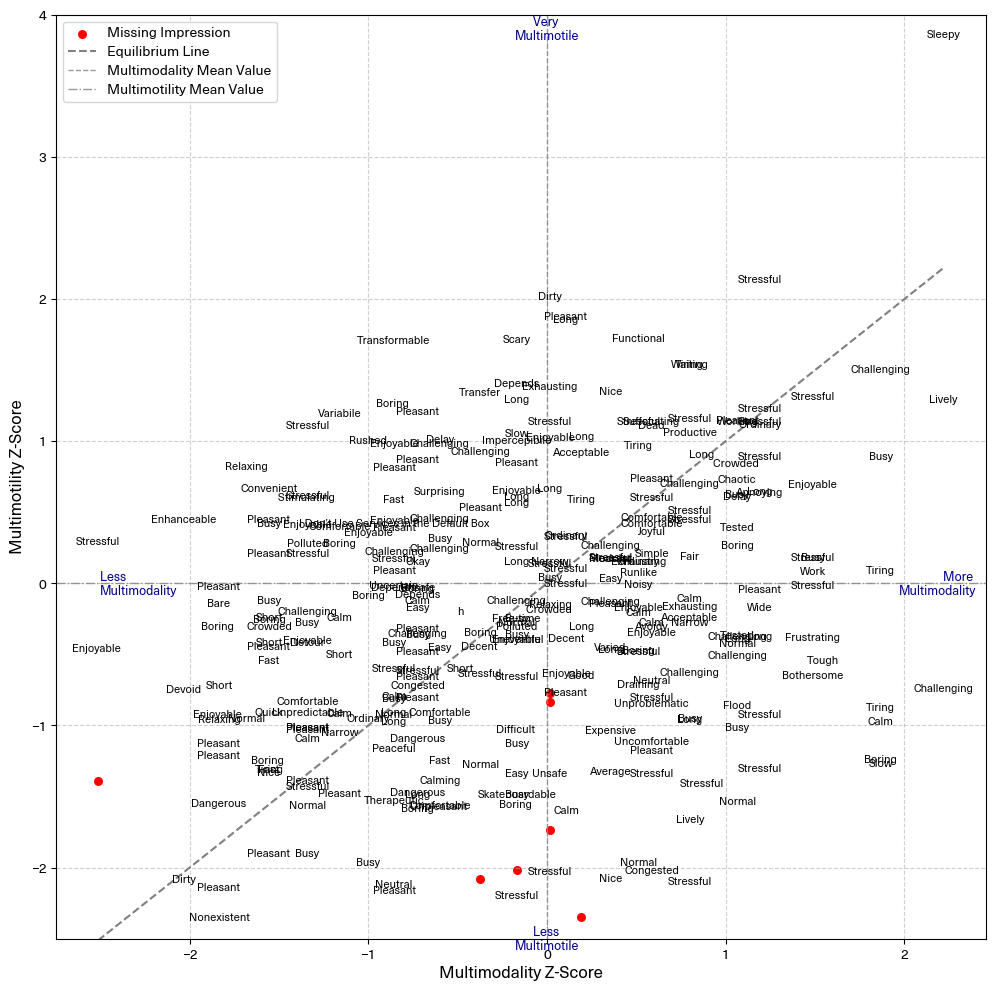

In [121]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl

# Define the output path
output_path = r"D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\people\py_out\impressions_a3.pdf"

# Set the font to Neue Haas Unica
mpl.rcParams['font.family'] = 'Neue Haas Unica'

# Filter out rows with NaN or infinite values in the coordinates
filtered_dataset = merged_dataset[
    merged_dataset[['Multimodality_zScore', 'Multimotility_zScore']].applymap(np.isfinite).all(axis=1)
]

# Scatter plot with text labels
plt.figure(figsize=(12, 12))

# Plot rows with valid impressions as text labels
for _, row in filtered_dataset[filtered_dataset['impression'].notnull()].iterrows():
    plt.text(
        row['Multimodality_zScore'],
        row['Multimotility_zScore'],
        str(row['impression']),
        fontsize=8,
        ha='center',
        va='center'
    )

# Plot rows with missing impressions as points
plt.scatter(
    filtered_dataset.loc[filtered_dataset['impression'].isnull(), 'Multimodality_zScore'],
    filtered_dataset.loc[filtered_dataset['impression'].isnull(), 'Multimotility_zScore'],
    color='red',
    marker='o',
    s=30,
    label='Missing Impression'
)

# Add annotations
plt.text(2.4, 0, 'More \nMultimodality', fontsize=9, color='darkblue', ha='right', va='center')
plt.text(-2.5, 0, 'Less \nMultimodality', fontsize=9, color='darkblue', ha='left', va='center')
plt.text(0, 3.9, 'Very \nMultimotile', fontsize=9, color='darkblue', ha='center', va='center')
plt.text(0, -2.5, 'Less \nMultimotile', fontsize=9, color='darkblue', ha='center', va='center')

# Add axis labels
plt.xlabel('Multimodality Z-Score', fontsize=12)
plt.ylabel('Multimotility Z-Score', fontsize=12)

# Add a line where x = y
x = np.linspace(min(filtered_dataset['Multimodality_zScore']), max(filtered_dataset['Multimodality_zScore']), 100)
plt.plot(x, x, color='gray', linestyle='--', label='Equilibrium Line')  # Diagonal line

# Highlight the importance of zero by adding horizontal and vertical lines at 0
plt.axvline(0, color='gray', linestyle='--', alpha=0.8, linewidth=1, label='Multimodality Mean Value')
plt.axhline(0, color='gray', linestyle='-.', linewidth=1, alpha=0.8, label='Multimotility Mean Value')

# Add a legend
plt.legend(loc='upper left')

# Customize grid
plt.grid(True, linestyle='--', alpha=0.6)

# Set y-axis limits to ensure all points are visible
plt.ylim(-2.5, 4)

# Save the figure
plt.savefig(output_path, format='pdf', bbox_inches='tight')

# Show the figure
plt.show()

C:\Users\mafgo\AppData\Local\Temp\ipykernel_9204\1890862961.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  merged_dataset[['Multimodality_zScore', 'Multimotility_zScore']].applymap(np.isfinite).all(axis=1)
C:\Users\mafgo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\mafgo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\mafgo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks

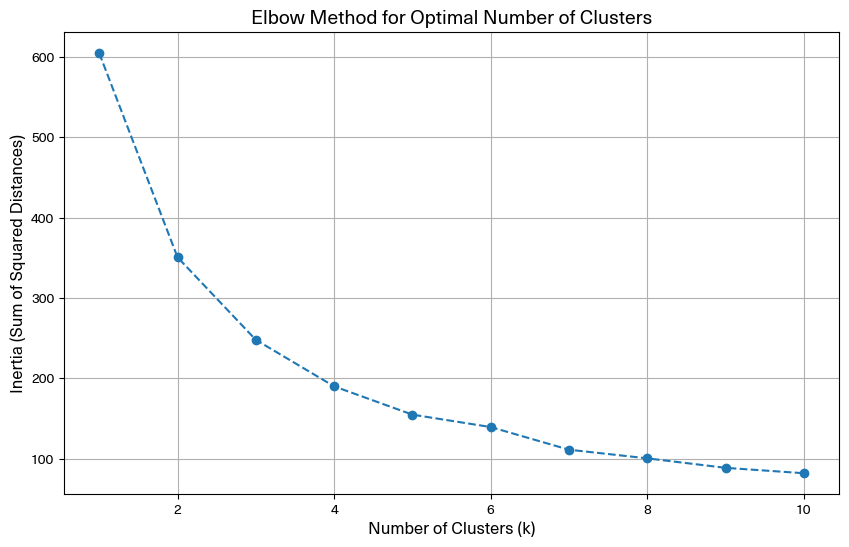

In [122]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
from sklearn.cluster import KMeans

# Define the output path
output_path = r"D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\people\py_out\elbow_analysis.pdf"

# Set the font to Neue Haas Unica
mpl.rcParams['font.family'] = 'Neue Haas Unica'

# Filter out rows with NaN or infinite values in the coordinates
filtered_dataset = merged_dataset[
    merged_dataset[['Multimodality_zScore', 'Multimotility_zScore']].applymap(np.isfinite).all(axis=1)
]

# Extract the coordinates for clustering
X = filtered_dataset[['Multimodality_zScore', 'Multimotility_zScore']].values

# Perform Elbow Analysis for K-Means Clustering
inertia = []
cluster_range = range(1, 11)  # Testing from 1 to 10 clusters

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia (Sum of Squared Distances)', fontsize=12)
plt.title('Elbow Method for Optimal Number of Clusters', fontsize=14)
plt.grid(True)

# Save the figure
plt.savefig(output_path, format='pdf', bbox_inches='tight')

# Show the figure
plt.show()


C:\Users\mafgo\AppData\Local\Temp\ipykernel_9204\2723491349.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  merged_dataset[['Multimodality_zScore', 'Multimotility_zScore']].applymap(np.isfinite).all(axis=1)
C:\Users\mafgo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\mafgo\AppData\Local\Temp\ipykernel_9204\2723491349.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dataset['Cluster'] = kmeans.fit_predict(X)


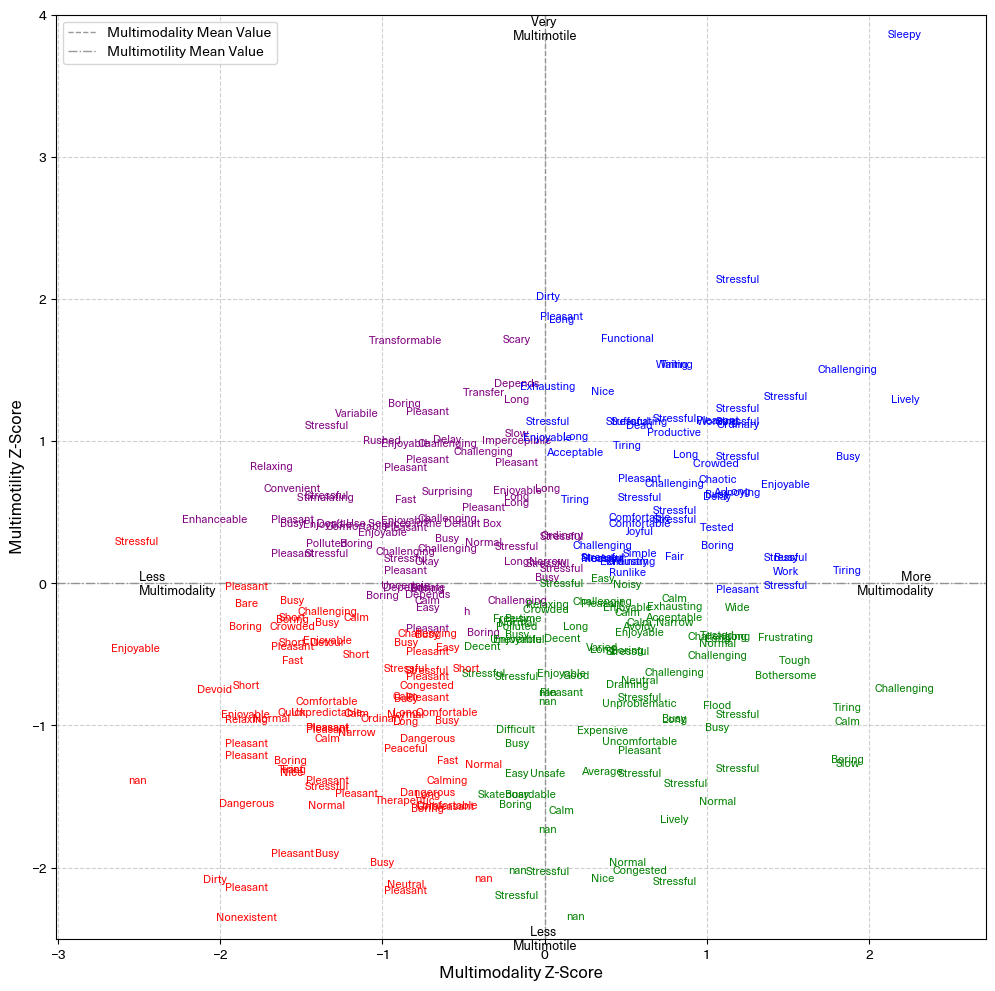

In [123]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
from sklearn.cluster import KMeans

# Define the output path
output_path = r"D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\people\py_out\clustered_coloured_4-impressions.pdf"

# Set the font to Neue Haas Unica
mpl.rcParams['font.family'] = 'Neue Haas Unica'

# Filter out rows with NaN or infinite values in the coordinates
filtered_dataset = merged_dataset[
    merged_dataset[['Multimodality_zScore', 'Multimotility_zScore']].applymap(np.isfinite).all(axis=1)
]

# Extract the coordinates for clustering
X = filtered_dataset[['Multimodality_zScore', 'Multimotility_zScore']].values

# Perform K-Means Clustering with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
filtered_dataset['Cluster'] = kmeans.fit_predict(X)

# Define a colormap for the clusters
cluster_colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'purple'}

# Plot with text labels colored by their cluster
plt.figure(figsize=(12, 12))

# Plot each row with the corresponding cluster color as text labels
for _, row in filtered_dataset.iterrows():
    plt.text(
        row['Multimodality_zScore'],
        row['Multimotility_zScore'],
        str(row['impression']),
        fontsize=8,
        color=cluster_colors[row['Cluster']],
        ha='center',
        va='center'
    )

# Add annotations
plt.text(2.4, 0, 'More \nMultimodality', fontsize=9, color='black', ha='right', va='center')
plt.text(-2.5, 0, 'Less \nMultimodality', fontsize=9, color='black', ha='left', va='center')
plt.text(0, 3.9, 'Very \nMultimotile', fontsize=9, color='black', ha='center', va='center')
plt.text(0, -2.5, 'Less \nMultimotile', fontsize=9, color='black', ha='center', va='center')

# Add axis labels
plt.xlabel('Multimodality Z-Score', fontsize=12)
plt.ylabel('Multimotility Z-Score', fontsize=12)

# Highlight the importance of zero by adding horizontal and vertical lines at 0
plt.axvline(0, color='gray', linestyle='--', alpha=0.8, linewidth=1, label='Multimodality Mean Value')
plt.axhline(0, color='gray', linestyle='-.', linewidth=1, alpha=0.8, label='Multimotility Mean Value')

# Add a legend
plt.legend(loc='upper left')

# Customize grid
plt.grid(True, linestyle='--', alpha=0.6)

# Set dynamic x-axis limits based on the data range
plt.xlim(filtered_dataset['Multimodality_zScore'].min() - 0.5, filtered_dataset['Multimodality_zScore'].max() + 0.5)

# Set y-axis limits to ensure all points are visible
plt.ylim(-2.5, 4)

# Save the figure
plt.savefig(output_path, format='pdf', bbox_inches='tight')

# Show the figure
plt.show()


In [124]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
from sklearn.cluster import KMeans
from PyPDF2 import PdfMerger
import os

# Define the output path
output_base_path = r"D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\people\py_out\impressions"
output_combined_path = os.path.join(output_base_path, "impressions_combined.pdf")

# Set the font to Neue Haas Unica
mpl.rcParams['font.family'] = 'Neue Haas Unica'

# Filter out rows with NaN or infinite values in the coordinates
filtered_dataset = merged_dataset[
    merged_dataset[['Multimodality_zScore', 'Multimotility_zScore']].applymap(np.isfinite).all(axis=1)
]

# Updated categories of impressions with assigned colors
categories = {
    "Positive Responses": (
        "Nice", "Pleasant", "Comfortable", "Enjoyable", "Fair", "Productive", "Convenient", "Stimulating", "Calming", "Easy"
    ),
    "Negative Responses": (
        "Stressful", "Boring", "Unsafe", "Tiring", "Expensive", "Noisy", "Impercepibile", "Scary", "Bare", "Uncomfortable", "Uneventful"
    ),
    "Neutral Responses": (
        "Ordinary", "Normal", "Acceptable"
    ),
    "Spatial Descriptors": (
        "Long", "Short", "Narrow"
    ),
    "Challenging Experiences": (
        "Challenging", "Difficult", "Delay", "Draining"
    ),
    "Temporal Descriptors": (
        "Fast", "Slow", "Delay"
    ),
    "Unique Responses": (
        "Transformable", "Skateboardable", "Avoidy", "Variabile", "Unpredictable", "Surprising", "Therapeutic", "Working", "Runlike"
    )
}

# Define colors for each category
category_colors = {
    "Positive Responses": "green",
    "Negative Responses": "red",
    "Neutral Responses": "blue",
    "Spatial Descriptors": "purple",
    "Challenging Experiences": "orange",
    "Temporal Descriptors": "brown",
    "Unique Responses": "magenta"
}

# Function to create a plot for a given category
def plot_category(category_name, impressions, color, output_path):
    plt.figure(figsize=(12, 12))
    
    # Plot all points as gray dots
    plt.scatter(
        filtered_dataset['Multimodality_zScore'],
        filtered_dataset['Multimotility_zScore'],
        color='gray',
        alpha=0.5,
        marker='o',
        s=30
    )
    
    # Plot the words for the selected category
    for _, row in filtered_dataset.iterrows():
        if row['impression'] in impressions:
            plt.text(
                row['Multimodality_zScore'],
                row['Multimotility_zScore'],
                str(row['impression']),
                fontsize=8,
                color=color,
                ha='center',
                va='center'
            )
    
    # Add annotations
    plt.text(2.4, 0, 'More \nMultimodality', fontsize=9, color='black', ha='right', va='center')
    plt.text(-2.5, 0, 'Less \nMultimodality', fontsize=9, color='black', ha='left', va='center')
    plt.text(0, 3.9, 'Very \nMultimotile', fontsize=9, color='black', ha='center', va='center')
    plt.text(0, -2.5, 'Less \nMultimotile', fontsize=9, color='black', ha='center', va='center')
    
    # Add axis labels
    plt.xlabel('Multimodality Z-Score', fontsize=12)
    plt.ylabel('Multimotility Z-Score', fontsize=12)
    
    # Highlight the importance of zero by adding horizontal and vertical lines at 0
    plt.axvline(0, color='gray', linestyle='--', alpha=0.8, linewidth=1)
    plt.axhline(0, color='gray', linestyle='-.', linewidth=1, alpha=0.8)
    
    # Customize grid
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Set dynamic x and y axis limits
    plt.xlim(filtered_dataset['Multimodality_zScore'].min() - 0.5, filtered_dataset['Multimodality_zScore'].max() + 0.5)
    plt.ylim(-2.5, 4)
    
    # Add a title
    plt.title(f"{category_name}", fontsize=14)
    
    # Save the figure
    plt.savefig(output_path, format='pdf', bbox_inches='tight')
    
    # Close the plot
    plt.close()

# Generate and save a plot for each category
pdf_files = []
for category_name, impressions in categories.items():
    output_path = os.path.join(output_base_path, f"{category_name.replace(' ', '_').lower()}.pdf")
    plot_category(category_name, impressions, category_colors[category_name], output_path)
    pdf_files.append(output_path)

# Merge all the category PDFs into one combined PDF
merger = PdfMerger()
for pdf in pdf_files:
    merger.append(pdf)

merger.write(output_combined_path)
merger.close()

print(f"All category PDFs have been merged into {output_combined_path}")


C:\Users\mafgo\AppData\Local\Temp\ipykernel_9204\2298930318.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  merged_dataset[['Multimodality_zScore', 'Multimotility_zScore']].applymap(np.isfinite).all(axis=1)


All category PDFs have been merged into D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\people\py_out\impressions\impressions_combined.pdf


In [125]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
from sklearn.cluster import KMeans
from PyPDF2 import PdfMerger
import os
import random

# Define the output path
output_base_path = r"D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\people\py_out\impressions"
output_combined_path = os.path.join(output_base_path, "impressions_combined.pdf")

# Set the font to Neue Haas Unica
mpl.rcParams['font.family'] = 'Neue Haas Unica'

# Filter out rows with NaN or infinite values in the coordinates
filtered_dataset = merged_dataset[
    merged_dataset[['Multimodality_zScore', 'Multimotility_zScore']].applymap(np.isfinite).all(axis=1)
]

# Add a 'quartile' column based on the (0, 0) point
def assign_quartile(row):
    if row['Multimodality_zScore'] < 0 and row['Multimotility_zScore'] > 0:
        return 'Q1'
    elif row['Multimodality_zScore'] > 0 and row['Multimotility_zScore'] > 0:
        return 'Q2'
    elif row['Multimodality_zScore'] > 0 and row['Multimotility_zScore'] < 0:
        return 'Q3'
    elif row['Multimodality_zScore'] < 0 and row['Multimotility_zScore'] < 0:
        return 'Q4'
    else:
        return 'On Axis'

filtered_dataset['quartile'] = filtered_dataset.apply(assign_quartile, axis=1)

# Updated categories of impressions
categories = {
    "Positive Responses": (
        "Nice", "Pleasant", "Comfortable", "Enjoyable", "Fair", "Productive", "Convenient", "Stimulating", "Calming", "Easy"
    ),
    "Negative Responses": (
        "Stressful", "Boring", "Unsafe", "Tiring", "Expensive", "Noisy", "Impercepibile", "Scary", "Bare", "Uncomfortable", "Uneventful"
    ),
    "Neutral Responses": (
        "Ordinary", "Normal", "Acceptable"
    ),
    "Spatial Descriptors": (
        "Long", "Short", "Narrow"
    ),
    "Challenging Experiences": (
        "Challenging", "Difficult", "Delay", "Draining"
    ),
    "Temporal Descriptors": (
        "Fast", "Slow", "Delay"
    ),
    "Unique Responses": (
        "Transformable", "Skateboardable", "Avoidy", "Variabile", "Unpredictable", "Surprising", "Therapeutic", "Working", "Runlike"
    )
}

# Function to generate a random color
def random_color():
    return "#" + "".join([random.choice("0123456789ABCDEF") for _ in range(6)])

# Function to create a plot for a given category
def plot_category(category_name, impressions, output_path):
    plt.figure(figsize=(12, 12))
    
    # Plot all points as gray dots
    plt.scatter(
        filtered_dataset['Multimodality_zScore'],
        filtered_dataset['Multimotility_zScore'],
        color='gray',
        alpha=0.5,
        marker='o',
        s=30
    )
    
    # Assign a unique color for each word in the category
    word_colors = {word: random_color() for word in impressions}
    
    # Plot the words with unique colors and bold font
    for _, row in filtered_dataset.iterrows():
        if row['impression'] in impressions:
            plt.text(
                row['Multimodality_zScore'],
                row['Multimotility_zScore'],
                str(row['impression']),
                fontsize=8,
                color=word_colors[row['impression']],
                fontweight='bold',
                ha='center',
                va='center'
            )
    
    # Add legend
    handles = [plt.Line2D([0], [0], marker='o', color=color, linestyle='', label=word) 
               for word, color in word_colors.items()]
    plt.legend(handles=handles, loc='upper right', fontsize=8, title=category_name)
    
    # Add annotations
    plt.text(2.4, 0, 'More \nMultimodality', fontsize=9, color='black', ha='right', va='center')
    plt.text(-2.5, 0, 'Less \nMultimodality', fontsize=9, color='black', ha='left', va='center')
    plt.text(0, 3.9, 'Very \nMultimotile', fontsize=9, color='black', ha='center', va='center')
    plt.text(0, -2.5, 'Less \nMultimotile', fontsize=9, color='black', ha='center', va='center')
    
    # Add axis labels
    plt.xlabel('Multimodality Z-Score', fontsize=12)
    plt.ylabel('Multimotility Z-Score', fontsize=12)
    
    # Highlight the importance of zero by adding horizontal and vertical lines at 0
    plt.axvline(0, color='gray', linestyle='--', alpha=0.8, linewidth=1)
    plt.axhline(0, color='gray', linestyle='-.', linewidth=1, alpha=0.8)
    
    # Customize grid
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Set dynamic x and y axis limits
    plt.xlim(filtered_dataset['Multimodality_zScore'].min() - 0.5, filtered_dataset['Multimodality_zScore'].max() + 0.5)
    plt.ylim(-2.5, 4)
    
    # Add a title
    plt.title(f"{category_name}", fontsize=14)
    
    # Save the figure
    plt.savefig(output_path, format='pdf', bbox_inches='tight')
    
    # Close the plot
    plt.close()

# Generate and save a plot for each category
pdf_files = []
for i, (category_name, impressions) in enumerate(categories.items(), start=1):
    output_path = os.path.join(output_base_path, f"{i:02d}_{category_name.replace(' ', '_').lower()}.pdf")
    plot_category(category_name, impressions, output_path)
    pdf_files.append(output_path)

# Merge all the category PDFs into one combined PDF
merger = PdfMerger()
for pdf in pdf_files:
    merger.append(pdf)

merger.write(output_combined_path)
merger.close()

print(f"All category PDFs have been merged into {output_combined_path}")


C:\Users\mafgo\AppData\Local\Temp\ipykernel_9204\2317774105.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  merged_dataset[['Multimodality_zScore', 'Multimotility_zScore']].applymap(np.isfinite).all(axis=1)
C:\Users\mafgo\AppData\Local\Temp\ipykernel_9204\2317774105.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dataset['quartile'] = filtered_dataset.apply(assign_quartile, axis=1)


All category PDFs have been merged into D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\people\py_out\impressions\impressions_combined.pdf


In [126]:
# Add a 'quartile' column based on the (0, 0) point
def assign_quartile(row):
    if row['Multimodality_zScore'] < 0 and row['Multimotility_zScore'] > 0:
        return 'Q1'
    elif row['Multimodality_zScore'] > 0 and row['Multimotility_zScore'] > 0:
        return 'Q2'
    elif row['Multimodality_zScore'] > 0 and row['Multimotility_zScore'] < 0:
        return 'Q3'
    elif row['Multimodality_zScore'] < 0 and row['Multimotility_zScore'] < 0:
        return 'Q4'
    else:
        return 'On Axis'

# Apply the function to the dataset
merged_dataset['quartile'] = merged_dataset.apply(assign_quartile, axis=1)

merged_dataset



Response ID  Multimodality_zScore  Multimotility_zScore  \
0    R_6JmlJEGCOWo9rTX              0.017263             -1.732001   
1    R_61z5R1KEmMv8GGz             -0.170327             -2.018535   
2    R_2QS9J3nCE9mYu8B              0.017263             -0.769720   
3    R_2JlKjQUhcT7unUa             -0.374319             -2.078315   
4    R_6IoBWPSrHaPVS7I              0.017263             -0.835328   
..                 ...                   ...                   ...   
303  R_2sogfeczO00yYvM             -1.340959             -1.028991   
304  R_81Af79F72aaAUsT              1.064749              0.267545   
305  R_82S6xK8Q8m0Ceye              0.017263              2.018871   
306  R_27pz8nRKYyJZW8h              1.064749             -0.392679   
307  R_2q41Zzco1HRd92q              1.190272             -0.376574   

       distance                   CAP_Location  distance_class  CAP_Rank  \
0     15.044886            In Lombardia Region               2         3   
1     20.372493            In Lombardia Region               2         3   
2      2.424350                       In Milan               1         1   
3    117.914526    Outside of Lombardia Region               4         4   
4      2.424350                       In Milan               1         1   
..          ...                            ...             ...       ...   
303    1.169644                       In Milan               1         1   
304   33.513502            In Lombardia Region               3         3   
305    2.452124                       In Milan               1         1   
306   34.655301  In Metropolitan area of Milan               3         2   
307    9.237931                       In Milan               1         1   

     Gender  transfer   Age  \
0    Female       0.0   NaN   
1    Female       0.0   NaN   
2      Male       0.0   NaN   
3      Male       0.0   NaN   
4      Male       0.0   NaN   
..      ...       ...   ...   
303  Female      25.0  22.0   
304    Male      20.0  23.0   
305  Female      20.0  24.0   
306    Male      15.0  24.0   
307    Male       7.0  24.0   

                                  last_mile_impression  travel_time  \
0                                                  NaN          NaN   
1                                                  NaN          NaN   
2                                                  NaN          NaN   
3                                                  NaN          NaN   
4                                                  NaN          NaN   
..                                                 ...          ...   
303                                          Piacevole         20.0   
304  Tedious but obligatory to reach a pleasant des...         70.0   
305                                              dirty         30.0   
306                                              Lungo         90.0   
307                                              Lungo         52.0   

                Education_Group language_label impression quartile  
0                       Unknown        Unknown        NaN       Q3  
1                       Unknown        Unknown        NaN       Q4  
2                       Unknown        Unknown        NaN       Q3  
3                       Unknown        Unknown        NaN       Q4  
4                       Unknown        Unknown        NaN       Q3  
..                          ...            ...        ...      ...  
303        Triennale (Bachelor)        Italian   Pleasant       Q4  
304  Laurea Magistrale (Master)        English     Boring       Q2  
305  Laurea Magistrale (Master)        English      Dirty       Q2  
306  Laurea Magistrale (Master)        English       Long       Q3  
307  Laurea Magistrale (Master)        English       Long       Q3  

[308 rows x 16 columns]

In [127]:
path = r"D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\people\py_out\Q.csv"
merged_dataset.to_csv(path, index=False)

In [128]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
from wordcloud import WordCloud
from collections import Counter
import os

# Define the output path
output_base_path = r"D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\people\py_out\impressions"

# Generate word clouds for each quartile without weighting
def generate_wordclouds_by_quartile(data, output_path):
    quartiles = ['Q1', 'Q2', 'Q3', 'Q4']
    
    for quartile in quartiles:
        # Filter data for the current quartile
        quartile_data = data[data['quartile'] == quartile]
        
        # Join all impressions in the current quartile
        text = " ".join(quartile_data['impression'].dropna())
        
        # Generate the word cloud
        wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text)
        
        # Plot the word cloud
        plt.figure(figsize=(8, 8))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"Word Cloud for {quartile}")
        
        # Save the word cloud to a file
        output_file = os.path.join(output_path, f"wordcloud_{quartile}.pdf")
        plt.savefig(output_file, format='pdf', bbox_inches='tight')
        plt.close()
        
        print(f"Word cloud saved for {quartile} at {output_file}")

# Generate the word clouds
generate_wordclouds_by_quartile(merged_dataset, output_base_path)

print("Word clouds generated for all quartiles.")


Word cloud saved for Q1 at D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\people\py_out\impressions\wordcloud_Q1.pdf
Word cloud saved for Q2 at D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\people\py_out\impressions\wordcloud_Q2.pdf
Word cloud saved for Q3 at D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\people\py_out\impressions\wordcloud_Q3.pdf
Word cloud saved for Q4 at D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\people\py_out\impressions\wordcloud_Q4.pdf
Word clouds generated for all quartiles.


In [129]:
# Define the output path
output_base_path = r"D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\people\py_out\impressions"

# Generate a DataFrame showing word counts by quartile
def create_word_count_dataframe(data):
    quartiles = ['Q1', 'Q2', 'Q3', 'Q4']
    
    # List to store word count data
    word_count_data = []
    
    for quartile in quartiles:
        # Filter data for the current quartile
        quartile_data = data[data['quartile'] == quartile]
        
        # Count the frequency of each word in the current quartile
        quartile_counts = Counter(quartile_data['impression'].dropna())
        
        # Append the counts to the list
        for word, count in quartile_counts.items():
            word_count_data.append({'quartile': quartile, 'word': word, 'count': count})
    
    # Create a DataFrame from the word count data
    word_count_df = pd.DataFrame(word_count_data)
    
    # Sort the DataFrame by quartile and count (descending)
    word_count_df = word_count_df.sort_values(by=['quartile', 'count'], ascending=[True, False])
    
    return word_count_df

# Create the word count DataFrame
word_count_df = create_word_count_dataframe(merged_dataset)

# Display the DataFrame
print(word_count_df)

# Optionally, save the DataFrame to a CSV file
output_csv_path = os.path.join(output_base_path, "word_counts_by_quartile.csv")
word_count_df.to_csv(output_csv_path, index=False)
print(f"Word count DataFrame saved to {output_csv_path}")

    quartile           word  count
1         Q1       Pleasant      9
16        Q1      Stressful      6
2         Q1      Enjoyable      5
14        Q1    Challenging      5
25        Q1           Long      4
..       ...            ...    ...
139       Q4  Unpredictable      1
140       Q4     Uneventful      1
141       Q4    Unpleasant       1
143       Q4       Peaceful      1
144       Q4         Devoid      1

[145 rows x 3 columns]
Word count DataFrame saved to D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\people\py_out\impressions\word_counts_by_quartile.csv


In [130]:
word_count_df

quartile           word  count
1         Q1       Pleasant      9
16        Q1      Stressful      6
2         Q1      Enjoyable      5
14        Q1    Challenging      5
25        Q1           Long      4
..       ...            ...    ...
139       Q4  Unpredictable      1
140       Q4     Uneventful      1
141       Q4    Unpleasant       1
143       Q4       Peaceful      1
144       Q4         Devoid      1

[145 rows x 3 columns]

In [132]:
print(merged_dataset.isna().sum())  # Check for NaNs
print(merged_dataset.isin([np.inf, -np.inf]).sum())  # Check for Infs

Response ID             0
Multimodality_zScore    0
Multimotility_zScore    2
distance                0
CAP_Location            0
distance_class          0
CAP_Rank                0
Gender                  0
transfer                0
Age                     8
last_mile_impression    7
travel_time             6
Education_Group         0
language_label          0
impression              7
quartile                0
dtype: int64
Response ID             0
Multimodality_zScore    0
Multimotility_zScore    0
distance                0
CAP_Location            0
distance_class          0
CAP_Rank                0
Gender                  0
transfer                0
Age                     0
last_mile_impression    0
travel_time             0
Education_Group         0
language_label          0
impression              0
quartile                0
dtype: int64


# Test Section

In [324]:
merged_dataset

Response ID  Multimodality_zScore  Multimotility_zScore  \
0    R_6JmlJEGCOWo9rTX              0.017263             -1.732001   
1    R_61z5R1KEmMv8GGz             -0.170327             -2.018535   
2    R_2QS9J3nCE9mYu8B              0.017263             -0.769720   
3    R_2JlKjQUhcT7unUa             -0.374319             -2.078315   
4    R_6IoBWPSrHaPVS7I              0.017263             -0.835328   
..                 ...                   ...                   ...   
303  R_2sogfeczO00yYvM             -1.340959             -1.028991   
304  R_81Af79F72aaAUsT              1.064749              0.267545   
305  R_82S6xK8Q8m0Ceye              0.017263              2.018871   
306  R_27pz8nRKYyJZW8h              1.064749             -0.392679   
307  R_2q41Zzco1HRd92q              1.190272             -0.376574   

       distance                   CAP_Location  distance_class  CAP_Rank  \
0     15.044886            In Lombardia Region               2         3   
1     20.372493            In Lombardia Region               2         3   
2      2.424350                       In Milan               1         1   
3    117.914526    Outside of Lombardia Region               4         4   
4      2.424350                       In Milan               1         1   
..          ...                            ...             ...       ...   
303    1.169644                       In Milan               1         1   
304   33.513502            In Lombardia Region               3         3   
305    2.452124                       In Milan               1         1   
306   34.655301  In Metropolitan area of Milan               3         2   
307    9.237931                       In Milan               1         1   

     Gender  transfer   Age  \
0    Female       0.0   NaN   
1    Female       0.0   NaN   
2      Male       0.0   NaN   
3      Male       0.0   NaN   
4      Male       0.0   NaN   
..      ...       ...   ...   
303  Female      25.0  22.0   
304    Male      20.0  23.0   
305  Female      20.0  24.0   
306    Male      15.0  24.0   
307    Male       7.0  24.0   

                                  last_mile_impression  travel_time  \
0                                                  NaN          NaN   
1                                                  NaN          NaN   
2                                                  NaN          NaN   
3                                                  NaN          NaN   
4                                                  NaN          NaN   
..                                                 ...          ...   
303                                          Piacevole         20.0   
304  Tedious but obligatory to reach a pleasant des...         70.0   
305                                              dirty         30.0   
306                                              Lungo         90.0   
307                                              Lungo         52.0   

                Education_Group language_label impression quartile  
0                       Unknown        Unknown        NaN       Q3  
1                       Unknown        Unknown        NaN       Q4  
2                       Unknown        Unknown        NaN       Q3  
3                       Unknown        Unknown        NaN       Q4  
4                       Unknown        Unknown        NaN       Q3  
..                          ...            ...        ...      ...  
303        Triennale (Bachelor)        Italian   Pleasant       Q4  
304  Laurea Magistrale (Master)        English     Boring       Q2  
305  Laurea Magistrale (Master)        English      Dirty       Q2  
306  Laurea Magistrale (Master)        English       Long       Q3  
307  Laurea Magistrale (Master)        English       Long       Q3  

[308 rows x 16 columns]

In [320]:
merged_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308 entries, 0 to 307
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Response ID           308 non-null    object  
 1   Multimodality_zScore  308 non-null    float64 
 2   Multimotility_zScore  306 non-null    float64 
 3   distance              308 non-null    float64 
 4   CAP_Location          308 non-null    object  
 5   distance_class        308 non-null    int64   
 6   CAP_Rank              308 non-null    int64   
 7   Gender                308 non-null    category
 8   transfer              308 non-null    float64 
 9   Age                   300 non-null    float64 
 10  last_mile_impression  301 non-null    object  
 11  travel_time           302 non-null    float64 
 12  Education_Group       308 non-null    object  
 13  language_label        308 non-null    object  
 14  impression            301 non-null    object  
 15  quarti

In [322]:
# Replace `merged_dataset` with your actual DataFrame variable if different
output_path = "D:/15_Polimi/Polimi_onedrive/OneDrive - Politecnico di Milano/PhD/people/py_out/merged_dataset.csv"

# Save the dataset to CSV
merged_dataset.to_csv(output_path, index=False)

print(f"Dataset saved to {output_path}")

Dataset saved to D:/15_Polimi/Polimi_onedrive/OneDrive - Politecnico di Milano/PhD/people/py_out/merged_dataset.csv


# 5.6 Correlations

     Dependent Variable Independent Variable  Pearson Correlation  \
0  Multimodality_zScore             distance             0.263592   
1  Multimodality_zScore             transfer             0.191015   
2  Multimodality_zScore                  Age            -0.241690   
3  Multimodality_zScore          travel_time             0.498409   
4  Multimotility_zScore             distance             0.282150   
5  Multimotility_zScore             transfer             0.112724   
6  Multimotility_zScore                  Age            -0.226593   
7  Multimotility_zScore          travel_time             0.340708   

   Spearman Correlation  
0              0.442927  
1              0.269462  
2             -0.310477  
3              0.543464  
4              0.324067  
5              0.144220  
6             -0.219885  
7              0.320386  


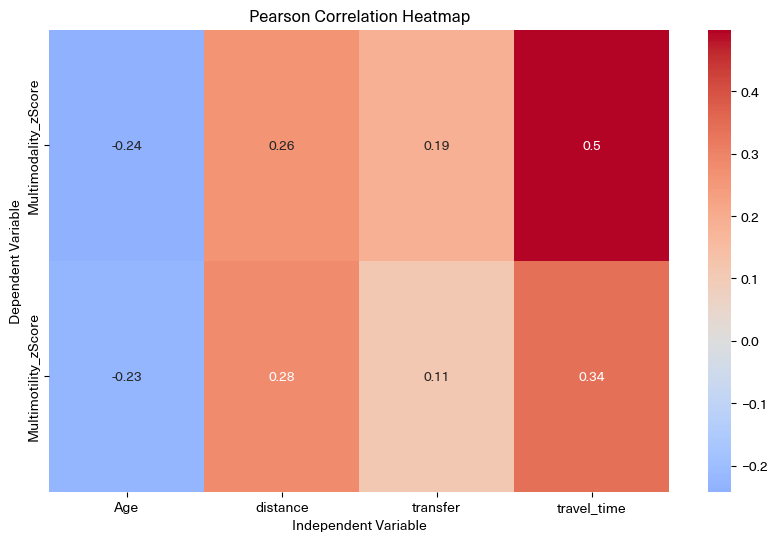

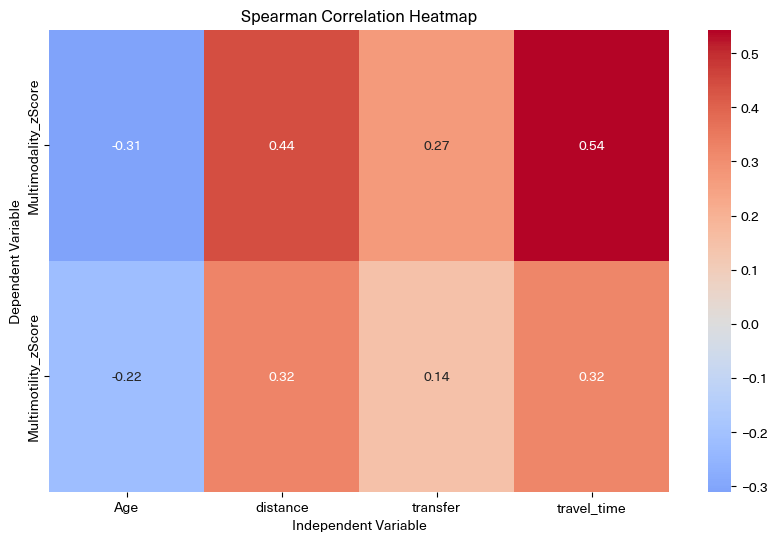

In [134]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

# List of independent variables
independent_vars = ['distance', 'transfer', 'Age', 'travel_time']

# List of dependent variables
dependent_vars = ['Multimodality_zScore', 'Multimotility_zScore']

# Filter out rows where dependent variables are null
merged_dataset_clean = merged_dataset.dropna(subset=dependent_vars)

# Store results in a list of dictionaries
results = []

# Perform correlation tests
for dep in dependent_vars:
    for indep in independent_vars:
        # Drop rows with NaNs in the independent variable
        data_subset = merged_dataset_clean.dropna(subset=[indep])
        
        # Pearson Correlation
        pearson_corr, pearson_p = pearsonr(data_subset[indep], data_subset[dep])
        
        # Spearman Correlation
        spearman_corr, spearman_p = spearmanr(data_subset[indep], data_subset[dep])
        
        # Append results to the list
        results.append({
            'Dependent Variable': dep,
            'Independent Variable': indep,
            'Pearson Correlation': pearson_corr,
            'Spearman Correlation': spearman_corr
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Create pivot tables for heatmaps
pearson_pivot = results_df.pivot(index='Dependent Variable', columns='Independent Variable', values='Pearson Correlation')
spearman_pivot = results_df.pivot(index='Dependent Variable', columns='Independent Variable', values='Spearman Correlation')

# Plot Pearson Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pearson_pivot, annot=True, cmap='coolwarm', center=0)
plt.title('Pearson Correlation Heatmap')
plt.show()

# Plot Spearman Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(spearman_pivot, annot=True, cmap='coolwarm', center=0)
plt.title('Spearman Correlation Heatmap')

# Define the output path
output_path = r"D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\Presi\20-12-2024-Prof.Simone\spearman_correlation_heatmap.pdf"

# Save the plot as a PDF
plt.savefig(output_path, format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


In [135]:
pearson_pivot

Independent Variable       Age  distance  transfer  travel_time
Dependent Variable                                             
Multimodality_zScore -0.241690  0.263592  0.191015     0.498409
Multimotility_zScore -0.226593  0.282150  0.112724     0.340708

In [136]:
spearman_pivot # the best to use as data is not normalized 

Independent Variable       Age  distance  transfer  travel_time
Dependent Variable                                             
Multimodality_zScore -0.310477  0.442927  0.269462     0.543464
Multimotility_zScore -0.219885  0.324067  0.144220     0.320386

In [137]:
import pandas as pd
from scipy.stats import spearmanr

# List of independent variables
independent_vars = ['distance', 'transfer', 'Age', 'travel_time']

# List of dependent variables
dependent_vars = ['Multimodality_zScore', 'Multimotility_zScore']

# Filter out rows where dependent variables are null
merged_dataset_clean = merged_dataset.dropna(subset=dependent_vars)

# Store results in a list of dictionaries
spearman_results = []

# Perform Spearman correlation tests
for dep in dependent_vars:
    for indep in independent_vars:
        # Drop rows with NaNs in the independent variable
        data_subset = merged_dataset_clean.dropna(subset=[indep])
        
        # Spearman Correlation with p-value
        spearman_corr, spearman_p = spearmanr(data_subset[indep], data_subset[dep])
        
        # Append results to the list
        spearman_results.append({
            'Dependent Variable': dep,
            'Independent Variable': indep,
            'Spearman Correlation': spearman_corr,
            'Spearman p-value': spearman_p
        })

# Convert results to a DataFrame
spearman_results_df = pd.DataFrame(spearman_results)
spearman_results_df

Dependent Variable Independent Variable  Spearman Correlation  \
0  Multimodality_zScore             distance              0.442927   
1  Multimodality_zScore             transfer              0.269462   
2  Multimodality_zScore                  Age             -0.310477   
3  Multimodality_zScore          travel_time              0.543464   
4  Multimotility_zScore             distance              0.324067   
5  Multimotility_zScore             transfer              0.144220   
6  Multimotility_zScore                  Age             -0.219885   
7  Multimotility_zScore          travel_time              0.320386   

   Spearman p-value  
0      3.908034e-16  
1      1.725924e-06  
2      4.425422e-08  
3      1.878003e-24  
4      6.513592e-09  
5      1.154623e-02  
6      1.298266e-04  
7      1.375530e-08

In [138]:
import numpy as np
import pandas as pd

def calculate_weights(df, corr_col='Spearman Correlation', pval_col='Spearman p-value'):
    """
    Calculate weights based on Spearman correlation and p-values.

    Parameters:
        df (pd.DataFrame): DataFrame containing correlation and p-value columns.
        corr_col (str): Name of the column containing Spearman correlation values.
        pval_col (str): Name of the column containing p-values.

    Returns:
        pd.DataFrame: Original DataFrame with additional 'Weight' column.
    """
    # Ensure correlation is in absolute terms
    df['Normalized Correlation'] = df[corr_col].abs()
    
    # Transform p-values using -log10(p-value) to emphasize smaller p-values
    df['Transformed p-value'] = -np.log10(df[pval_col])
    
    # Calculate the weights
    df['Weight'] = df['Normalized Correlation'] * df['Transformed p-value']
    
    return df


In [139]:
# Assuming spearman_results_df is your DataFrame
spearman_results_df = calculate_weights(spearman_results_df)

# Display the updated DataFrame with weights
print(spearman_results_df)


     Dependent Variable Independent Variable  Spearman Correlation  \
0  Multimodality_zScore             distance              0.442927   
1  Multimodality_zScore             transfer              0.269462   
2  Multimodality_zScore                  Age             -0.310477   
3  Multimodality_zScore          travel_time              0.543464   
4  Multimotility_zScore             distance              0.324067   
5  Multimotility_zScore             transfer              0.144220   
6  Multimotility_zScore                  Age             -0.219885   
7  Multimotility_zScore          travel_time              0.320386   

   Spearman p-value  Normalized Correlation  Transformed p-value     Weight  
0      3.908034e-16                0.442927            15.408042   6.824639  
1      1.725924e-06                0.269462             5.762978   1.552901  
2      4.425422e-08                0.310477             7.354045   2.283259  
3      1.878003e-24                0.543464            23

In [140]:
spearman_results_df

Dependent Variable Independent Variable  Spearman Correlation  \
0  Multimodality_zScore             distance              0.442927   
1  Multimodality_zScore             transfer              0.269462   
2  Multimodality_zScore                  Age             -0.310477   
3  Multimodality_zScore          travel_time              0.543464   
4  Multimotility_zScore             distance              0.324067   
5  Multimotility_zScore             transfer              0.144220   
6  Multimotility_zScore                  Age             -0.219885   
7  Multimotility_zScore          travel_time              0.320386   

   Spearman p-value  Normalized Correlation  Transformed p-value     Weight  
0      3.908034e-16                0.442927            15.408042   6.824639  
1      1.725924e-06                0.269462             5.762978   1.552901  
2      4.425422e-08                0.310477             7.354045   2.283259  
3      1.878003e-24                0.543464            23.726304  12.894385  
4      6.513592e-09                0.324067             8.186179   2.652871  
5      1.154623e-02                0.144220             1.937560   0.279435  
6      1.298266e-04                0.219885             3.886636   0.854613  
7      1.375530e-08                0.320386             7.861530   2.518723

# 5.7 Multimodality with Age- Travel Time- Distance - Transfer time

### 5.7.1 Age 

#### 5.7.1.1 Age vs Multimodality

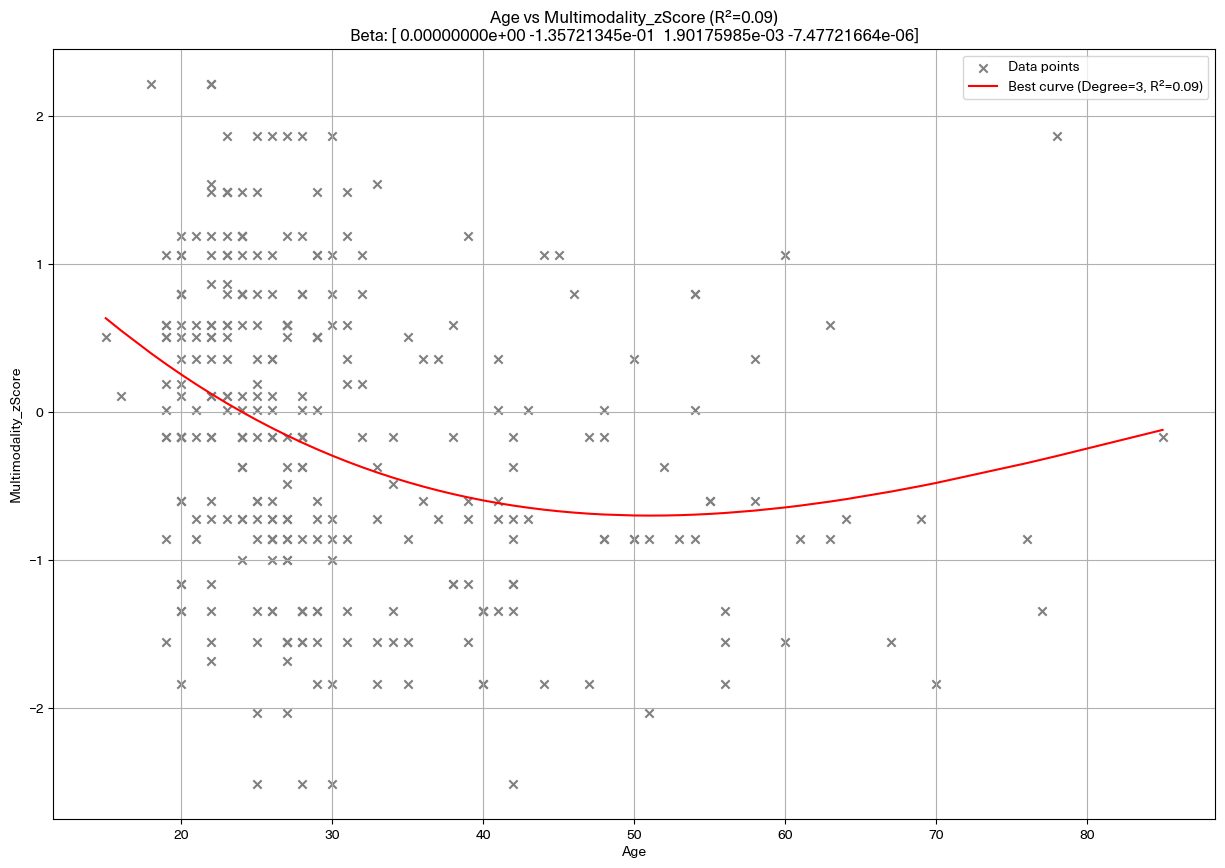

Plot saved to D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\Presi\20-12-2024-Prof.Simone\Age_Multimodality_with_Beta.pdf
R²: 0.09
Beta coefficients: [ 0.00000000e+00 -1.35721345e-01  1.90175985e-03 -7.47721664e-06]


In [144]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Function to find the best curve, calculate Beta, and save the plot
def plot_best_curve_and_save_with_beta(df, x_col, y_col, output_path):
    # Drop nulls and sort by the x-axis column
    df = df[[x_col, y_col]].dropna().sort_values(by=x_col)
    
    # Extract x and y values
    x = df[x_col].values.reshape(-1, 1)
    y = df[y_col].values
    
    # Polynomial regression (degree 3)
    poly = PolynomialFeatures(degree=3)
    x_poly = poly.fit_transform(x)
    
    model = LinearRegression()
    model.fit(x_poly, y)
    y_pred = model.predict(x_poly)
    
    # Calculate R²
    r2 = r2_score(y, y_pred)
    
    # Get Beta coefficients
    beta_coefficients = model.coef_
    
    # Plot the data and curve
    plt.figure(figsize=(15, 10))
    plt.scatter(x, y, color="gray", marker="x", label="Data points")  # Black 'x' markers for data points
    plt.plot(x, y_pred, color="red", label=f"Best curve (Degree=3, R²={r2:.2f})")
    plt.xlabel("Age")
    plt.ylabel("Multimodality_zScore")
    plt.title(f"Age vs Multimodality_zScore (R²={r2:.2f})\nBeta: {beta_coefficients}")
    plt.legend()
    plt.grid(True)
    
    # Save the plot as a PDF
    plt.savefig(output_path, format="pdf", bbox_inches="tight")
    plt.show()
    
    # Print results
    print(f"Plot saved to {output_path}")
    print(f"R²: {r2:.2f}")
    print(f"Beta coefficients: {beta_coefficients}")

# Define the output path
output_path = r"D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\Presi\20-12-2024-Prof.Simone\Age_Multimodality_with_Beta.pdf"

# Example usage
plot_best_curve_and_save_with_beta(merged_dataset, "Age", "Multimodality_zScore", output_path)


#### 5.7.1.2 Age vs Multimotility

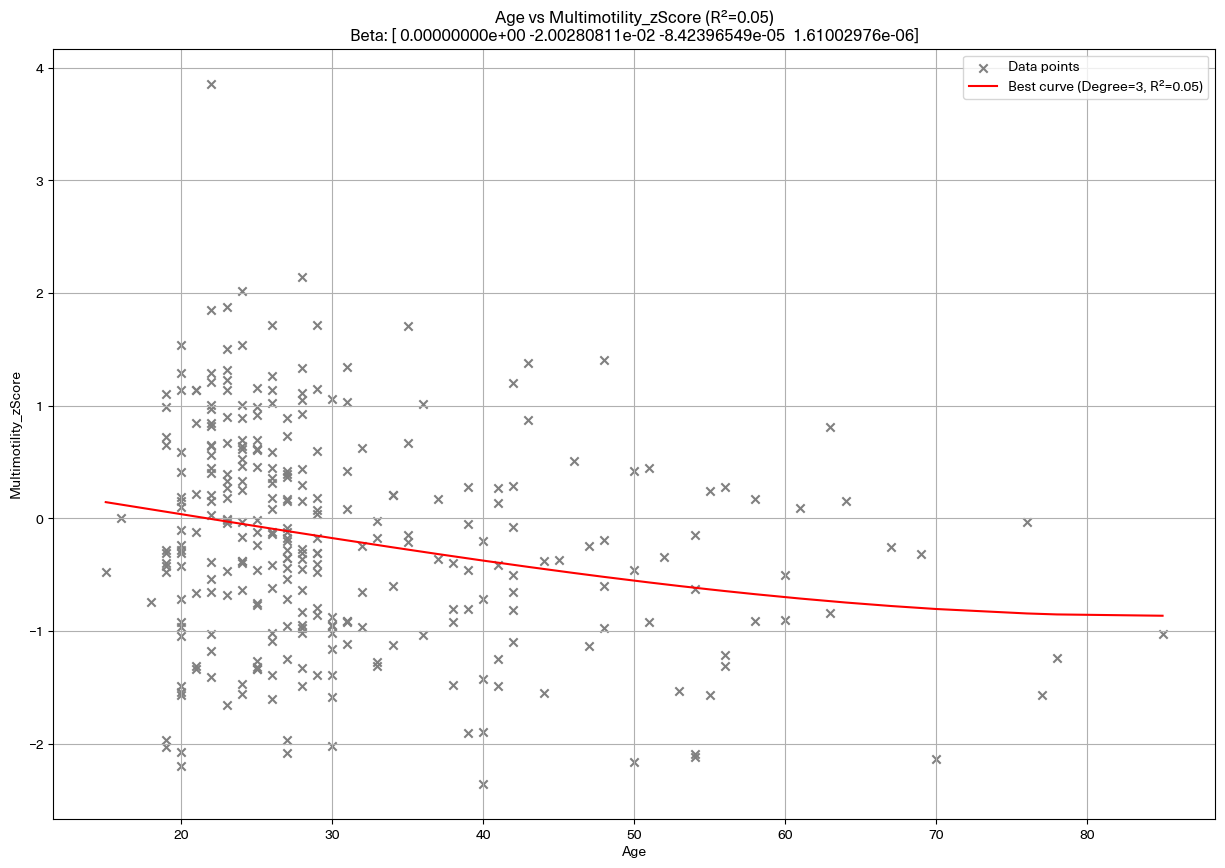

Plot saved to D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\Presi\20-12-2024-Prof.Simone\Age_multimotility_with_Beta.pdf
R²: 0.05
Beta coefficients: [ 0.00000000e+00 -2.00280811e-02 -8.42396549e-05  1.61002976e-06]


In [146]:
# Function to find the best curve, calculate Beta, and save the plot
def plot_best_curve_and_save_with_beta(df, x_col, y_col, output_path):
    # Drop nulls and sort by the x-axis column
    df = df[[x_col, y_col]].dropna().sort_values(by=x_col)
    
    # Extract x and y values
    x = df[x_col].values.reshape(-1, 1)
    y = df[y_col].values
    
    # Polynomial regression (degree 3)
    poly = PolynomialFeatures(degree=3)
    x_poly = poly.fit_transform(x)
    
    model = LinearRegression()
    model.fit(x_poly, y)
    y_pred = model.predict(x_poly)
    
    # Calculate R²
    r2 = r2_score(y, y_pred)
    
    # Get Beta coefficients
    beta_coefficients = model.coef_
    
    # Plot the data and curve
    plt.figure(figsize=(15, 10))
    plt.scatter(x, y, color="gray", marker="x", label="Data points")  # Black 'x' markers for data points
    plt.plot(x, y_pred, color="red", label=f"Best curve (Degree=3, R²={r2:.2f})")
    plt.xlabel("Age")
    plt.ylabel("Multimotility_zScore")
    plt.title(f"Age vs Multimotility_zScore (R²={r2:.2f})\nBeta: {beta_coefficients}")
    plt.legend()
    plt.grid(True)
    
    # Save the plot as a PDF
    plt.savefig(output_path, format="pdf", bbox_inches="tight")
    plt.show()
    
    # Print results
    print(f"Plot saved to {output_path}")
    print(f"R²: {r2:.2f}")
    print(f"Beta coefficients: {beta_coefficients}")

# Define the output path
output_path = r"D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\Presi\20-12-2024-Prof.Simone\Age_multimotility_with_Beta.pdf"

# Example usage
plot_best_curve_and_save_with_beta(merged_dataset, "Age", "Multimotility_zScore", output_path)


### 5.7.2 Distance

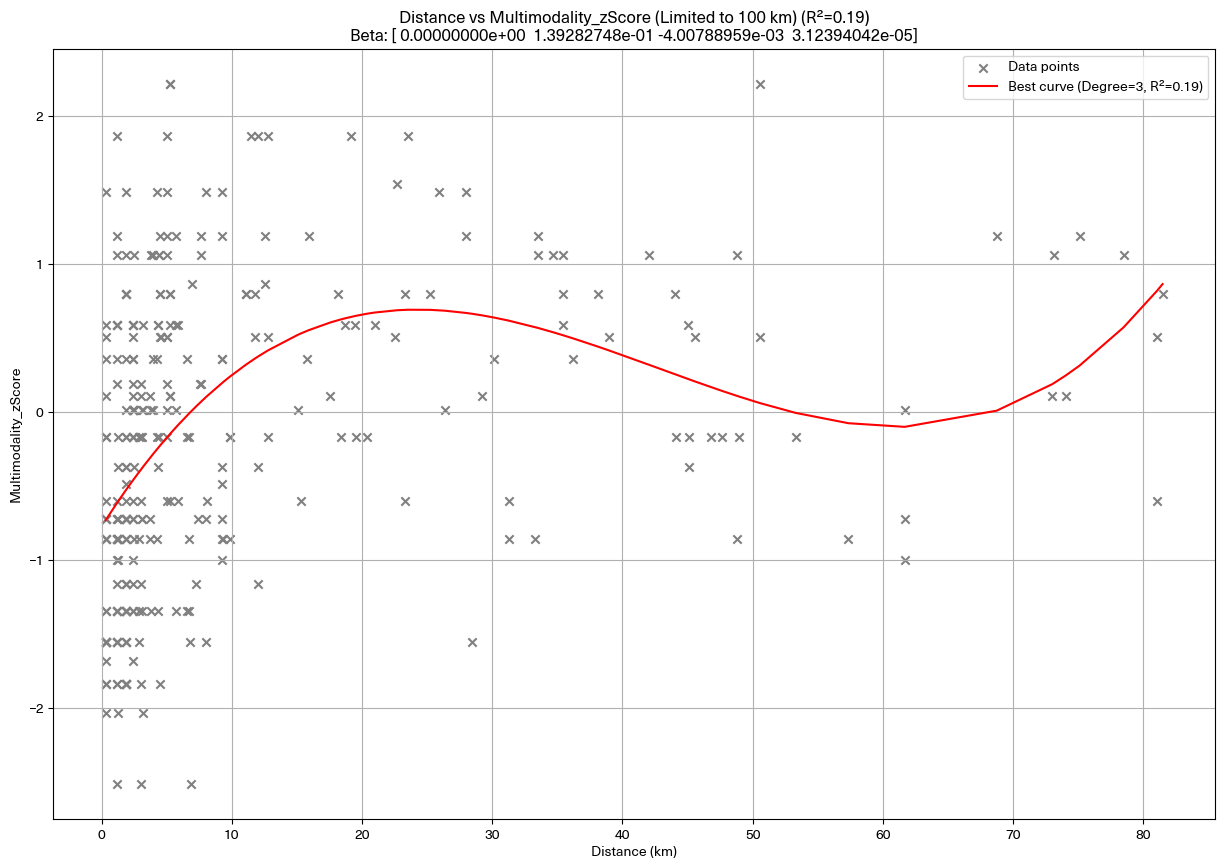

Plot saved to D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\Presi\20-12-2024-Prof.Simone\Distance_Multimodality_with_Beta.pdf
R²: 0.19
Beta coefficients: [ 0.00000000e+00  1.39282748e-01 -4.00788959e-03  3.12394042e-05]


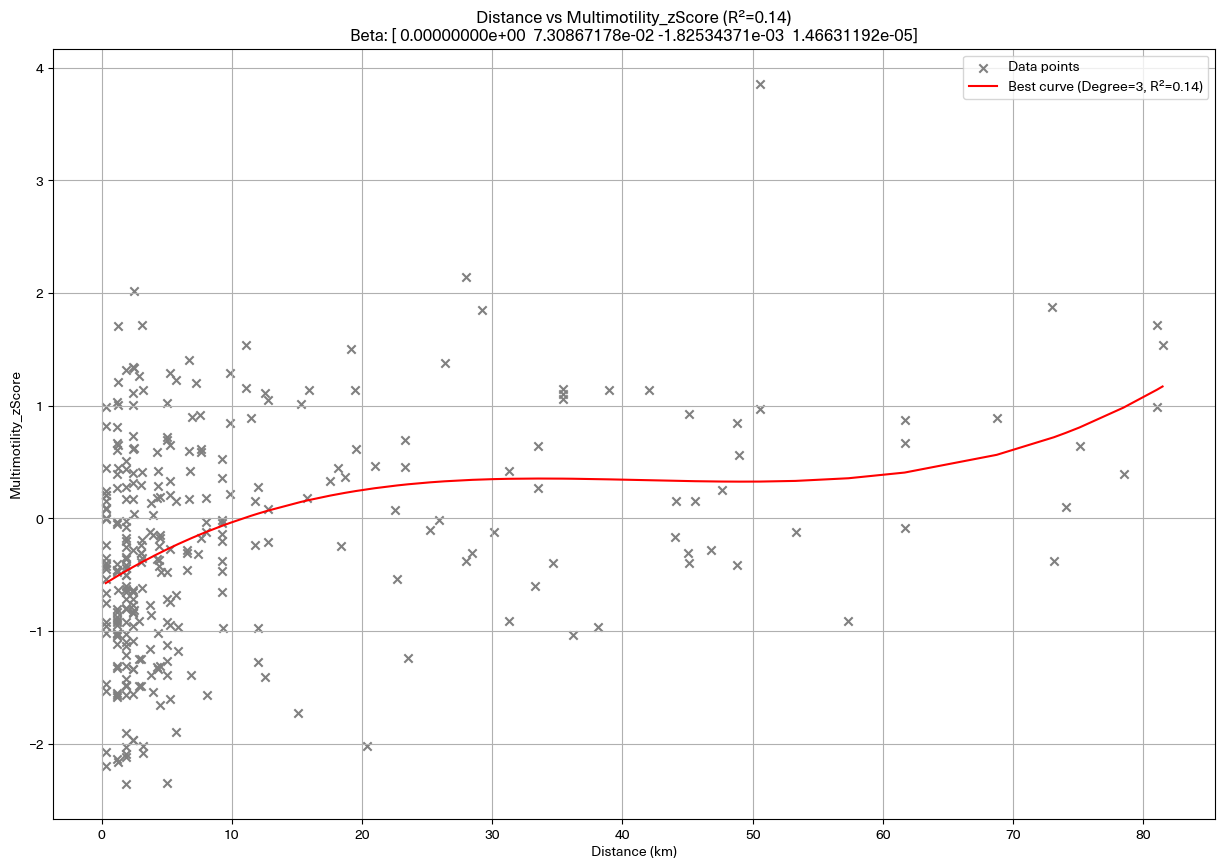

Plot saved to D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\Presi\20-12-2024-Prof.Simone\Distance_Multimotility_with_Beta.pdf
R²: 0.14
Beta coefficients: [ 0.00000000e+00  7.30867178e-02 -1.82534371e-03  1.46631192e-05]


In [282]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Function to find the best curve, calculate Beta, and save the plot
def plot_best_curve_and_save_with_beta(df, x_col, y_col, xlabel, ylabel, title, output_path, distance_limit=None):
    # Filter the dataset if a distance limit is specified
    if distance_limit is not None:
        df = df[df[x_col] <= distance_limit]
    
    # Drop nulls and sort by the x-axis column
    df = df[[x_col, y_col]].dropna().sort_values(by=x_col)
    
    # Extract x and y values
    x = df[x_col].values.reshape(-1, 1)
    y = df[y_col].values
    
    # Polynomial regression (degree 3)
    poly = PolynomialFeatures(degree=3)
    x_poly = poly.fit_transform(x)
    
    model = LinearRegression()
    model.fit(x_poly, y)
    y_pred = model.predict(x_poly)
    
    # Calculate R²
    r2 = r2_score(y, y_pred)
    
    # Get Beta coefficients
    beta_coefficients = model.coef_
    
    # Plot the data and curve
    plt.figure(figsize=(15, 10))
    plt.scatter(x, y, color="gray", marker="x", label="Data points")  # Gray 'x' markers for data points
    plt.plot(x, y_pred, color="red", label=f"Best curve (Degree=3, R²={r2:.2f})")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f"{title} (R²={r2:.2f})\nBeta: {beta_coefficients}")
    plt.legend()
    plt.grid(True)
    
    # Save the plot as a PDF
    plt.savefig(output_path, format="pdf", bbox_inches="tight")
    plt.show()
    
    # Print results
    print(f"Plot saved to {output_path}")
    print(f"R²: {r2:.2f}")
    print(f"Beta coefficients: {beta_coefficients}")

# Define the output paths
output_path1 = r"D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\Presi\20-12-2024-Prof.Simone\Distance_Multimodality_with_Beta.pdf"
output_path2 = r"D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\Presi\20-12-2024-Prof.Simone\Distance_Multimotility_with_Beta.pdf"

# Create the first graph: Distance vs Multimodality_zScore (limiting distance to 100 km)
plot_best_curve_and_save_with_beta(
    df=merged_dataset,
    x_col="distance",
    y_col="Multimodality_zScore",
    xlabel="Distance (km)",
    ylabel="Multimodality_zScore",
    title="Distance vs Multimodality_zScore (Limited to 100 km)",
    output_path=output_path1,
    distance_limit=100  # Limit distance to 100 km
)

# Create the second graph: Distance vs Multimotility_zScore (limiting distance to 100 km)
plot_best_curve_and_save_with_beta(
    df=merged_dataset,
    x_col="distance",
    y_col="Multimotility_zScore",
    xlabel="Distance (km)",
    ylabel="Multimotility_zScore",
    title="Distance vs Multimotility_zScore",
    output_path=output_path2,
    distance_limit=100  # Limit distance to 100 km
)


### 5.7.3 Travel time 

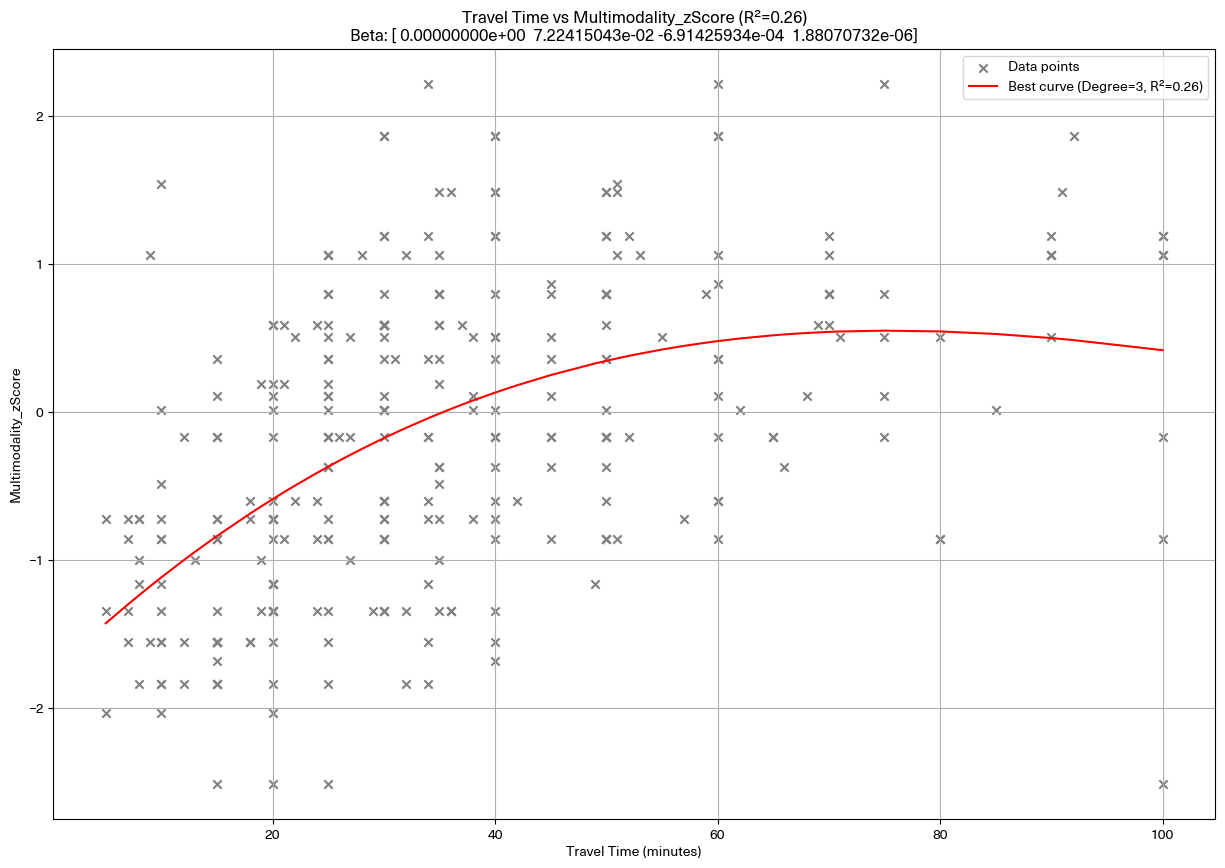

Plot saved to D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\Presi\20-12-2024-Prof.Simone\TravelTime_Multimodality_with_Beta.pdf
R²: 0.26
Beta coefficients: [ 0.00000000e+00  7.22415043e-02 -6.91425934e-04  1.88070732e-06]


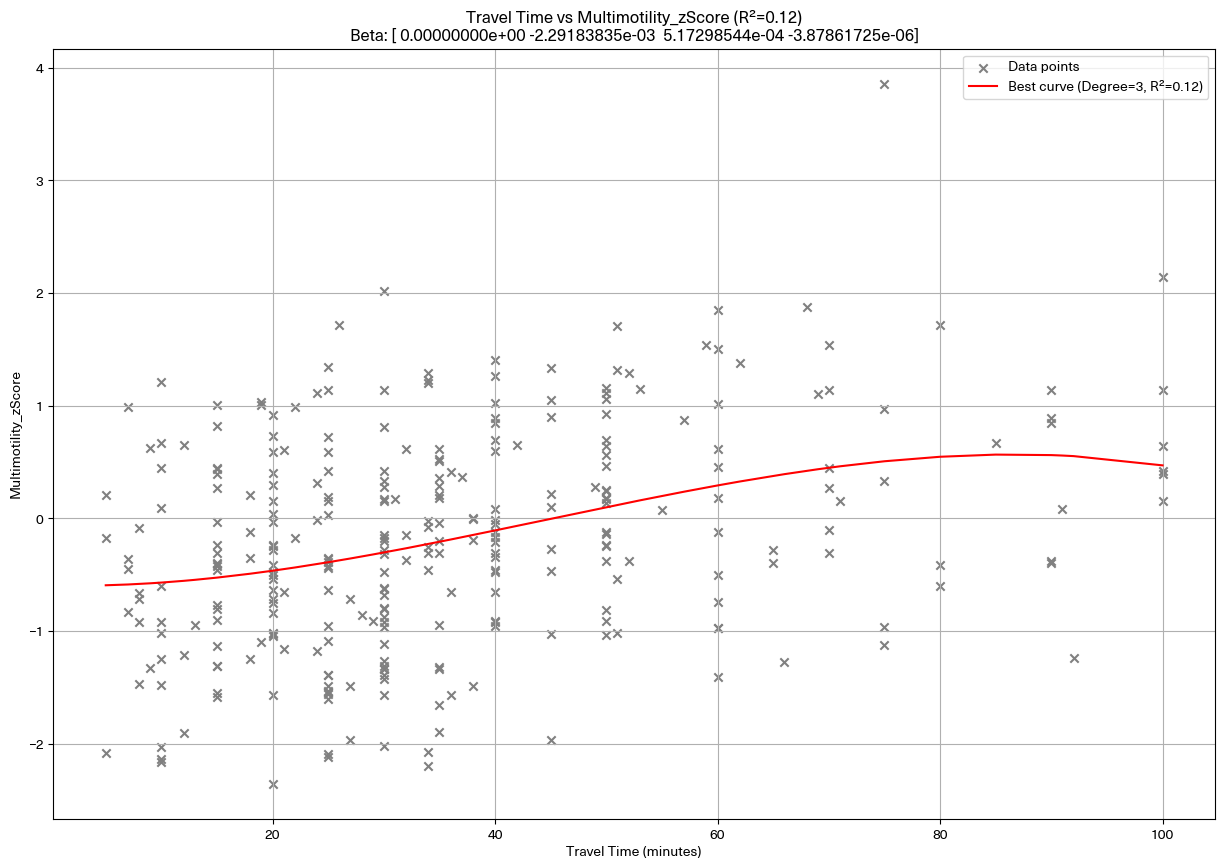

Plot saved to D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\Presi\20-12-2024-Prof.Simone\TravelTime_Multimotility_with_Beta.pdf
R²: 0.12
Beta coefficients: [ 0.00000000e+00 -2.29183835e-03  5.17298544e-04 -3.87861725e-06]


In [284]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Function to find the best curve, calculate Beta, and save the plot
def plot_best_curve_and_save_with_beta(df, x_col, y_col, xlabel, ylabel, title, output_path):
    # Drop nulls and sort by the x-axis column
    df = df[[x_col, y_col]].dropna().sort_values(by=x_col)
    
    # Extract x and y values
    x = df[x_col].values.reshape(-1, 1)
    y = df[y_col].values
    
    # Polynomial regression (degree 3)
    poly = PolynomialFeatures(degree=3)
    x_poly = poly.fit_transform(x)
    
    model = LinearRegression()
    model.fit(x_poly, y)
    y_pred = model.predict(x_poly)
    
    # Calculate R²
    r2 = r2_score(y, y_pred)
    
    # Get Beta coefficients
    beta_coefficients = model.coef_
    
    # Plot the data and curve
    plt.figure(figsize=(15, 10))
    plt.scatter(x, y, color="gray", marker="x", label="Data points")  # Gray 'x' markers for data points
    plt.plot(x, y_pred, color="red", label=f"Best curve (Degree=3, R²={r2:.2f})")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f"{title} (R²={r2:.2f})\nBeta: {beta_coefficients}")
    plt.legend()
    plt.grid(True)
    
    # Save the plot as a PDF
    plt.savefig(output_path, format="pdf", bbox_inches="tight")
    plt.show()
    
    # Print results
    print(f"Plot saved to {output_path}")
    print(f"R²: {r2:.2f}")
    print(f"Beta coefficients: {beta_coefficients}")

# Define the output paths
output_path1 = r"D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\Presi\20-12-2024-Prof.Simone\TravelTime_Multimodality_with_Beta.pdf"
output_path2 = r"D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\Presi\20-12-2024-Prof.Simone\TravelTime_Multimotility_with_Beta.pdf"

# Create the first graph: TravelTime vs Multimodality_zScore
plot_best_curve_and_save_with_beta(
    df=merged_dataset,
    x_col="travel_time",
    y_col="Multimodality_zScore",
    xlabel="Travel Time (minutes)",
    ylabel="Multimodality_zScore",
    title="Travel Time vs Multimodality_zScore",
    output_path=output_path1
)

# Create the second graph: TravelTime vs Multimotility_zScore
plot_best_curve_and_save_with_beta(
    df=merged_dataset,
    x_col="travel_time",
    y_col="Multimotility_zScore",
    xlabel="Travel Time (minutes)",
    ylabel="Multimotility_zScore",
    title="Travel Time vs Multimotility_zScore",
    output_path=output_path2
)


### 5.7.4 Waiting time

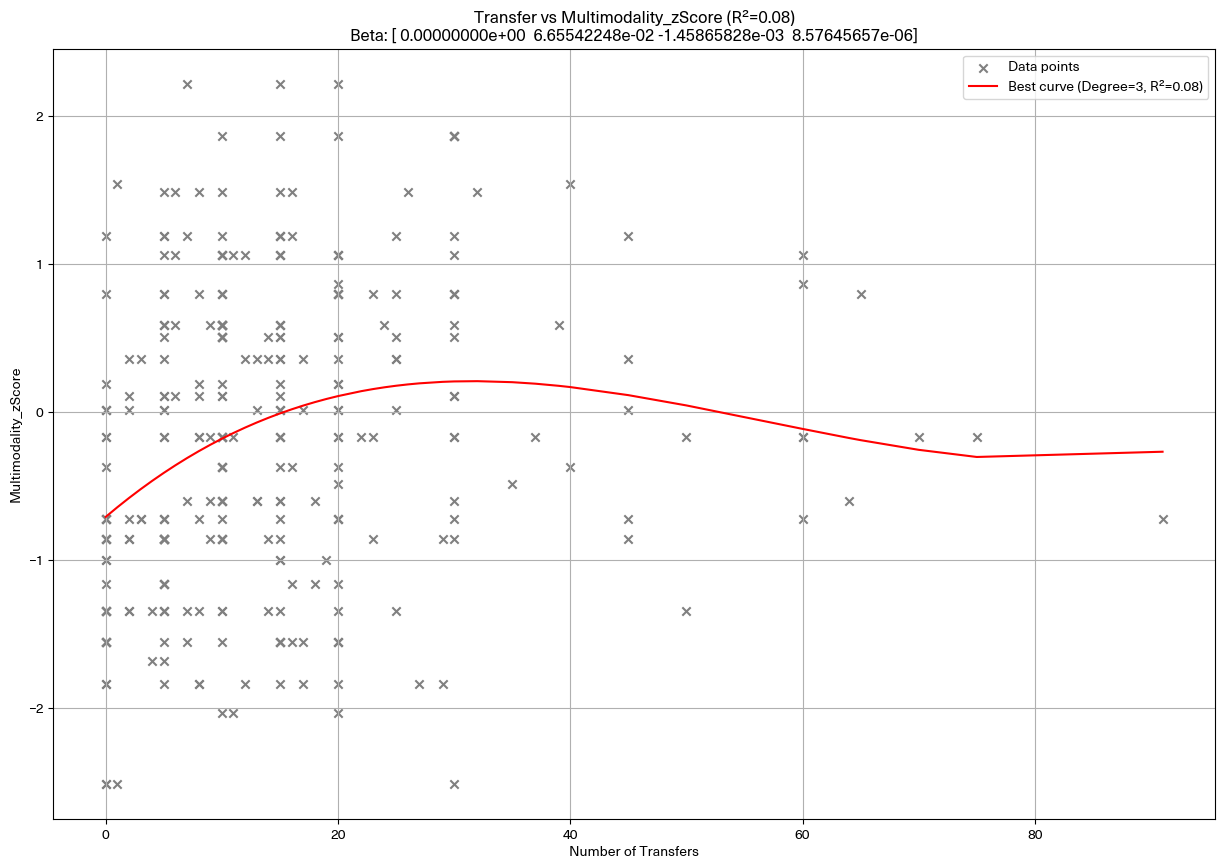

Plot saved to D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\Presi\20-12-2024-Prof.Simone\Transfer_Multimodality_with_Beta.pdf
R²: 0.08
Beta coefficients: [ 0.00000000e+00  6.65542248e-02 -1.45865828e-03  8.57645657e-06]


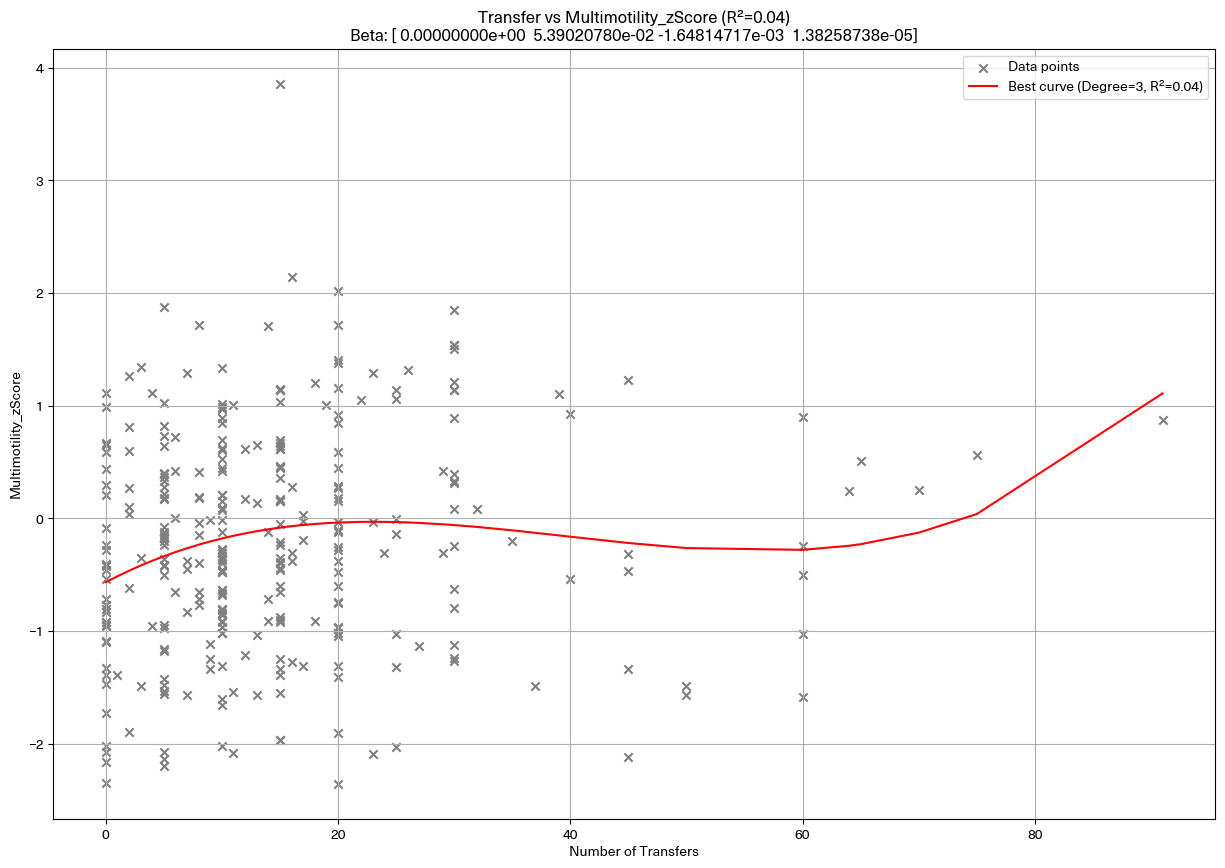

Plot saved to D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\Presi\20-12-2024-Prof.Simone\Transfer_Multimotility_with_Beta.pdf
R²: 0.04
Beta coefficients: [ 0.00000000e+00  5.39020780e-02 -1.64814717e-03  1.38258738e-05]


In [287]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Function to find the best curve, calculate Beta, and save the plot
def plot_best_curve_and_save_with_beta(df, x_col, y_col, xlabel, ylabel, title, output_path):
    # Drop nulls and sort by the x-axis column
    df = df[[x_col, y_col]].dropna().sort_values(by=x_col)
    
    # Extract x and y values
    x = df[x_col].values.reshape(-1, 1)
    y = df[y_col].values
    
    # Polynomial regression (degree 3)
    poly = PolynomialFeatures(degree=3)
    x_poly = poly.fit_transform(x)
    
    model = LinearRegression()
    model.fit(x_poly, y)
    y_pred = model.predict(x_poly)
    
    # Calculate R²
    r2 = r2_score(y, y_pred)
    
    # Get Beta coefficients
    beta_coefficients = model.coef_
    
    # Plot the data and curve
    plt.figure(figsize=(15, 10))
    plt.scatter(x, y, color="gray", marker="x", label="Data points")  # Gray 'x' markers for data points
    plt.plot(x, y_pred, color="red", label=f"Best curve (Degree=3, R²={r2:.2f})")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f"{title} (R²={r2:.2f})\nBeta: {beta_coefficients}")
    plt.legend()
    plt.grid(True)
    
    # Save the plot as a PDF
    plt.savefig(output_path, format="pdf", bbox_inches="tight")
    plt.show()
    
    # Print results
    print(f"Plot saved to {output_path}")
    print(f"R²: {r2:.2f}")
    print(f"Beta coefficients: {beta_coefficients}")

# Define the output paths
output_path1 = r"D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\Presi\20-12-2024-Prof.Simone\Transfer_Multimodality_with_Beta.pdf"
output_path2 = r"D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\Presi\20-12-2024-Prof.Simone\Transfer_Multimotility_with_Beta.pdf"

# Create the first graph: Transfer vs Multimodality_zScore
plot_best_curve_and_save_with_beta(
    df=merged_dataset,
    x_col="transfer",
    y_col="Multimodality_zScore",
    xlabel="Number of Transfers",
    ylabel="Multimodality_zScore",
    title="Transfer vs Multimodality_zScore",
    output_path=output_path1
)

# Create the second graph: Transfer vs Multimotility_zScore
plot_best_curve_and_save_with_beta(
    df=merged_dataset,
    x_col="transfer",
    y_col="Multimotility_zScore",
    xlabel="Number of Transfers",
    ylabel="Multimotility_zScore",
    title="Transfer vs Multimotility_zScore",
    output_path=output_path2
)


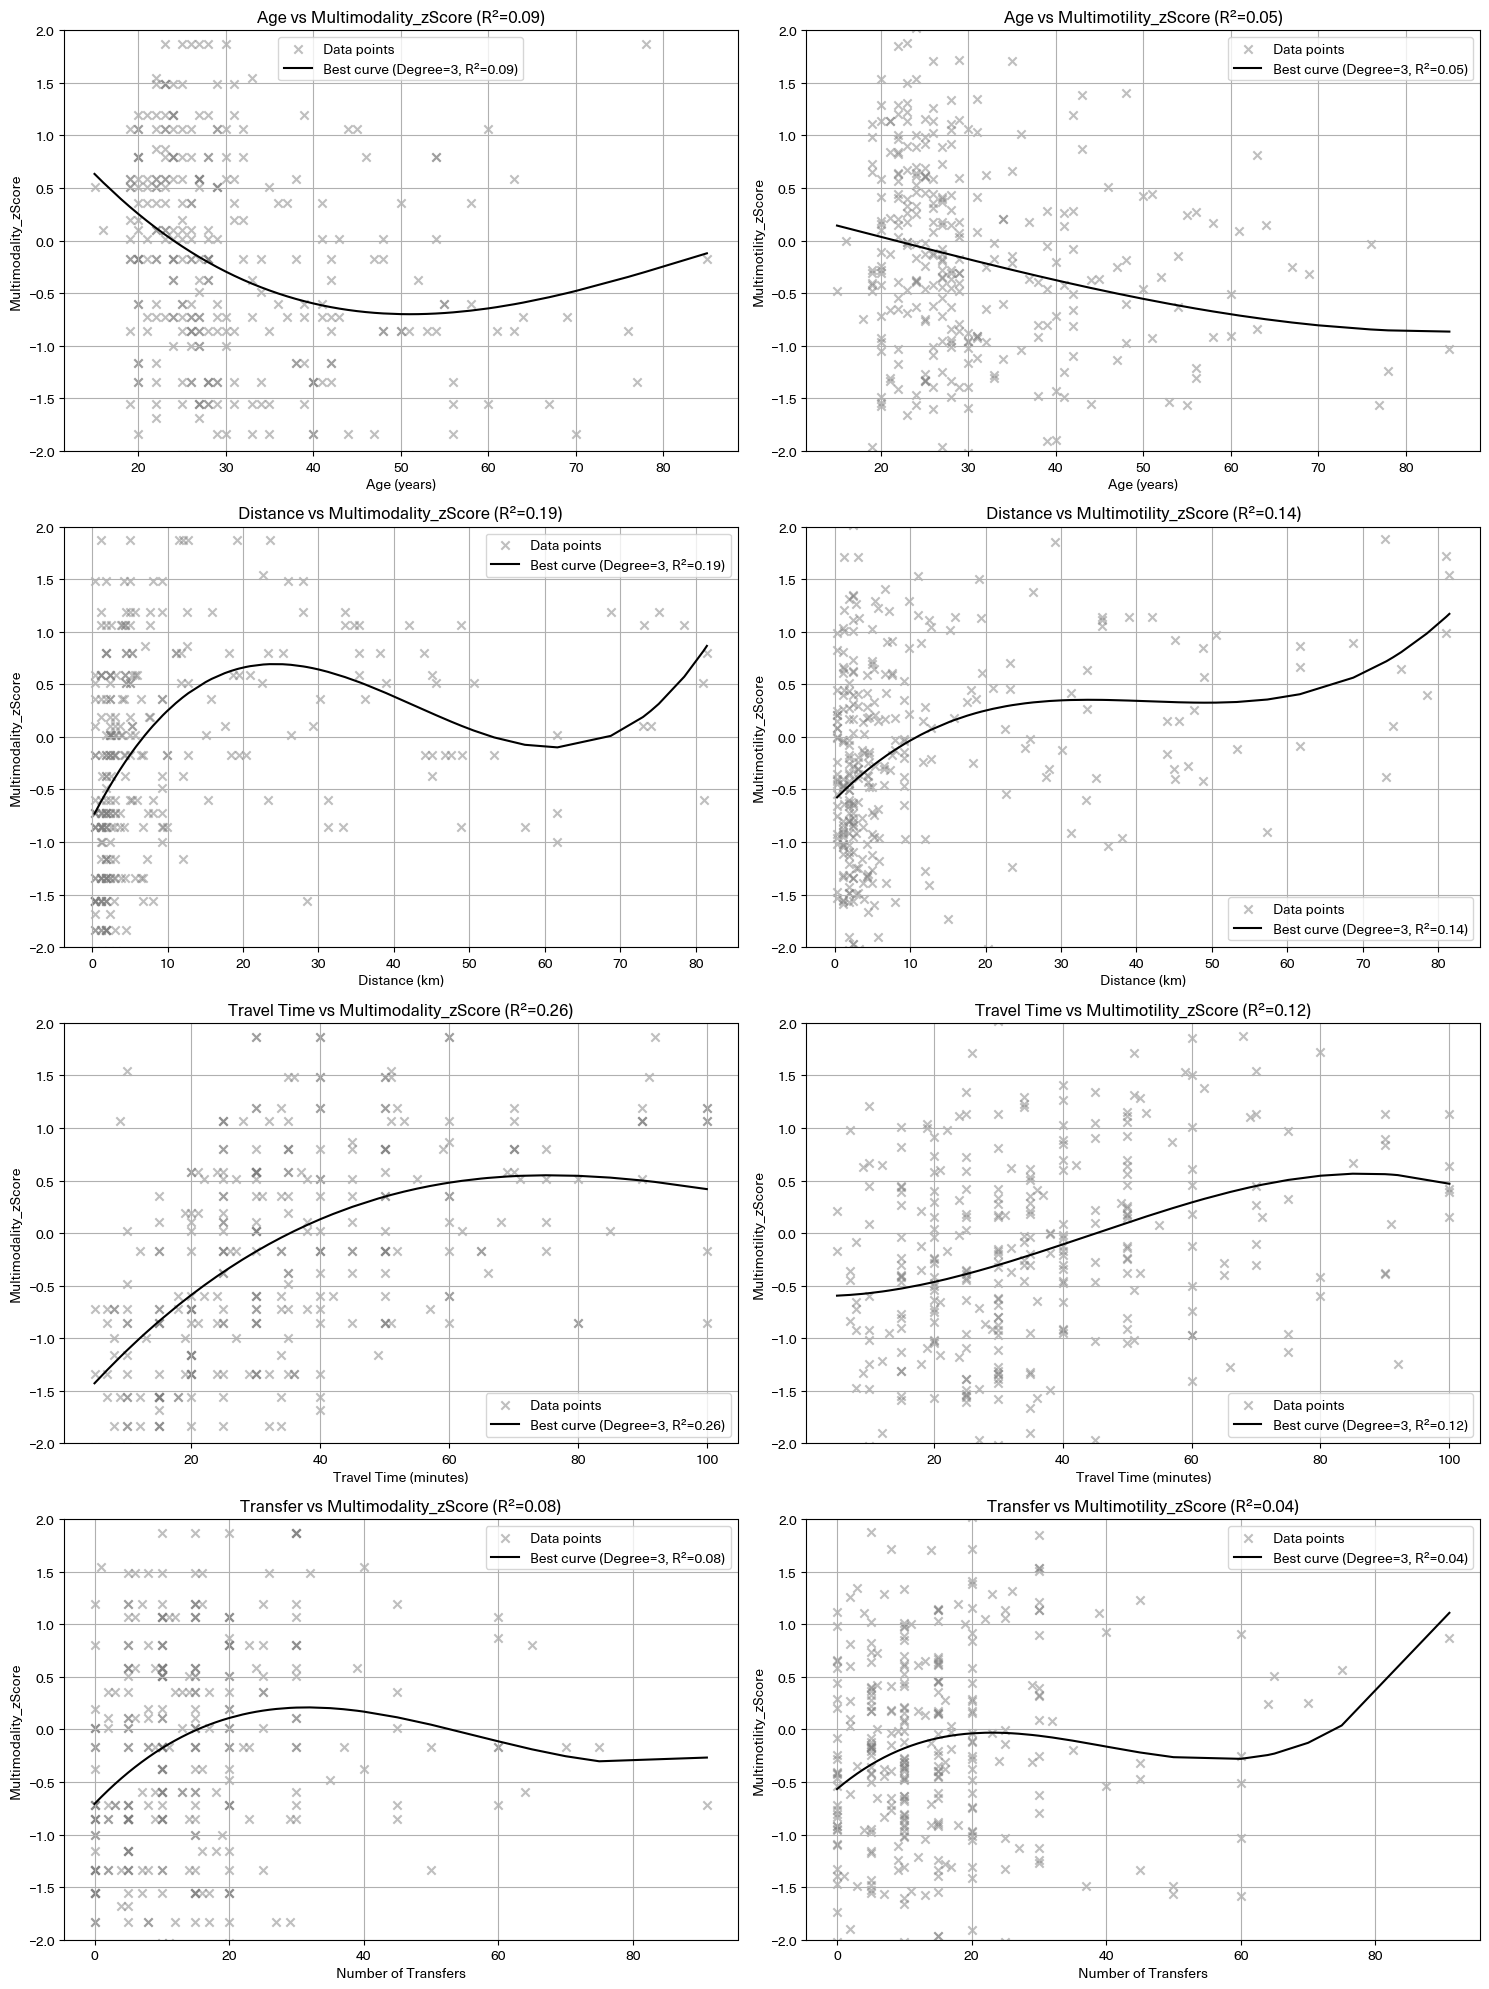

In [305]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Function to plot paired comparisons for multimodality and multimotility
def plot_comparisons(df, x_cols, y_cols, titles, xlabels, ylabels, output_path, distance_limit=None, y_limit=None):
    # Initialize the figure
    plt.figure(figsize=(15, 20))  # Adjust figure size for 4 rows x 2 columns
    
    for i, x_col in enumerate(x_cols):
        for j, y_col in enumerate(y_cols):
            # Apply distance filter if x_col is 'distance'
            if distance_limit is not None and x_col == "distance":
                data = df[df[x_col] <= distance_limit][[x_col, y_col]].dropna().sort_values(by=x_col)
            else:
                data = df[[x_col, y_col]].dropna().sort_values(by=x_col)
            
            # Extract x and y values
            x = data[x_col].values.reshape(-1, 1)
            y = data[y_col].values

            # Polynomial regression (degree 3)
            poly = PolynomialFeatures(degree=3)
            x_poly = poly.fit_transform(x)
            model = LinearRegression()
            model.fit(x_poly, y)
            y_pred = model.predict(x_poly)
            
            # Calculate R²
            r2 = r2_score(y, y_pred)
            
            # Create subplot
            plt.subplot(len(x_cols), 2, i * 2 + j + 1)
            plt.scatter(x, y, color="gray", marker="x", alpha=0.5, label="Data points")  # Add alpha for transparency
            plt.plot(x, y_pred, color="black", label=f"Best curve (Degree=3, R²={r2:.2f})")
            plt.xlabel(xlabels[i])
            plt.ylabel(ylabels[j])
            plt.title(f"{titles[i][j]} (R²={r2:.2f})")
            if y_limit is not None:
                plt.ylim(y_limit)  # Set fixed y-axis limits
            plt.legend()
            plt.grid(True)
    
    # Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig(output_path, format="pdf", bbox_inches="tight")
    plt.show()

# Input variables
x_cols = ["Age", "distance", "travel_time", "transfer"]
y_cols = ["Multimodality_zScore", "Multimotility_zScore"]
titles = [
    ["Age vs Multimodality_zScore", "Age vs Multimotility_zScore"],
    ["Distance vs Multimodality_zScore", "Distance vs Multimotility_zScore"],
    ["Travel Time vs Multimodality_zScore", "Travel Time vs Multimotility_zScore"],
    ["Transfer vs Multimodality_zScore", "Transfer vs Multimotility_zScore"]
]
xlabels = ["Age (years)", "Distance (km)", "Travel Time (minutes)", "Number of Transfers"]
ylabels = ["Multimodality_zScore", "Multimotility_zScore"]

# Output path
output_path = r"D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\Presi\20-12-2024-Prof.Simone\Comparison_All_Variables_Scaled.pdf"

# Distance limit in kilometers
distance_limit = 100  # Limit distance to 100 km

# Y-axis limit for visualization
y_limit = (-2, 2)  # Set the same range for both z-scores for visual comparison

# Plot and save the figure
plot_comparisons(
    df=merged_dataset,
    x_cols=x_cols,
    y_cols=y_cols,
    titles=titles,
    xlabels=xlabels,
    ylabels=ylabels,
    output_path=output_path,
    distance_limit=distance_limit,
    y_limit=y_limit
)

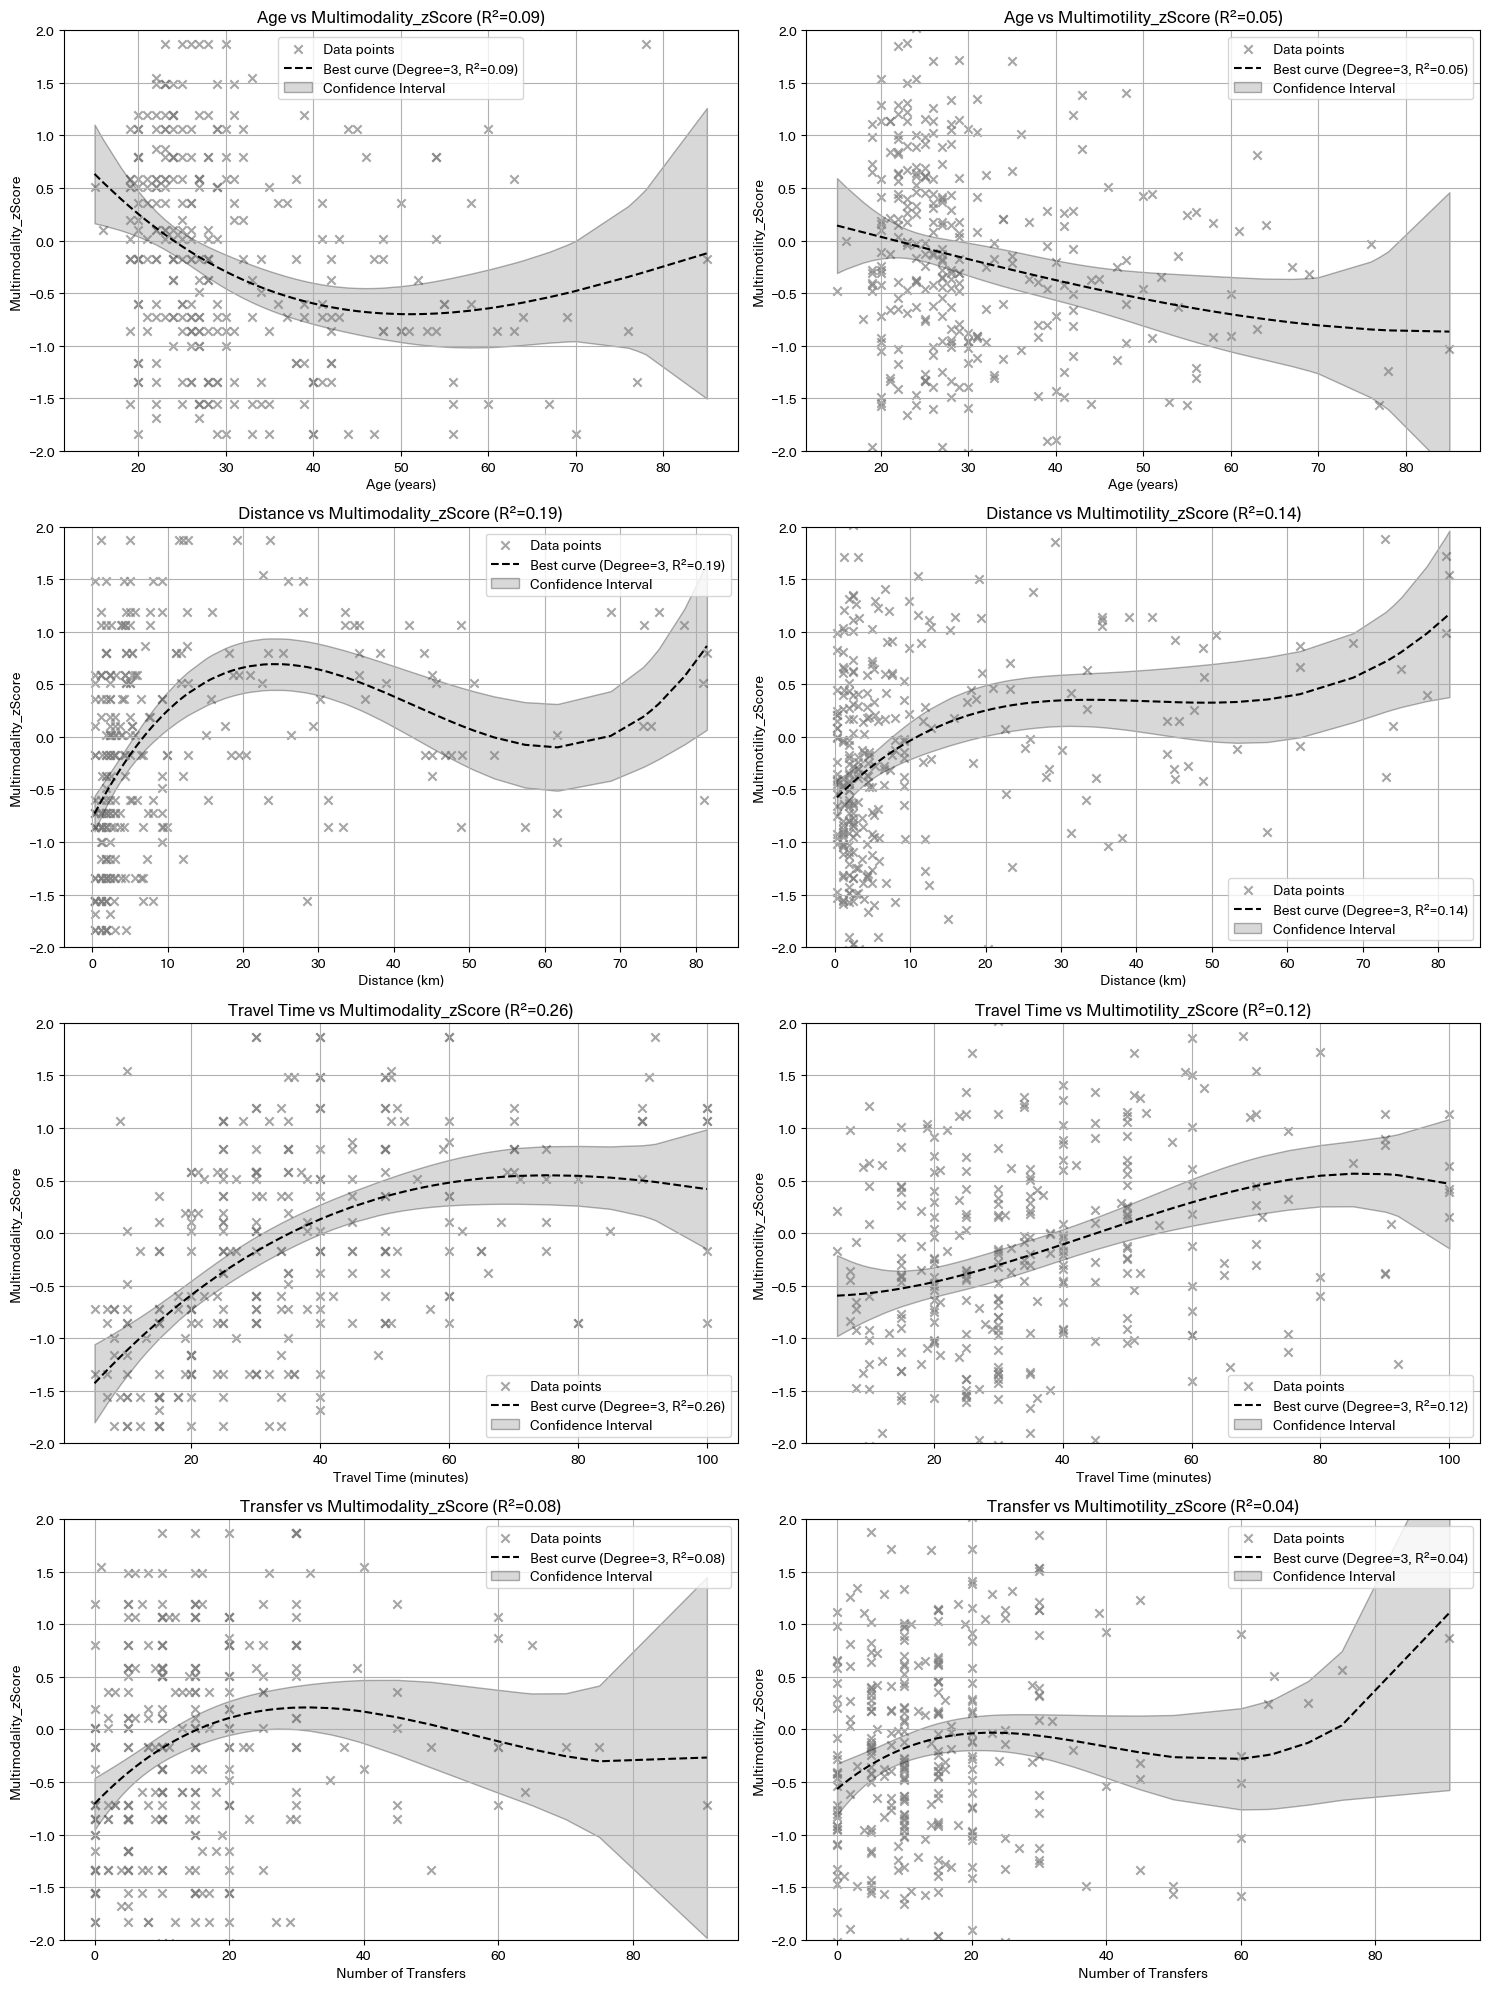

    X Variable            Y Variable        R²  Confidence Interval Alpha
0          Age  Multimodality_zScore  0.092860                       0.95
1          Age  Multimotility_zScore  0.052295                       0.95
2     distance  Multimodality_zScore  0.189420                       0.95
3     distance  Multimotility_zScore  0.136320                       0.95
4  travel_time  Multimodality_zScore  0.263984                       0.95
5  travel_time  Multimotility_zScore  0.121125                       0.95
6     transfer  Multimodality_zScore  0.076970                       0.95
7     transfer  Multimotility_zScore  0.035847                       0.95


In [313]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import t
import pandas as pd

# Function to calculate and plot with confidence intervals
def plot_with_confidence_intervals_and_table(
    df, x_cols, y_cols, titles, xlabels, ylabels, output_path, distance_limit=None, y_limit=None, alpha=0.95
):
    # Initialize the figure
    plt.figure(figsize=(15, 20))  # Adjust figure size for 4 rows x 2 columns
    results_table = []  # Table to store R² and model details for each plot

    for i, x_col in enumerate(x_cols):
        for j, y_col in enumerate(y_cols):
            # Apply distance filter if x_col is 'distance'
            if distance_limit is not None and x_col == "distance":
                data = df[df[x_col] <= distance_limit][[x_col, y_col]].dropna().sort_values(by=x_col)
            else:
                data = df[[x_col, y_col]].dropna().sort_values(by=x_col)

            # Extract x and y values
            x = data[x_col].values.reshape(-1, 1)
            y = data[y_col].values

            # Polynomial regression (degree 3)
            poly = PolynomialFeatures(degree=3)
            x_poly = poly.fit_transform(x)
            model = LinearRegression()
            model.fit(x_poly, y)
            y_pred = model.predict(x_poly)

            # Calculate confidence intervals
            residuals = y - y_pred
            dof = len(y) - len(model.coef_)
            residual_std_error = np.sqrt(np.sum(residuals**2) / dof)
            t_value = t.ppf(1 - (1 - alpha) / 2, df=dof)
            x_poly_inv = np.linalg.inv(x_poly.T @ x_poly)  # Inverse of design matrix
            se = np.sqrt(np.sum((x_poly @ x_poly_inv) * x_poly, axis=1)) * residual_std_error
            ci_upper = y_pred + t_value * se
            ci_lower = y_pred - t_value * se

            # Calculate R²
            r2 = r2_score(y, y_pred)

            # Add results to the table
            results_table.append({
                "X Variable": x_col,
                "Y Variable": y_col,
                "R²": r2,
                "Confidence Interval Alpha": alpha
            })

            # Create subplot
            plt.subplot(len(x_cols), 2, i * 2 + j + 1)
            plt.scatter(x, y, color="gray", marker="x", alpha=0.7, label="Data points")  # Add alpha for transparency
            plt.plot(x, y_pred, color="black", linestyle="--", label=f"Best curve (Degree=3, R²={r2:.2f})")
            plt.fill_between(
                x.flatten(), ci_lower, ci_upper, color="gray", alpha=0.3, edgecolor="black", label="Confidence Interval"
            )
            plt.xlabel(xlabels[i])
            plt.ylabel(ylabels[j])
            plt.title(f"{titles[i][j]} (R²={r2:.2f})")
            if y_limit is not None:
                plt.ylim(y_limit)  # Set fixed y-axis limits
            plt.legend()
            plt.grid(True)

    # Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig(output_path, format="pdf", bbox_inches="tight")
    plt.show()

    # Convert results table to a DataFrame and display
    results_df = pd.DataFrame(results_table)
    return results_df

# Input variables
x_cols = ["Age", "distance", "travel_time", "transfer"]
y_cols = ["Multimodality_zScore", "Multimotility_zScore"]
titles = [
    ["Age vs Multimodality_zScore", "Age vs Multimotility_zScore"],
    ["Distance vs Multimodality_zScore", "Distance vs Multimotility_zScore"],
    ["Travel Time vs Multimodality_zScore", "Travel Time vs Multimotility_zScore"],
    ["Transfer vs Multimodality_zScore", "Transfer vs Multimotility_zScore"]
]
xlabels = ["Age (years)", "Distance (km)", "Travel Time (minutes)", "Number of Transfers"]
ylabels = ["Multimodality_zScore", "Multimotility_zScore"]

# Output path
output_path = r"D:\15_Polimi\Polimi_onedrive\OneDrive - Politecnico di Milano\PhD\Presi\20-12-2024-Prof.Simone\Comparison_All_Variables_Confidence_Intervals.pdf"

# Distance limit in kilometers
distance_limit = 100  # Limit distance to 100 km

# Y-axis limit for visualization
y_limit = (-2, 2)  # Set the same range for both z-scores for visual comparison

# Run the function
# Replace `merged_dataset` with your actual DataFrame
results_df = plot_with_confidence_intervals_and_table(
    df=merged_dataset,
    x_cols=x_cols,
    y_cols=y_cols,
    titles=titles,
    xlabels=xlabels,
    ylabels=ylabels,
    output_path=output_path,
    distance_limit=distance_limit,
    y_limit=y_limit
)

# Display the table
import ace_tools as tools; tools.display_dataframe_to_user(name="Confidence Interval Results Table", dataframe=results_df)


In [315]:
com

X Variable            Y Variable        R²  Confidence Interval Alpha
0          Age  Multimodality_zScore  0.092860                       0.95
1          Age  Multimotility_zScore  0.052295                       0.95
2     distance  Multimodality_zScore  0.189420                       0.95
3     distance  Multimotility_zScore  0.136320                       0.95
4  travel_time  Multimodality_zScore  0.263984                       0.95
5  travel_time  Multimotility_zScore  0.121125                       0.95
6     transfer  Multimodality_zScore  0.076970                       0.95
7     transfer  Multimotility_zScore  0.035847                       0.95


Regression Analysis Results:
Polynomial Regression (Degree 3): R² = 0.0929 (S-shaped or complex curve)
Polynomial Regression (Degree 2): R² = 0.0920 (U-shaped or inverted U-shaped curve)
Linear Regression: R² = 0.0595 (Straight line)
Exponential Regression: R² = -372284052484287045358008529464288346112.0000 (Growth or decay trend)

Best Model: Polynomial Regression (Degree 3) with R² = 0.0929
Recommended regression types based on the data:


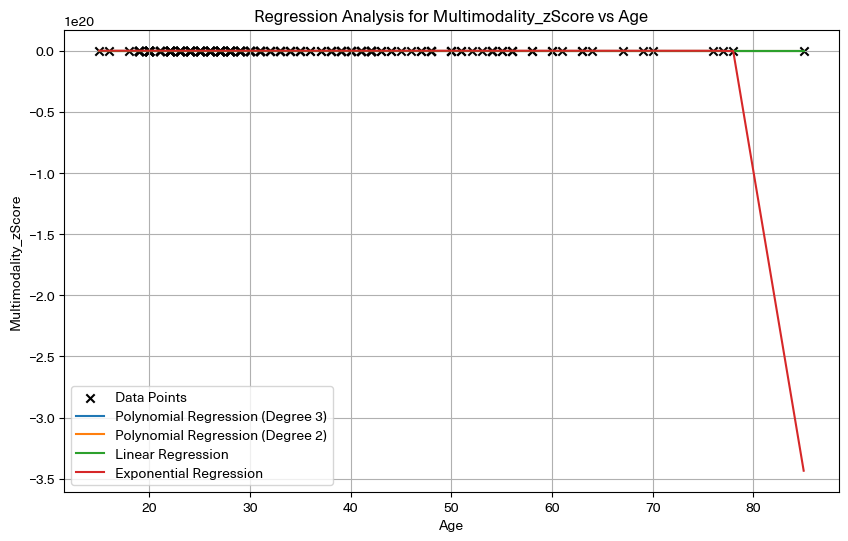

ModuleNotFoundError: No module named 'ace_tools'

In [311]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
import pandas as pd

# Exponential function for regression
def exponential_func(x, a, b):
    return a * np.exp(b * x)

# Function to analyze and guide regression selection
def regression_analysis_with_guidance(df, x_col, y_col):
    # Drop NaN values and sort by x_col
    df = df[[x_col, y_col]].dropna().sort_values(by=x_col)
    x = df[x_col].values.reshape(-1, 1)
    y = df[y_col].values
    
    # Initialize results storage
    models = []
    
    # Linear Regression
    linear_model = LinearRegression()
    linear_model.fit(x, y)
    y_pred_linear = linear_model.predict(x)
    r2_linear = r2_score(y, y_pred_linear)
    models.append(("Linear Regression", r2_linear, y_pred_linear, "Straight line"))
    
    # Polynomial Regression (Degree 2)
    poly2 = PolynomialFeatures(degree=2)
    x_poly2 = poly2.fit_transform(x)
    poly_model2 = LinearRegression()
    poly_model2.fit(x_poly2, y)
    y_pred_poly2 = poly_model2.predict(x_poly2)
    r2_poly2 = r2_score(y, y_pred_poly2)
    models.append(("Polynomial Regression (Degree 2)", r2_poly2, y_pred_poly2, "U-shaped or inverted U-shaped curve"))
    
    # Polynomial Regression (Degree 3)
    poly3 = PolynomialFeatures(degree=3)
    x_poly3 = poly3.fit_transform(x)
    poly_model3 = LinearRegression()
    poly_model3.fit(x_poly3, y)
    y_pred_poly3 = poly_model3.predict(x_poly3)
    r2_poly3 = r2_score(y, y_pred_poly3)
    models.append(("Polynomial Regression (Degree 3)", r2_poly3, y_pred_poly3, "S-shaped or complex curve"))
    
    # Exponential Regression
    try:
        params, _ = curve_fit(exponential_func, x.flatten(), y, maxfev=10000)
        y_pred_exp = exponential_func(x.flatten(), *params)
        r2_exp = r2_score(y, y_pred_exp)
        models.append(("Exponential Regression", r2_exp, y_pred_exp, "Growth or decay trend"))
    except RuntimeError:
        models.append(("Exponential Regression", -np.inf, None, "Growth or decay trend (failed to converge)"))

    # Rank models by R²
    models = sorted(models, key=lambda x: x[1], reverse=True)
    
    # Display results
    print("\nRegression Analysis Results:")
    recommendations = []
    for model_name, r2, _, description in models:
        print(f"{model_name}: R² = {r2:.4f} ({description})")
        if r2 > 0.8:  # Good model
            recommendations.append(f"{model_name} ({description})")
    
    # Best model suggestion
    best_model = models[0]
    print(f"\nBest Model: {best_model[0]} with R² = {best_model[1]:.4f}")
    print("Recommended regression types based on the data:")
    for rec in recommendations:
        print(f"- {rec}")

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, color="black", label="Data Points", marker="x")
    
    for model_name, _, y_pred, _ in models:
        if y_pred is not None:
            plt.plot(x, y_pred, label=model_name)
    
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f"Regression Analysis for {y_col} vs {x_col}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Return ranked models as a DataFrame for additional insights
    results_df = pd.DataFrame({
        "Model": [m[0] for m in models],
        "R²": [m[1] for m in models],
        "Description": [m[3] for m in models]
    })
    return results_df

# Example Usage
# Replace `merged_dataset` with your actual DataFrame
results = regression_analysis_with_guidance(merged_dataset, "Age", "Multimodality_zScore")

# Display the results table
import ace_tools as tools; tools.display_dataframe_to_user(name="Regression Analysis Results", dataframe=results)
